[13.986583502426024, 16.455141078074774, 16.557488067249373, 17.01584787367362, 17.78708728293588, 18.69113980705499, 19.06135368839677, 19.651045234096017, 20.1945280525771, 20.244208265867943, 20.52057665388721, 20.897005176637325, 21.416034860589264, 21.4756851596363, 22.100817691106148, 22.150361885732245, 22.28972194499743, 22.520820726795705, 23.112715827704992, 23.25775092528965, 23.298424280803964, 23.758711957322753, 24.24692552398674, 24.552814749144368, 24.848925600049242, 25.091589139549622, 25.19192925463424, 25.500383584799742, 25.520819003280604, 25.575897316714983, 25.720084876998442, 26.175795811946525, 27.697370877847224, 28.04350909751624, 28.587583458025875, 28.758146911194, 29.08198878592615, 29.608151721478404, 29.7521962802144, 29.829238857384418, 30.12668950627339, 30.851495007926232, 32.59656121078265, 34.2072609309625, 34.98314280913435, 35.25237155968681, 35.68807716496213, 40.01126619943427, 46.875899477218375]


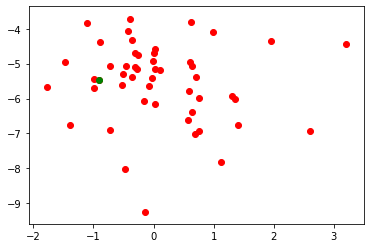

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
import random
import math
import matplotlib.pyplot as plt
from no_cluster import get_cluster
import copy

In [2]:
#random.seed(15)
P=2 #signal power threshold
#stream = BitStream()
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 60000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.001
        self.C = 0.9 #fraction of clients used in the round
        self.drop_rate = 0.1 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1
 
args = Arguments()

In [4]:
#checking if gpu is available
use_cuda = False
#print(use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
clients = []

#generating virtual clients
for i in range(int(args.clients)):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
    
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

/home/test/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average

#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)
trainloader = torch.utils.data.DataLoader(global_train, batch_size=4,
                                          shuffle=True, num_workers=2)

In [6]:
# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))


# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# # show images
# imshow(images[0])
# print(np.shape(images[0]))

In [7]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         #self.quant = torch.quantization.QuantStub()
#         self.conv1 = nn.Conv2d(1, 5, 5, 1)
#         self.conv2 = nn.Conv2d(5, 10, 5, 1)
#         self.fc1 = nn.Linear(4*4*10, 10) #..,50
#         self.fc2 = nn.Linear(10, 10) #50,5  50 non iid 5 iid

#     def forward(self, x):
#         #x=self.quant(x)
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2, 2)
#         x = x.view(-1, 4*4*10
#                    )
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)
    
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)#50

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
        

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.6
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data,target=data,target
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
#                 params=client['model'].parameters()
#                 gp=head['model'].parameters()
#                 params=fedprox(params,gp)
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get() 
    head['model'].get()
    #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        data=data*math.sqrt(poptim) #transmitted signal
        data=h*data+(torch.randn(data.size())*std) #channel affecting data
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))


In [11]:
torch.manual_seed(args.torch_seed)
#global_model = Net() #redundant code as we don't use it for training: assigns a CNN to the global model

for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    

accuracy=[]
rc=1

[12.391541912965952, 14.332070782953625, 14.769954042132602, 14.895764896583488, 17.422815656359372, 17.437510126097536, 17.821153629927974, 18.240138213805025, 18.277362932132007, 18.914892373117546, 19.617974866806932, 20.21487098457923, 21.10269532158381, 21.282865161770438, 22.970977389425087, 23.265767002826422, 23.641228135642812, 23.671158746923165, 23.712132960103503, 24.10390762049326, 24.66660942172393, 25.303597920016873, 25.54477251682601, 26.062430762064338, 26.09145636224758, 26.108203962774297, 26.42134042230769, 26.5060369016718, 27.378693334951635, 27.601591659575504, 27.81256245537012, 27.896201593865296, 29.340547649540984, 29.426155564796098, 29.771955709124253, 30.835810352991913, 31.01873419040672, 32.14908225057372, 32.69676619607694, 33.429212458748495, 33.54487620815813, 33.57181021882878, 33.59194522436096, 35.67001076624258, 37.804197121478154, 37.836724776599304, 38.44307769672529, 39.151981139565024, 52.44287129849597]


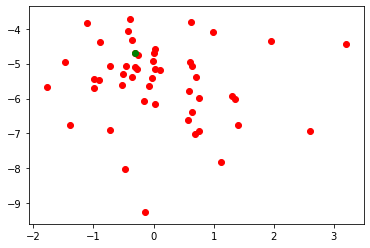

Power Allocated= 2.8523846921179903
CSI= 0.669883670481281
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.368408


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.196233
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.627880

Power Allocated= 0
CSI= 0.0020530364135197265
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.966979545967281
CSI= 0.7255832275245293
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1816175062454941
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4110150286600058
CSI= 0.3408123274657706
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.281626


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.135363
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.802375

Power Allocated= 1.0867070050545893
CSI= 0.3068921040943985
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292713
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.548524
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.140031

Power Allocated= 0
CSI= 0.013381544526533062
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3987528809513243
CSI= 0.5137615360746693
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.004594587219940993
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1665062385096453
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocate

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 2.2544, Accuracy: 1490/10000 (15%)

Power in training Round= 97.99514929302521



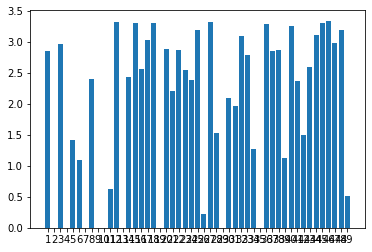

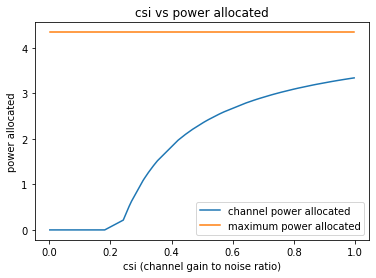

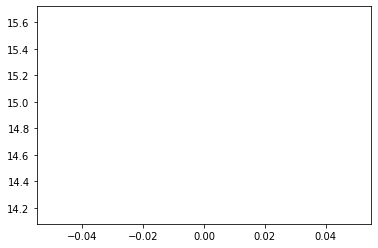

1
Power Allocated= 3.1309415814390835
CSI= 0.5952420449145402
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.8518451425962321
CSI= 0.2525835960606463
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.396621


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.823869
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.238999

Power Allocated= 3.0234685384035873
CSI= 0.559452485389292
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.451662
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.356100
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.588671

Power Allocated= 2.714987663512416
CSI= 0.47711226380146365
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.661311952991089
CSI= 0.46519882893622055
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.434568452707288
CSI= 0.726553053361606
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.203455
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.012730
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.626334

Power Allocated=

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.553547
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.659656

Power Allocated= 3.2405559543266897
CSI= 0.6367907865149833
SNR= 23.641228135642812
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.439077
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.660363
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.516309

Power Allocated= 2.9105892298608795
CSI= 0.5262212900768499
SNR= 23.671158746923165
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.388327
Model client19 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.629330
Model client19 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.542783

Power Allocated= 3.310095899754787
CSI= 0.6662959688215879
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.221281
Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.868876
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.443666

Power Allocated= 0
CSI= 0.129070482172007
SNR

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 2.2544, Accuracy: 1624/10000 (16%)

Power in training Round= 97.99700198279386



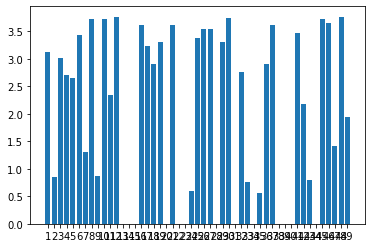

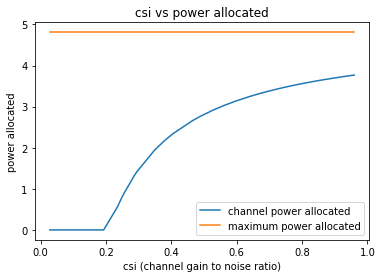

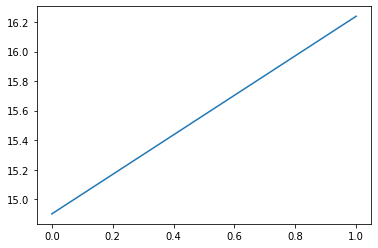

2
Power Allocated= 3.426072864871805
CSI= 0.8615770517832672
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.354780


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.627581
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.330327

Power Allocated= 3.2609239882185594
CSI= 0.7542552211368858
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.266964
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.579634
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.074973

Power Allocated= 3.2383796072172055
CSI= 0.7416441431327476
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.168256
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.203186
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.649532

Power Allocated= 3.216998484776976
CSI= 0.7300673309643197
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.257889
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.154101
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.629632

Power Allocated= 3.006410464610026
CSI= 0.6327813529125861


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.063291
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.673272

Power Allocated= 1.0497822356347477
CSI= 0.2827292363917583
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.433764
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.950177
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.920382

Power Allocated= 2.274090125933444
CSI= 0.43240531272314764
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288819
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.051507
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.935063

Power Allocated= 0
CSI= 0.06573411194781176
SNR= 21.282865161770438
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.969867357876149
CSI= 0.6184797529543391
SNR= 22.970977389425087
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.325008
Model client16 Train 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 2.1937, Accuracy: 4164/10000 (42%)

Power in training Round= 98.00300699101082



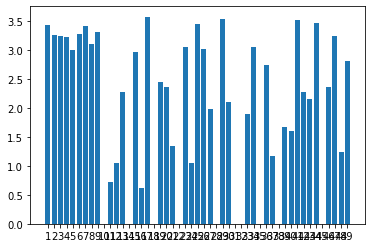

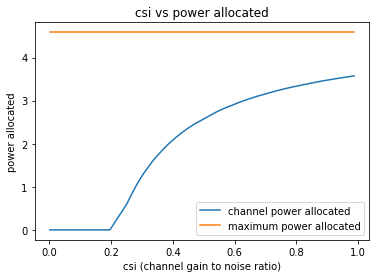

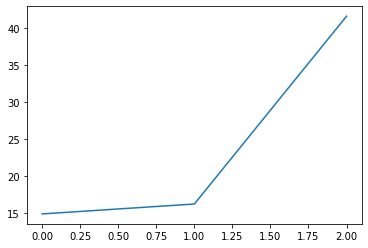

3
Power Allocated= 1.0720006555247492
CSI= 0.3295869175720526
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.243541


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.506374
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.024735

Power Allocated= 2.863051730503483
CSI= 0.8044729102001406
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0913742482716464
CSI= 0.9854863300890887
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.113340
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.476698
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.344277

Power Allocated= 2.55898888160055
CSI= 0.6463652872544485
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.212219
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.169637
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.630528

Power Allocated= 2.957114982007334
CSI= 0.8703321047960755
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.385575
Model client5 Train

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.002508
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.032086

Power Allocated= 2.6772508087808813
CSI= 0.6998631062110705
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.001542
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233205
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.685670

Power Allocated= 0
CSI= 0.05327295439345081
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5718550891743845
CSI= 0.6517857131977812
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.204031
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.721919
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.965581

Power Allocated= 2.695826044147113
CSI= 0.7090812488993753
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.246117
Model client12 Train Epoch

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 1.7963, Accuracy: 4851/10000 (49%)

Power in training Round= 97.99665675903933



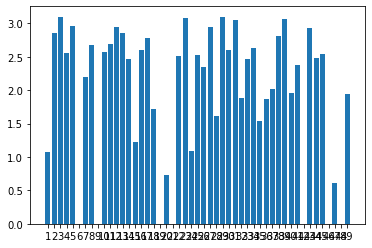

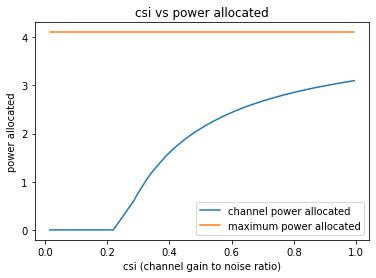

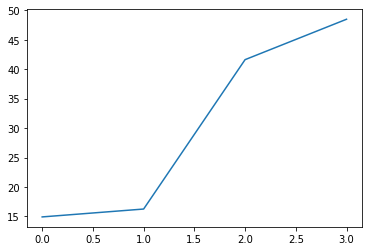

4
Power Allocated= 3.66864184478902
CSI= 0.9343650902498095
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.812077


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.939408
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.574406

Power Allocated= 2.677406978069483
CSI= 0.48508830517069745
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7046703687790075
CSI= 0.9669151227930897
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.486472
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.232082
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144076

Power Allocated= 3.5881251107675625
CSI= 0.8689892675567035
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06396143025658674
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.399052372593074
CSI= 0.7463605946024788
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Lo

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.465225
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371859

Power Allocated= 1.9149904934218704
CSI= 0.3541205876897999
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.274101
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.852979
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.600264

Power Allocated= 0
CSI= 0.009801198048098203
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07903655186620462
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.703480518116804
CSI= 0.49130228136768683
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.185911
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.754872
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.756739

Power Allocated= 2.768477794551397
CSI= 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 1.6015, Accuracy: 4841/10000 (48%)

Power in training Round= 98.00152955503654



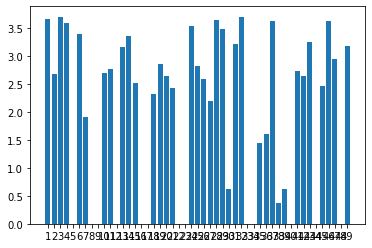

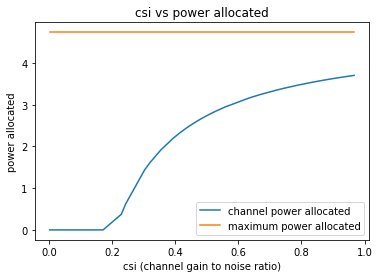

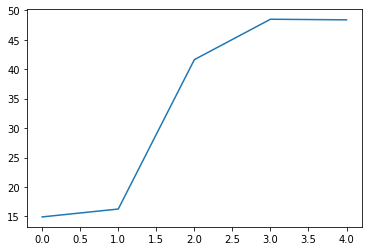

5
Power Allocated= 3.1878330094034504
CSI= 0.7597250194017665
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.797367


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.752680
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.599078

Power Allocated= 2.5540328013715943
CSI= 0.5128031752152449
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.096062391603392
CSI= 0.7102089433637345
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0798408353728686
CSI= 0.7021200330934012
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.414181
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.616417
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.700052

Power Allocated= 2.776351636077604
CSI= 0.5787884138874348
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.172376
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.329888
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.974065

Power Allocated

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.625167
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.611564

Power Allocated= 3.4738122356539174
CSI= 0.9706038132486324
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.834510
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144952
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128161

Power Allocated= 3.360444405562532
CSI= 0.8743900834089797
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.127659
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.715059
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.610998

Power Allocated= 0
CSI= 0.010656913594560113
SNR= 21.10269532158381
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8137214340786065
CSI= 0.3716950784463485
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.412380
Model client15 Train

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 1.3027, Accuracy: 7066/10000 (71%)

Power in training Round= 97.99682832269181



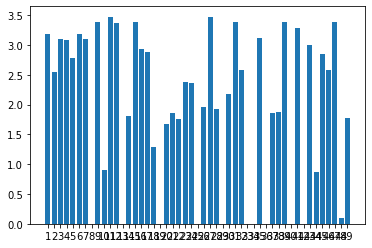

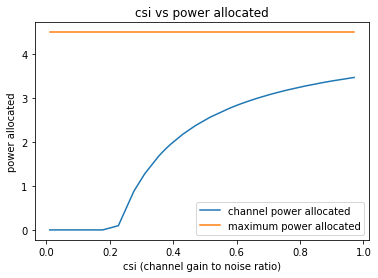

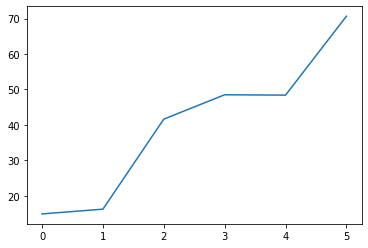

6
Power Allocated= 3.139306982514186
CSI= 0.6331298565105156
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.526283


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.398941
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449598

Power Allocated= 0
CSI= 0.19862770531455443
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13748054701824608
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.040549212652051136
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.646688515068395
CSI= 0.9327720566704288
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.679351


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.855855
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.681257

Power Allocated= 2.7592942537214697
CSI= 0.5103427221741007
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.045462833745704034
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.536470005537943
CSI= 0.8458148887626592
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.420508
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.357224
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.253752

Power Allocated= 0
CSI= 0.1178343586676055
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.684691713935481
CSI= 0.9670524430302354
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.367270
Mo

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 1.1286, Accuracy: 6232/10000 (62%)

Power in training Round= 98.00610323789344



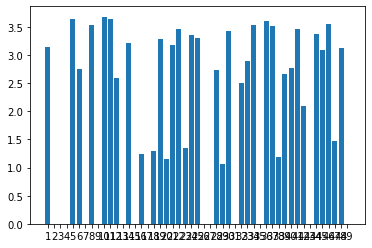

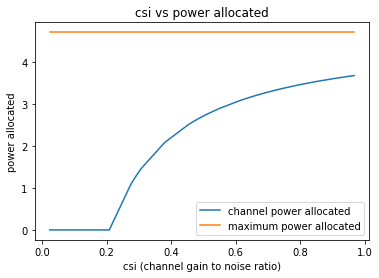

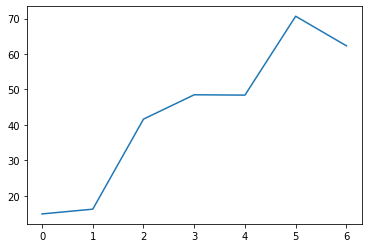

7
Power Allocated= 0
CSI= 0.08495227685234386
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14321656062544508
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6997017160829748
CSI= 0.3627622688672848
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.413858


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083237
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122124

Power Allocated= 0
CSI= 0.12552123817489902
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9777699956736132
CSI= 0.6763346495155003
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.053450604612202
CSI= 0.4161677195240734
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.146438
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.289806
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.352323

Power Allocated= 2.8335454215284073
CSI= 0.6162255018347071
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.464047
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.431321
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.400913

Power Allocated= 0
CSI= 0.1326

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 1.1057, Accuracy: 7819/10000 (78%)

Power in training Round= 97.99835799529293



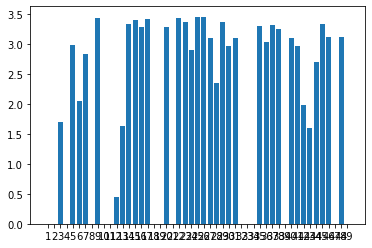

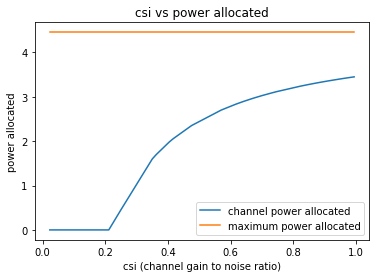

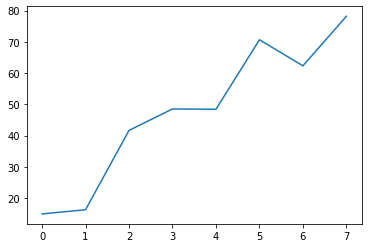

8
Power Allocated= 3.246809319130552
CSI= 0.7020787451286135
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.695760


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236940
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175551

Power Allocated= 0.2909247647540578
CSI= 0.2282987117051476
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.485190
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.460154
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.352685

Power Allocated= 0
CSI= 0.027671758574615457
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.9390619831818139
CSI= 0.3660202885920866
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.054041


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174419
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129462

Power Allocated= 2.678466349236104
CSI= 0.5018355583101912
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.374941
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.706788
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.354305

Power Allocated= 3.5214958107497347
CSI= 0.8698260435421544
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.15643241286030374
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3705013339063052
CSI= 0.768846560226147
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.800327000750597
CSI= 0.5345238331247701
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.7687, Accuracy: 8093/10000 (81%)

Power in training Round= 98.00649788808862



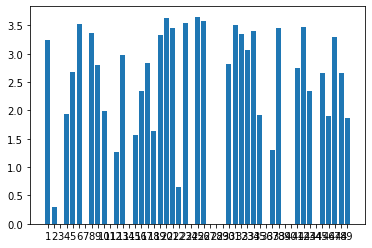

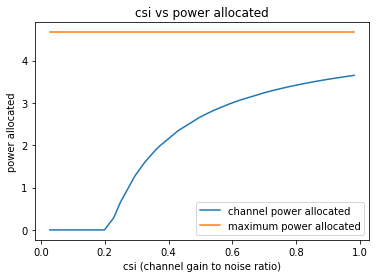

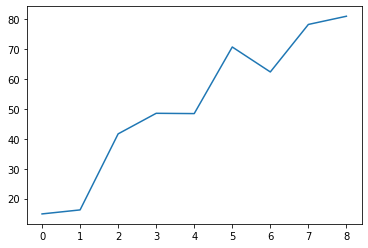

9
Power Allocated= 2.92848825977493
CSI= 0.7368634306174618
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.370596221650609
CSI= 0.5221944062409738
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.924801


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203010
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123843

Power Allocated= 0
CSI= 0.10357468258227409
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2345174362524514
CSI= 0.9514074324446741
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.301807621705029
CSI= 0.5040870829901749
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.152008


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345857
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219468

Power Allocated= 0
CSI= 0.2187699679836973
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.182517720890252
CSI= 0.9065573948877639
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.277680
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201910
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086677

Power Allocated= 3.015471158161282
CSI= 0.7873267588780822
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.182310
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039967
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.303712

Power Allocated= 1.9123991845226986
CSI= 0.4213732912048198
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.112819
Model client9 Train Epoch: 2 [0/12

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5404, Accuracy: 8303/10000 (83%)

Power in training Round= 98.0042930883924



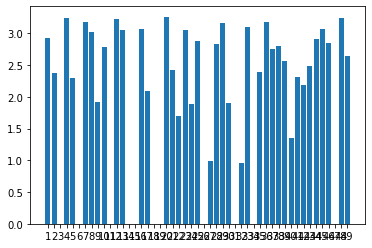

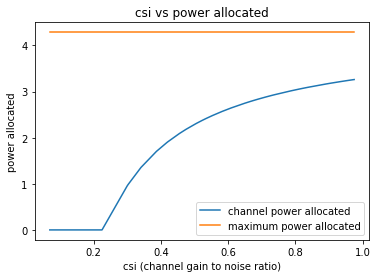

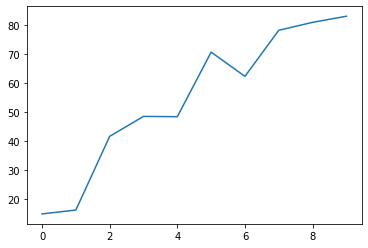

10
Power Allocated= 2.8807464806225225
CSI= 0.6147791071660373
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2216587966808232
CSI= 0.777793571115775
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.689839


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127121
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014579

Power Allocated= 3.4834510303218265
CSI= 0.9766617444285843
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.574823314761809
CSI= 0.5174580887571104
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.612311
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226627
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.263192

Power Allocated= 3.2212171524078146
CSI= 0.7775264844888424
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.21326393794651
CSI= 0.43590401201679185
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.678494
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335695
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151045

Power Allocated

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162828
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.131245

Power Allocated= 0
CSI= 0.1025546055389297
SNR= 23.641228135642812
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.448817062303913
CSI= 0.9447064154417333
SNR= 23.671158746923165
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970567
Model client19 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134281
Model client19 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.363246

Power Allocated= 3.445125652189348
CSI= 0.9414233907645826
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714502
Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303547
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.491486

Power Allocated= 3.355140974651764
CSI= 0.8679003574035901
SNR= 24.10390762049326
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.148767
Model client21 Train Ep

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5155, Accuracy: 9074/10000 (91%)

Power in training Round= 98.0056670452735



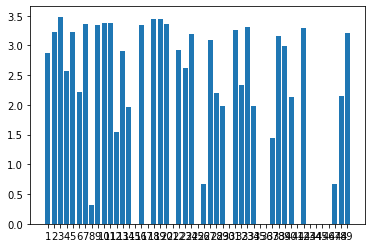

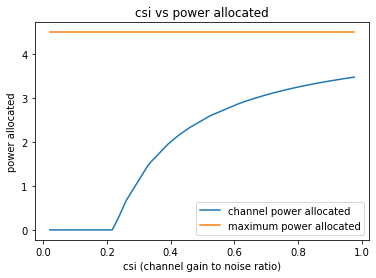

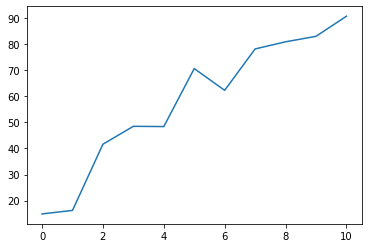

11
Power Allocated= 2.7019710169025015
CSI= 0.592065910289284
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1276654868396836
CSI= 0.4418314191850823
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.749785


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171778
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402898

Power Allocated= 0.4995453700515231
CSI= 0.2569751542712133
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586476
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.279845
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151594

Power Allocated= 3.295306356598358
CSI= 0.9126870581946103
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.657747962063948
CSI= 0.5769594034500334
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803083
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.331346
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.737373

Power Allocated= 0
CSI= 0.025260925333345896
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.99651345678

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081080
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093467

Power Allocated= 1.7822616875655468
CSI= 0.3833311554089972
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.550155
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100781
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.899931

Power Allocated= 2.9454632363644184
CSI= 0.69179787325644
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.892073
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198716
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055892

Power Allocated= 3.230281770776446
CSI= 0.8615561981203921
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.882281
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150319
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.385368

Power Allocated= 1.7851263009234608
CSI= 0.38375255237840

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3842, Accuracy: 8899/10000 (89%)

Power in training Round= 98.00534547135524



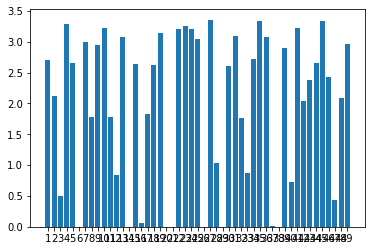

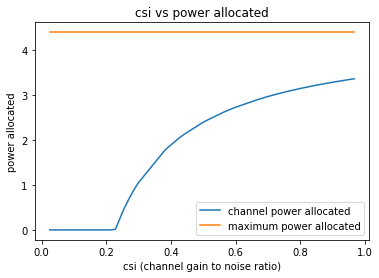

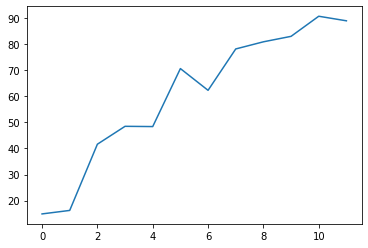

12
Power Allocated= 0
CSI= 0.06800644338391915
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3773301439626167
CSI= 0.7871698306136149
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.705968


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035808
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229196

Power Allocated= 2.7750353307075315
CSI= 0.5339972831985939
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275749
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068279
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046240

Power Allocated= 0
CSI= 0.1931633464913587
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4137044050193746
CSI= 0.3092146303835702
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.823826
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263466
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374945

Power Allocated= 0
CSI= 0.049993081068512635
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3892494169903564
CSI= 0.79

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5255, Accuracy: 8302/10000 (83%)

Power in training Round= 97.99335630894528



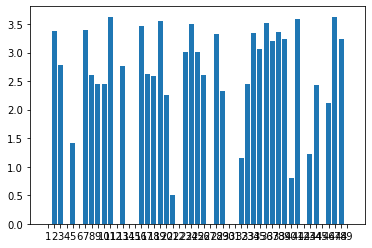

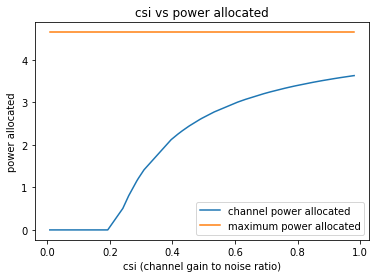

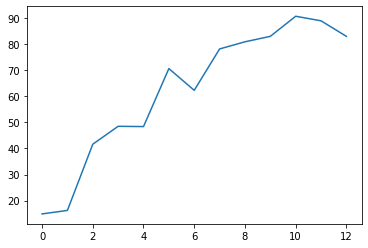

13
Power Allocated= 3.3133581668175047
CSI= 0.7229395615983831
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1885931862295083
CSI= 0.6631271258909756
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2184395658437523
CSI= 0.6765167066173012
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455487


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058041
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061882

Power Allocated= 3.676876860808433
CSI= 0.9806586642794538
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.2657044949468461
CSI= 0.2914691214258347
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.551479
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.364599
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.280285

Power Allocated= 0
CSI= 0.030184563232503625
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2262692374066515
CSI= 0.6801192326424635
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.176737


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134852
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133022

Power Allocated= 3.67932354858013
CSI= 0.9830172820930585
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.169197
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003048
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286550

Power Allocated= 3.3027703312849805
CSI= 0.7174479529700281
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.913460
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123368
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151504

Power Allocated= 2.838440138245853
CSI= 0.5381669266280007
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.385374
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153881
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.127417

Power Allocated= 3.3429554249903704
CSI= 0.73874654268354

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6372, Accuracy: 8374/10000 (84%)

Power in training Round= 97.99390696503391



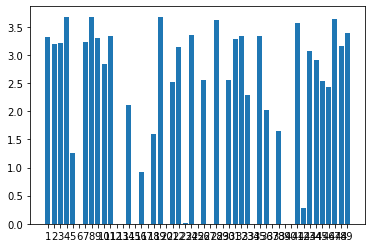

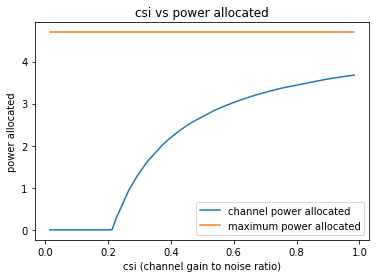

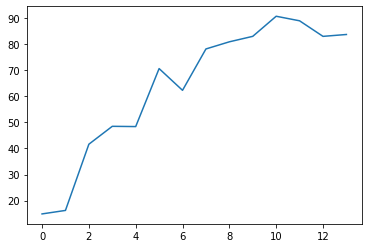

14
Power Allocated= 2.0767011540727096
CSI= 0.36984018360412063
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.826106


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069488
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092838

Power Allocated= 2.2207788756689486
CSI= 0.390656606452193
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.245177387968287
CSI= 0.6512984680495382
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13153586455074096
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5199973969025202
CSI= 0.30669443163980414
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.152633


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.415894
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.537722

Power Allocated= 3.086592920903945
CSI= 0.5903261475622603
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.565481
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147035
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.309807

Power Allocated= 2.7152932646957884
CSI= 0.48419620115413553
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877294
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058302
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207765

Power Allocated= 3.280942900749267
CSI= 0.666831660542973
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603356
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057838
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061115

Power Allocated= 2.7839463183010054
CSI= 0.500845066344003
S

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5253, Accuracy: 9017/10000 (90%)

Power in training Round= 97.9981842392955



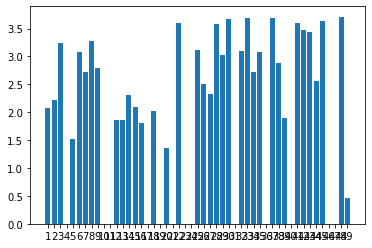

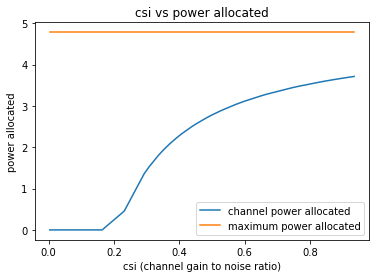

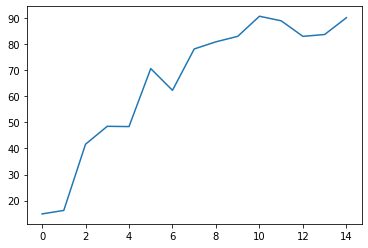

15
Power Allocated= 3.432340509811051
CSI= 0.6923860543524957
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.869658


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.461185
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.487136

Power Allocated= 0.5477330963833866
CSI= 0.23100618730677958
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760697
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063389
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.485083

Power Allocated= 2.7560919096595224
CSI= 0.47158031445104387
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4556584826355685
CSI= 0.703748094931718
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.834847
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060133
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148783

Power Allocated= 2.00232387263358
CSI= 0.3479110856877422
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747069
Model client5 Tr

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.316570
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114481

Power Allocated= 1.2732201065605695
CSI= 0.27751557411923766
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.032856
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062882
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288716

Power Allocated= 2.878403594657737
CSI= 0.5004459268512483
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.016085
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083899
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011645

Power Allocated= 0
CSI= 0.15606866018830345
SNR= 20.21487098457923
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.06896570784285938
CSI= 0.20800158083071896
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.779445
Model client14 Train

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3996, Accuracy: 8997/10000 (90%)

Power in training Round= 97.99696280984656



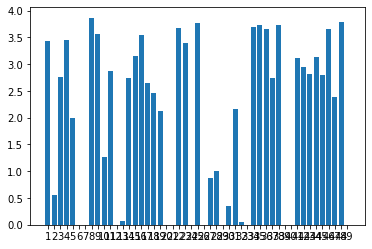

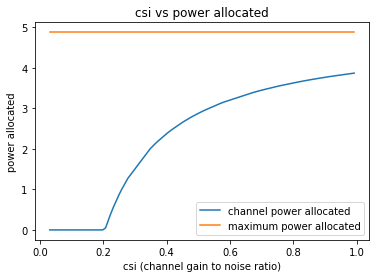

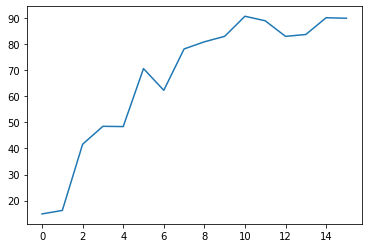

16
Power Allocated= 3.1765701584190023
CSI= 0.7682201567454829
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0560991460992115
CSI= 0.7031452841893382
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.808504


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125204
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140061

Power Allocated= 1.1802778653418153
CSI= 0.3032138415837926
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.500407
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114163
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316677

Power Allocated= 3.227567170137228
CSI= 0.7995438313247397
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3691520804050183
CSI= 0.9016089807772687
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.844252
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335632
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.319782

Power Allocated= 2.69456236737825
CSI= 0.5606267443356641
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated=

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client26 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072180
Model client26 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.293141

Power Allocated= 0.8518203322178892
CSI= 0.2757510072516013
SNR= 26.108203962774297
Client: client27
Model client27 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.880763
Model client27 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282897
Model client27 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034571

Power Allocated= 0
CSI= 0.15015040482103126
SNR= 26.42134042230769
Client: client28
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06263440078584992
SNR= 26.5060369016718
Client: client29
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2132659313349636
CSI= 0.7905048297266803
SNR= 27.378693334951635
Client: client30
Model client30 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.883327
Model client30 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012857
Model client30 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007126

Power Allocated= 3.4168479579778306


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3665, Accuracy: 8552/10000 (86%)

Power in training Round= 97.99743784147923



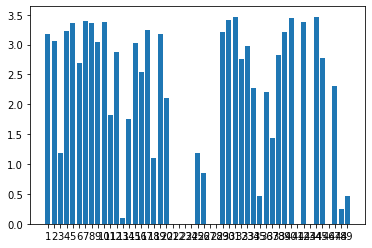

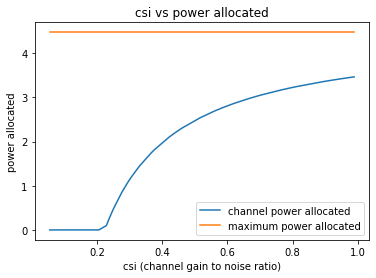

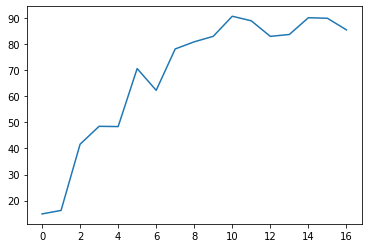

17
Power Allocated= 2.4470550841499423
CSI= 0.48834540159989503
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.039436065295631
CSI= 0.6871199448637058
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.08309746079089386
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.991270799439653
CSI= 0.6651079866564753
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.544297


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272719
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.460277

Power Allocated= 3.3082857384286943
CSI= 0.8428147820760403
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750407
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367186
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.413127

Power Allocated= 2.8405733290831967
CSI= 0.6045171751207868
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639693
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014540
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011446

Power Allocated= 3.070274715960095
CSI= 0.7019951174684397
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.866035
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128383
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142381

Power Allocated= 3.330965623178683
CSI= 0.8592390875035513


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6208, Accuracy: 8019/10000 (80%)

Power in training Round= 97.9927084140873



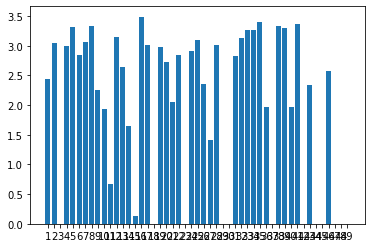

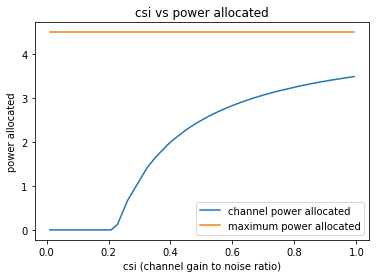

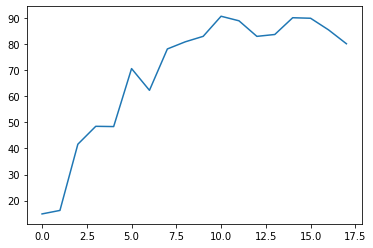

18
Power Allocated= 2.462055184770758
CSI= 0.5935023195572595
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1315240330585206
CSI= 0.4961684549815326
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.693883


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123887
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082738

Power Allocated= 3.0693946124266915
CSI= 0.9280105525042295
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.00028420585781996355
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4805348617460443
CSI= 0.6000838782005128
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.550512


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.305540
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076603

Power Allocated= 2.6517042406073985
CSI= 0.6687780769140317
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.727953
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073478
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009723

Power Allocated= 2.3485312549741204
CSI= 0.556038286061467
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.881040
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150704
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226576

Power Allocated= 3.0365790698721256
CSI= 0.9005848880112138
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.988362
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008241
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066647

Power Allocated= 3.0264845657658577
CSI= 0.8924714675176192

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3170, Accuracy: 8915/10000 (89%)

Power in training Round= 98.00416030918467



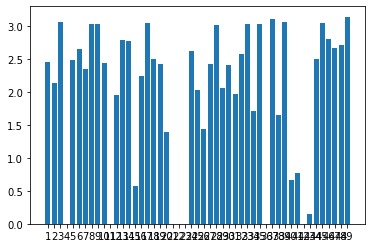

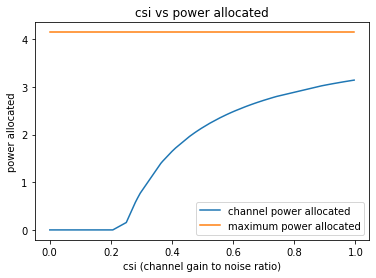

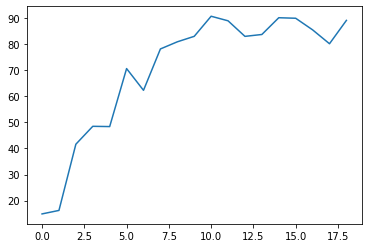

19
Power Allocated= 3.319591769469729
CSI= 0.9899399329251288
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2236899056049646
CSI= 0.9041066804426708
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.647928


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307039
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098129

Power Allocated= 3.227912235863358
CSI= 0.907571276608369
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.241533
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026098
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063845

Power Allocated= 3.2533351227466567
CSI= 0.9290063154129896
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373233
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115107
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.340200

Power Allocated= 2.9461706443533338
CSI= 0.7227608986099501
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.774780
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137000
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.393060

Power Allocated= 0
CSI= 0.05862490286652622
SNR= 17.43751012

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072129
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484917

Power Allocated= 1.3284128448796224
CSI= 0.33318437491896113
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.753358
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003684
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087178

Power Allocated= 0
CSI= 0.22014037960173283
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.319950329739485
CSI= 0.9902914399707569
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.729329
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038770
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.488165

Power Allocated= 0
CSI= 0.17531842876957493
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1271570999759715
CSI=

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5377, Accuracy: 8421/10000 (84%)

Power in training Round= 97.99335707509611



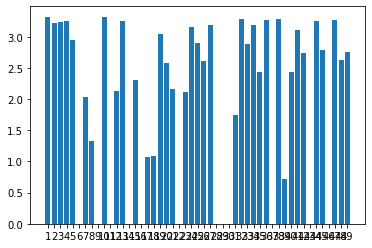

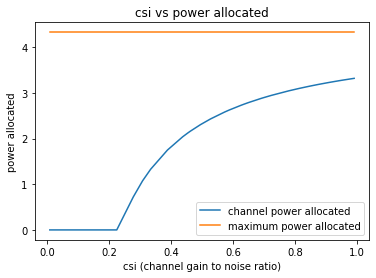

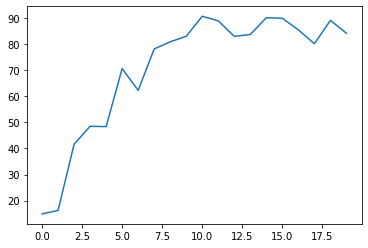

20
Power Allocated= 2.7853691613765377
CSI= 0.5148492395789864
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682688


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159419
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.366052

Power Allocated= 3.546715892890946
CSI= 0.846761967403049
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.3081963704774573
CSI= 0.2924413598704261
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.336208
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055436
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015646

Power Allocated= 0
CSI= 0.015245800199953585
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5920207549310827
CSI= 0.880541689969147
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.006389351920249697
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

P

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088513
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022727

Power Allocated= 0
CSI= 0.11870398014864447
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.48138558191396186
CSI= 0.23549915466184446
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.475851
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054197
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.492979

Power Allocated= 2.853611491245212
CSI= 0.5335969062942416
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.863211
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087705
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020334

Power Allocated= 0
CSI= 0.11676607557948837
SNR= 20.21487098457923
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3506095089398835


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6025, Accuracy: 8228/10000 (82%)

Power in training Round= 98.00068457013785



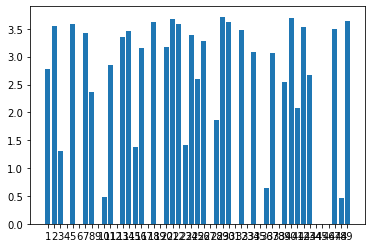

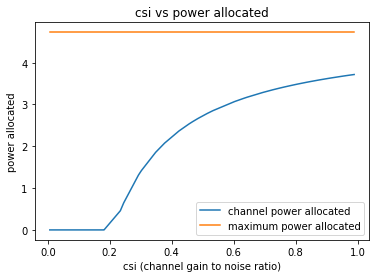

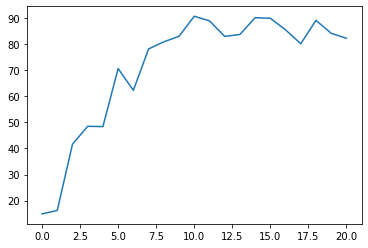

21
Power Allocated= 1.6997131781373618
CSI= 0.36849527205503807
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.745948261742252
CSI= 0.5996987327404353
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.15267710038227045
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3790281557911124
CSI= 0.9667215329750899
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.524008801665996
CSI= 0.5292563935270744
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.631521


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315972
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.382376

Power Allocated= 0
CSI= 0.21714838445834572
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.114477239673506
CSI= 0.7698377788344483
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.0325914536797032
CSI= 0.29578266434198075
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.315847
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013966
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001081

Power Allocated= 3.0759035489332183
CSI= 0.7476363551135895
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.919190
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192855
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.242997

Power Allocated= 3.2597572951

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5279, Accuracy: 8309/10000 (83%)

Power in training Round= 98.00428262165947



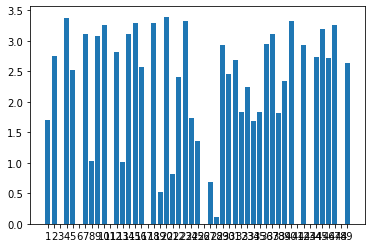

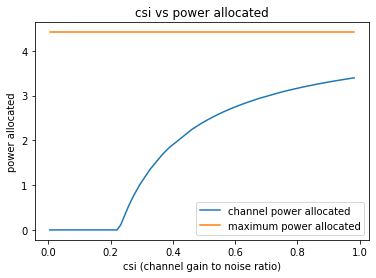

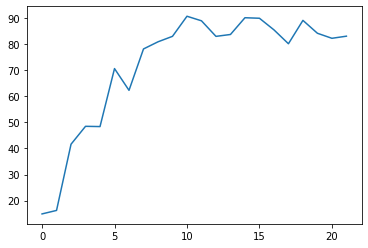

22
Power Allocated= 2.9209955336826905
CSI= 0.5710929687824813
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8834155827252195
CSI= 0.5590938936900834
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.930458541072094
CSI= 0.574196071914093
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.029712597470318403
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.12009743651288474
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.196951312921172
CSI= 0.6779327300119868
SNR= 17.437510126097536
Client: client6


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.182476
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011777
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028755

Power Allocated= 3.5448230512648298
CSI= 0.8871533256049966
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1924042365234566
CSI= 0.6758493487561736
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.170258
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002599
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129303

Power Allocated= 0.05552053348802044
CSI= 0.21661415926964445
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.978640
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263952
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203307

Power Allocated= 3.6464215705210608
CSI= 0.9750367671878486
SNR= 18.914892373117546
Client: client11
Model client

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5851, Accuracy: 8793/10000 (88%)

Power in training Round= 98.00725998254954



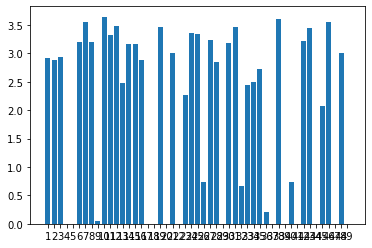

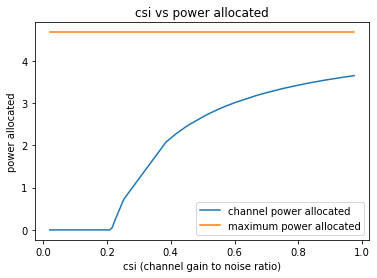

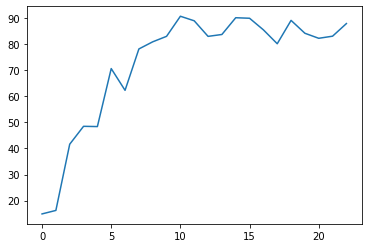

23
Power Allocated= 3.065982348847152
CSI= 0.949080117140122
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7278245206086096
CSI= 0.7184890518451629
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4683527067651716
CSI= 0.37717609820787845
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.929225


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030320
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008508

Power Allocated= 0
CSI= 0.13057638776350233
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.972099898661874
CSI= 0.8714336637477006
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.779172


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.397824
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250011

Power Allocated= 1.4092339071861097
CSI= 0.3689491959276012
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.677841
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069934
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336924

Power Allocated= 2.922653409235182
CSI= 0.83543531137689
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.122146
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100185
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321750

Power Allocated= 2.4075229232357294
CSI= 0.584074193836315
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.120665
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071018
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002893

Power Allocated= 2.7837251442668625
CSI= 0.7485539627942754
SN

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2237, Accuracy: 9338/10000 (93%)

Power in training Round= 98.00453658582808



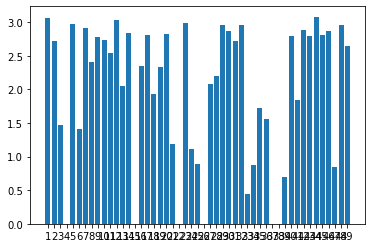

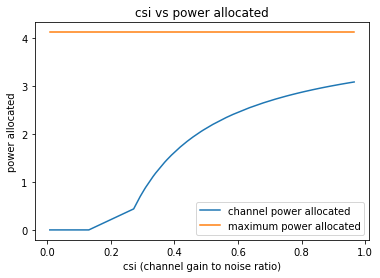

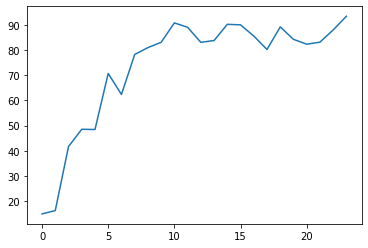

24
Power Allocated= 3.301636379422689
CSI= 0.9527484237608491
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9187239329552686
CSI= 0.69807664117783
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.5985032338515786
CSI= 0.26647280488469993
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.873476


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161805
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321022

Power Allocated= 2.660970495621865
CSI= 0.5916246410867033
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502303
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317222
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286550

Power Allocated= 1.156688498416389
CSI= 0.31303383027917586
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703179
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317912
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224483

Power Allocated= 3.182055423282595
CSI= 0.8553032402379414
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231777
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027231
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008273

Power Allocated= 3.327497459513204
CSI= 0.976816301512083
SN

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087860
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.433123

Power Allocated= 3.0746868249857435
CSI= 0.7833647337968503
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472866
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003540
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203221

Power Allocated= 0
CSI= 0.19453062204190286
SNR= 20.21487098457923
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14206681292623202
SNR= 21.10269532158381
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.3691185722702133
CSI= 0.3353327182019813
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303904
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022962
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048205

Power Allocated= 1.7314485464597418

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2470, Accuracy: 9201/10000 (92%)

Power in training Round= 98.006966039695



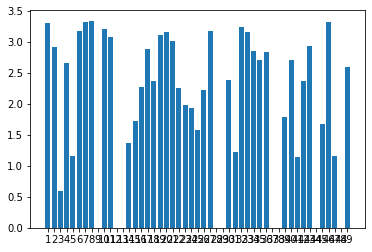

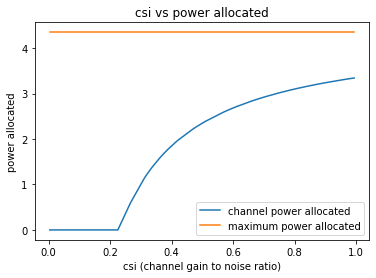

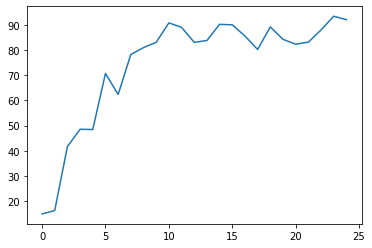

25
Power Allocated= 0.7127320752451967
CSI= 0.2926449402499388
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.604485


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400164
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.625017

Power Allocated= 1.8181437294826255
CSI= 0.43258236116809046
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.956153
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063785
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262035

Power Allocated= 2.484193202286054
CSI= 0.6076629810283269
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.594346
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047195
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.878254

Power Allocated= 3.0487922970938017
CSI= 0.9250266433452704
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434795
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191970
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390328

Power Allocated= 2.8913979385062856
CSI= 0.807464654463796

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174537
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003075

Power Allocated= 2.7608556168251708
CSI= 0.7304673274755905
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327665
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001606
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.7170766581751837
CSI= 0.4144621456480384
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.529533
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276711
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288675

Power Allocated= 2.7978397543437064
CSI= 0.7507493497559753
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.514680
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092691
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200252

Power Allocated= 3.050652094038612
CSI= 0.926620766245

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2290, Accuracy: 9305/10000 (93%)

Power in training Round= 98.00520513245368



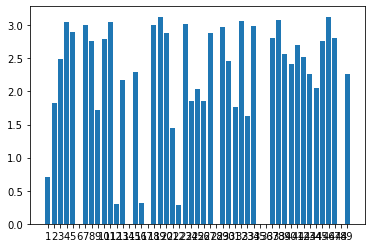

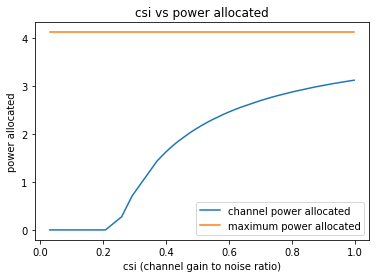

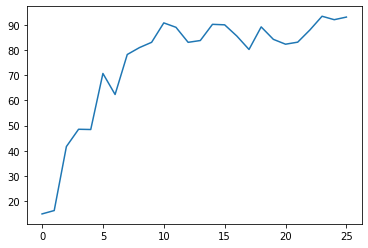

26
Power Allocated= 1.6675961552044565
CSI= 0.3515393224706663
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9422110795904333
CSI= 0.2801107063544537
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590715


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011646
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096142

Power Allocated= 0.8384682383152535
CSI= 0.27220069553712056
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340387
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046739
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.244246

Power Allocated= 3.2959093545125935
CSI= 0.8221528873566464
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417651
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023377
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043970

Power Allocated= 2.6868374141812064
CSI= 0.5478279180515527
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588145
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088669
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.171475

Power Allocated= 1.6568592609175425
CSI= 0.35021744753779

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016014
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056508

Power Allocated= 1.8948898006526682
CSI= 0.38206753236039215
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623656
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000002
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 2.495937019188136
CSI= 0.49596012725720107
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411483
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150398
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052146

Power Allocated= 0
CSI= 0.17885449512478824
SNR= 22.970977389425087
Client: client16
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5635738884080537
CSI= 0.33913776091309555
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.521179
Model client17 Tr

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.7117, Accuracy: 7738/10000 (77%)

Power in training Round= 98.0054956862177



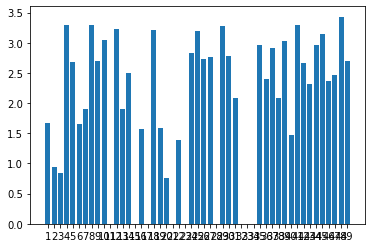

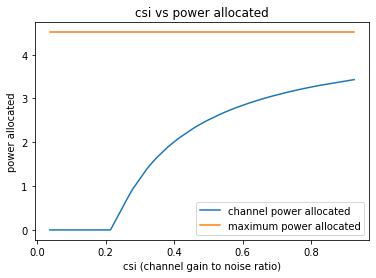

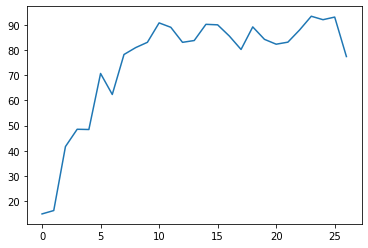

27
Power Allocated= 1.1184988199143784
CSI= 0.2962896796872153
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9212930512262316
CSI= 0.6360185694735233
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.558774


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050377
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156357

Power Allocated= 3.455598283197155
CSI= 0.9634134997700011
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389829
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038624
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217903

Power Allocated= 3.4861231038951916
CSI= 0.9926040230380442
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.04028297757462829
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8013948598449456
CSI= 0.37144628116106415
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.952243


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022938
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012708

Power Allocated= 0.3825329268953279
CSI= 0.24324737609417058
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.133387
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018326
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028899

Power Allocated= 0
CSI= 0.17636384581995468
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3417759945732484
CSI= 0.4647275951024342
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.070415
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129774
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313283

Power Allocated= 0
CSI= 0.05013703705250605
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21351991253172053

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5010, Accuracy: 8731/10000 (87%)

Power in training Round= 97.99749274252535



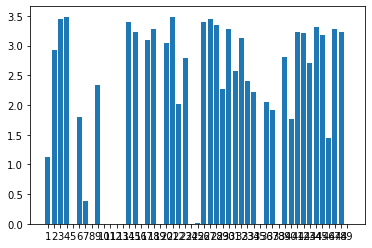

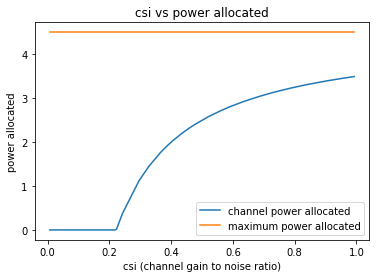

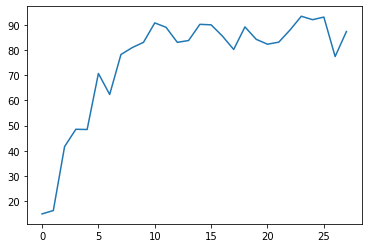

28
Power Allocated= 0.6714255551440513
CSI= 0.2621859959675561
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.450788695551998
CSI= 0.4914673644483891
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2633659644131545
CSI= 0.8182329583107961
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.734023587869551
CSI= 0.3634396821034066
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4167341612945012
CSI= 0.3258626458947894
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.664080


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.568026
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194879

Power Allocated= 0.7771530669887814
CSI= 0.26966107457055644
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389691
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043734
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026662

Power Allocated= 2.0115123503132306
CSI= 0.40420380909182674
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412264
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070448
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140128

Power Allocated= 3.2583862064627507
CSI= 0.8149125140863457
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467514
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129237
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000165

Power Allocated= 3.3021276623455194
CSI= 0.8450341447069

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client19 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228956
Model client19 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086104

Power Allocated= 3.2844008553252766
CSI= 0.8325625597015357
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.198496
Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.316404
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117707

Power Allocated= 0
CSI= 0.17294580727249698
SNR= 24.10390762049326
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.20424600603988918
SNR= 24.66660942172393
Client: client22
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0441163319284
CSI= 0.6937721286796062
SNR= 25.303597920016873
Client: client23
Model client23 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.759582
Model client23 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057243
Model client23 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014350

Power Allocated= 1.4332862846826346
CS

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4286, Accuracy: 8663/10000 (87%)

Power in training Round= 97.99347241263744



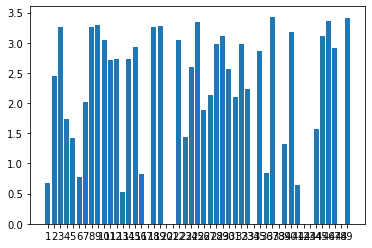

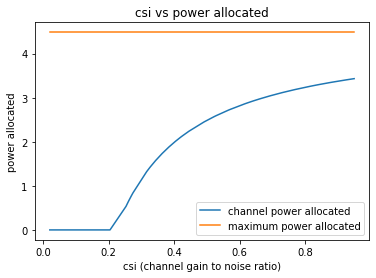

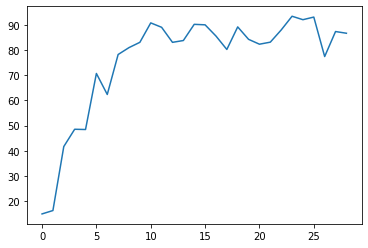

29
Power Allocated= 0
CSI= 0.11085197382123035
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3140762429543305
CSI= 0.4511514023870329
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.517807350712908
CSI= 0.33191498447778367
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403784


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109727
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210216

Power Allocated= 2.883328589570217
CSI= 0.6070545385859801
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.336664
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052348
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185938

Power Allocated= 3.3328290639832505
CSI= 0.8348653287442305
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.285413
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142010
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194453

Power Allocated= 0
CSI= 0.2001443876159984
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.05191749222609021
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0991204290608927
CSI= 0.6985

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4043, Accuracy: 8545/10000 (85%)

Power in training Round= 98.00302111040247



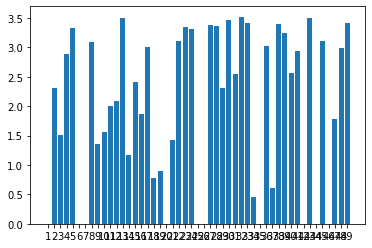

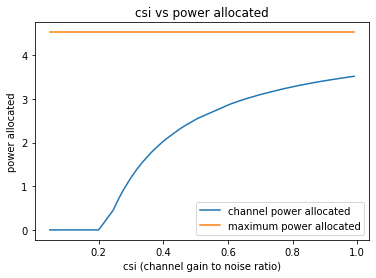

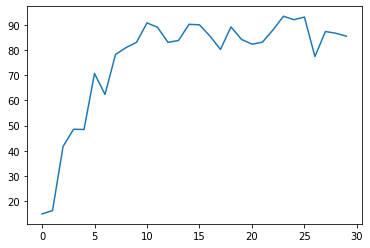

30
Power Allocated= 2.7140030342913857
CSI= 0.5674490659493736
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.594932165322382
CSI= 0.34706031216796607
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633812


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101245
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137488

Power Allocated= 0
CSI= 0.03369144266537183
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.43422644908609165
CSI= 0.24739925923163264
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.890901


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107750
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086026

Power Allocated= 2.853010290506348
CSI= 0.6160421890227972
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.021547
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069305
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201744

Power Allocated= 0.2592886675235775
CSI= 0.2371361313536312
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609395
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.202889
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041680

Power Allocated= 3.3480123760401868
CSI= 0.8863178874688327
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.546769
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124406
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058257

Power Allocated= 2.8206547037334073
CSI= 0.6040029565637245

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3221, Accuracy: 8887/10000 (89%)

Power in training Round= 98.00531490774121



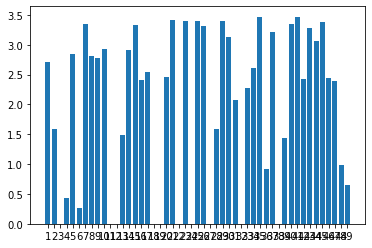

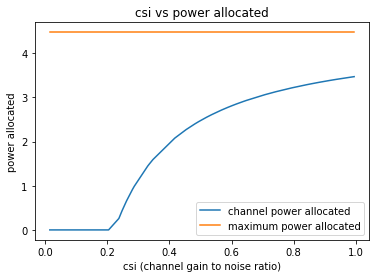

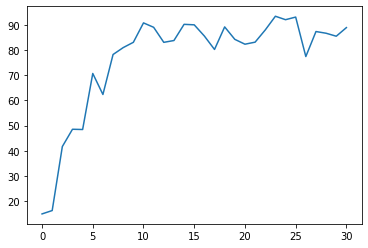

31
Power Allocated= 2.136971965844966
CSI= 0.4308589272066645
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4888757100785623
CSI= 0.5078612990688668
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2117383459043627
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9362405207411721
CSI= 0.28395564776072846
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.681151


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150031
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022944

Power Allocated= 0.8457235670694563
CSI= 0.2768400824310041
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.846492
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.350077
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.481685

Power Allocated= 3.184287521351097
CSI= 0.7851575452624585
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.332393857583289
CSI= 0.8884755278429063
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3997573130755896
CSI= 0.4858708872365526
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231274
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000080
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3061, Accuracy: 9268/10000 (93%)

Power in training Round= 97.9974803217798



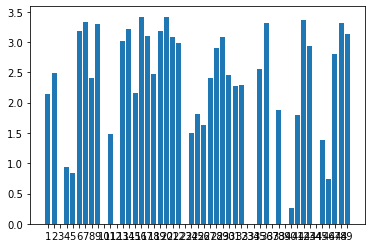

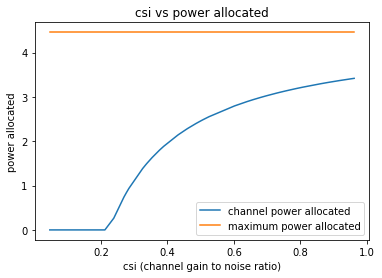

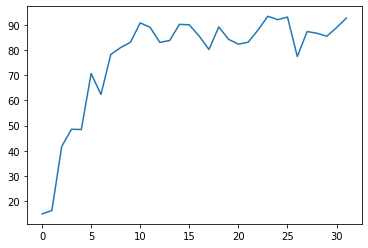

32
Power Allocated= 2.753527103291746
CSI= 0.6131585992289342
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632013


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087437
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109082

Power Allocated= 0
CSI= 0.0810777838728235
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.03325443523168181
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.045236631895273716
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.709022426151341
CSI= 0.5968709312905515
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494488


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197548
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323373

Power Allocated= 3.1997682690570226
CSI= 0.8441253008842484
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2453047954940484
CSI= 0.8778693102853298
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874538
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050468
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211907

Power Allocated= 3.1321049385519775
CSI= 0.7985169442098886
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366655
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243393
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004029

Power Allocated= 0
CSI= 0.17593960223408778
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1624076016

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3630, Accuracy: 8894/10000 (89%)

Power in training Round= 97.99960029114663



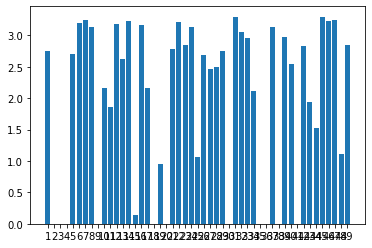

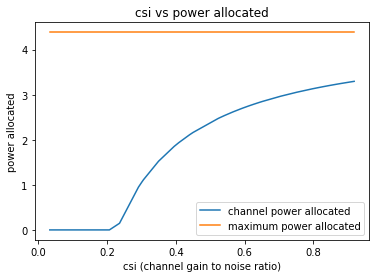

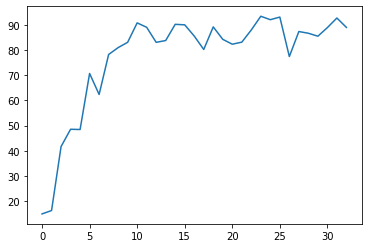

33
Power Allocated= 3.329883489942556
CSI= 0.7940430010979778
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.22988078333385342
CSI= 0.22939039971670216
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.360491


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085317
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073097

Power Allocated= 2.242894696065622
CSI= 0.42619089072418725
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451143
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109041
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205346

Power Allocated= 3.4292315261815265
CSI= 0.8620469663929408
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.430897
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129364
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000507

Power Allocated= 2.8577739759860568
CSI= 0.5775382152176134
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513248
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.295636
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163911

Power Allocated= 0
CSI= 0.1986108022976022
SNR= 17.4375101

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000666

Power Allocated= 1.927311034384549
CSI= 0.3756644431607975
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.176559
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061270
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207242

Power Allocated= 0
CSI= 0.12504687742934806
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13318040530940256
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.08209929513776393
SNR= 20.21487098457923
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.878245139442435
CSI= 0.5844480742010867
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.616770
Model client14 Tr

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.1961, Accuracy: 9479/10000 (95%)

Power in training Round= 97.99731623259188



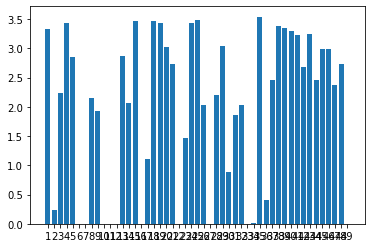

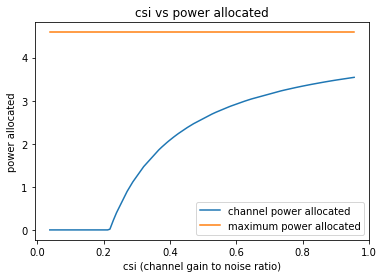

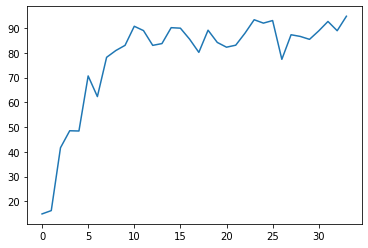

34
Power Allocated= 3.0461799618877388
CSI= 0.6658874560351745
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.578922


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078992
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069620

Power Allocated= 1.5756212717214093
CSI= 0.3364382133065873
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4722881467323483
CSI= 0.9296729463349139
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7619191520351034
CSI= 0.5599053716216847
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.582665
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078971
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006078

Power Allocated= 3.2339126581731
CSI= 0.7610219305260039
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.023545
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107602
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104243

Power Allocated=

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045393
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202429

Power Allocated= 0
CSI= 0.11389240356468633
SNR= 21.10269532158381
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.17980302478723964
SNR= 21.282865161770438
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0315059282249868
CSI= 0.6594438619379573
SNR= 22.970977389425087
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.192751
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002251
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 0
CSI= 0.04149351941083357
SNR= 23.265767002826422
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07339630645620321
SNR= 23.641228135642812
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI=

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3401, Accuracy: 9395/10000 (94%)

Power in training Round= 98.00605643408318



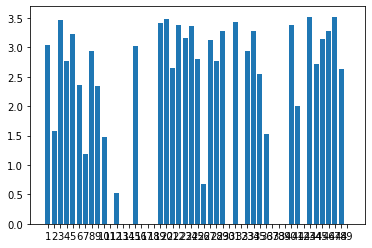

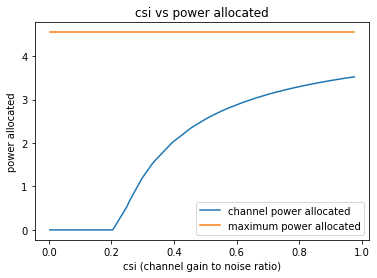

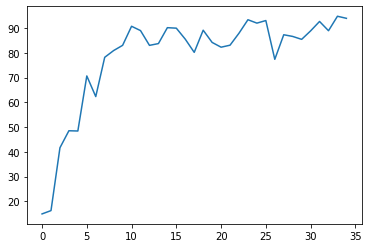

35
Power Allocated= 0
CSI= 0.11622645890243055
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3639174017501965
CSI= 0.6805798154738519
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.723197


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015492
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004492

Power Allocated= 0
CSI= 0.07587833880102413
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.17865846973586175
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5837530169784428
CSI= 0.30773967478020414
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.598488
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155914
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110988

Power Allocated= 3.4963309812627923
CSI= 0.7479869066405219
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.453554435454693
CSI= 0.7247961154631188
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.551965
Mo

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3950, Accuracy: 9116/10000 (91%)

Power in training Round= 98.00496960123421



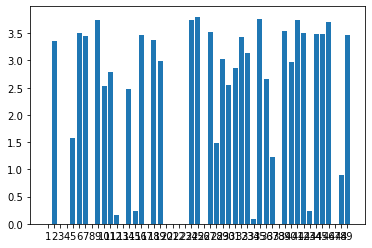

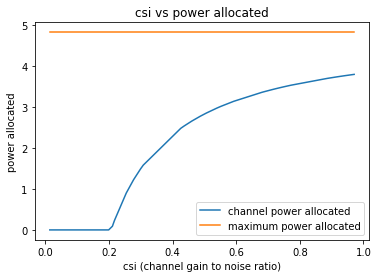

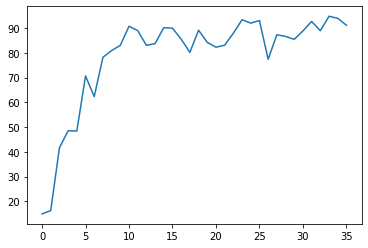

36
Power Allocated= 2.3204549297341717
CSI= 0.4175806670735249
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13461095201373718
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5131538973682375
CSI= 0.83191359425929
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.743126


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114705
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020609

Power Allocated= 3.6278063172070873
CSI= 0.9196286043498078
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.140525
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044092
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036607

Power Allocated= 1.9605584090646961
CSI= 0.3630233951258117
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.833913
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091440
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055056

Power Allocated= 1.437686552678556
CSI= 0.30510918219878524
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.965776
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008532
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044760

Power Allocated= 0
CSI= 0.11167596678791525
SNR= 17.821153

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3203, Accuracy: 9227/10000 (92%)

Power in training Round= 97.99959780989293



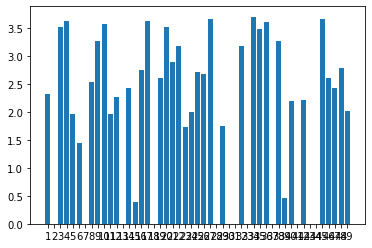

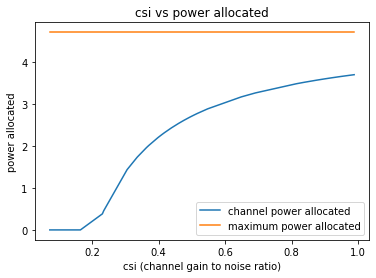

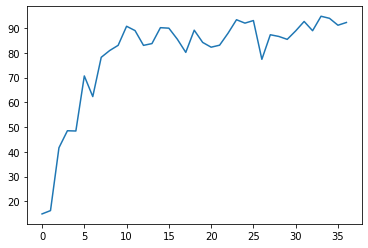

37
Power Allocated= 3.008312833209228
CSI= 0.6982340601084945
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14629774085883207
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.304286615442612
CSI= 0.880118434168354
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3738715384632636
CSI= 0.4838805367358312
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020164


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052590
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040144

Power Allocated= 1.5047657974184467
CSI= 0.34063060159263425
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.644057
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058071
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105175

Power Allocated= 3.187962986634883
CSI= 0.7983812984807861
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.718147
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044309
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004229

Power Allocated= 2.1027764164088034
CSI= 0.42776705796958114
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.934030
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077953
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030230

Power Allocated= 0
CSI= 0.15466008763455752
SNR= 18.24013

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3539, Accuracy: 9021/10000 (90%)

Power in training Round= 97.99611413544132



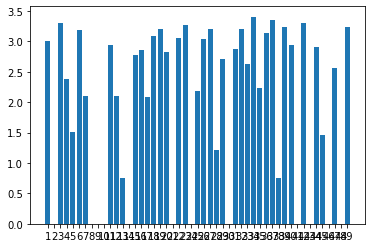

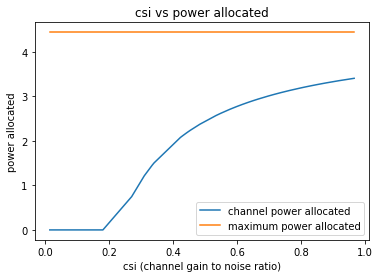

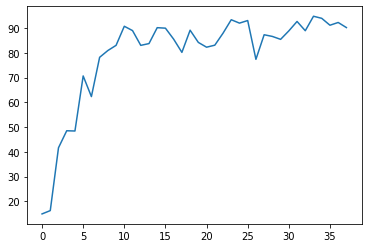

38
Power Allocated= 3.085231277470257
CSI= 0.6991751182592804
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1651514050462246
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.406049160303473
CSI= 0.9013564806014945
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4626324951303733
CSI= 0.9497978377342972
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.767409


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027822
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237497

Power Allocated= 0
CSI= 0.20474262619579497
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.320479888121209
CSI= 0.8368143162138921
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.097458
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013419
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.9253193310027084
CSI= 0.38607522513615056
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.607224
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.382859
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000059

Power Allocated= 0
CSI= 0.06834150358076319
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2001801180143823
SN

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3280, Accuracy: 8932/10000 (89%)

Power in training Round= 98.00239403663069



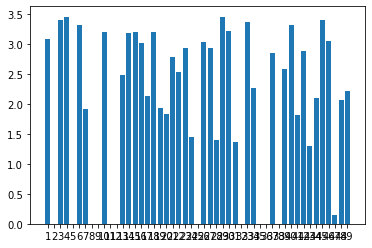

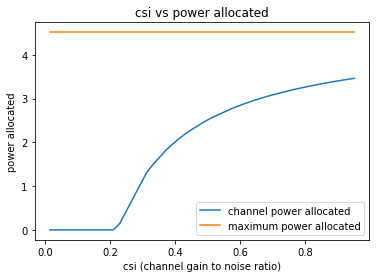

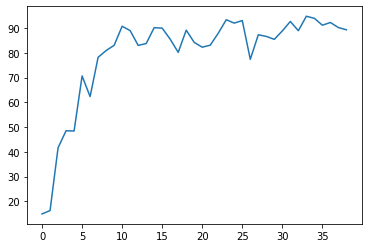

39
Power Allocated= 2.1520715345685497
CSI= 0.4270761761238061
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357215


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134713
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.136314

Power Allocated= 1.758937799836982
CSI= 0.3656793290675412
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.856164
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.486525
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000247

Power Allocated= 0
CSI= 0.17427547280615197
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.392549995116107
CSI= 0.9082452553144887
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.19102839185005926
CSI= 0.23242053592625778
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639986


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197430
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.373380

Power Allocated= 3.256649530478826
CSI= 0.808456677764123
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.637807
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134859
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.267239

Power Allocated= 2.737617928515642
CSI= 0.569490267243484
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.423448
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007082
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052733

Power Allocated= 2.457625653722936
CSI= 0.49117155110602617
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.305747
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012913
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.318398

Power Allocated= 0
CSI= 0.20353069223573705
SNR= 18.2773629321

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.1702, Accuracy: 9472/10000 (95%)

Power in training Round= 97.9983588096483



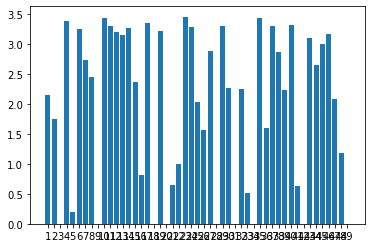

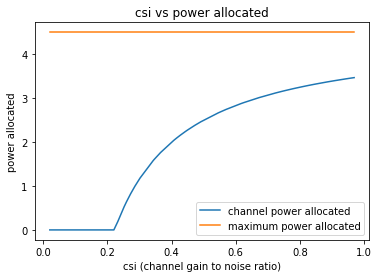

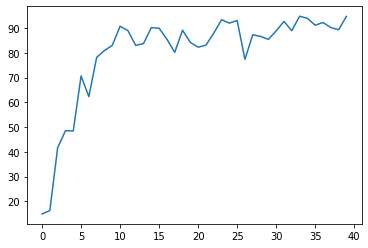

40
Power Allocated= 3.2978657657363755
CSI= 0.8229254335297509
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422809


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055439
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111494

Power Allocated= 2.439676465074479
CSI= 0.48230746037336447
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1514426405264062
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2017581991821182
CSI= 0.7626110157036843
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.237774


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018589
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216147

Power Allocated= 1.5073994916589042
CSI= 0.33270748817622653
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366976
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031865
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250879

Power Allocated= 3.482003016416995
CSI= 0.9698947793565208
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466849
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000066
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.478893

Power Allocated= 3.2331976646359286
CSI= 0.7813445983987386
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301279
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003494
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147276

Power Allocated= 0
CSI= 0.15772803715098416
SNR= 18.240138

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3193, Accuracy: 8837/10000 (88%)

Power in training Round= 98.00646897042267



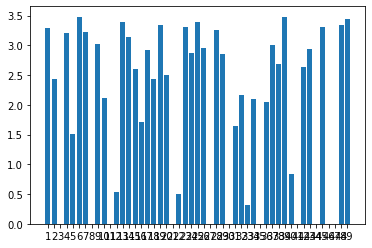

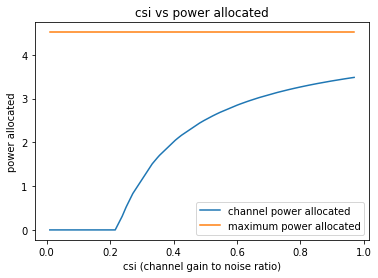

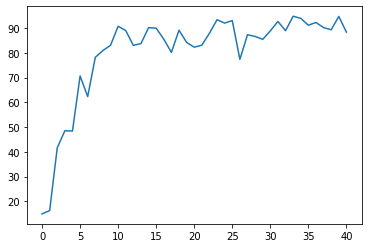

41
Power Allocated= 0
CSI= 0.08612395071632739
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.04078178913907793
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.018092866252113
CSI= 0.6647440527947128
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344170


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009920
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007716

Power Allocated= 1.6854533673977978
CSI= 0.35248776627557377
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.711955
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089749
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070198

Power Allocated= 3.0644298131981373
CSI= 0.6858703760879914
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.772237
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068844
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104435

Power Allocated= 2.3446944459424364
CSI= 0.4591923110190749
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.988581
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013761
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150606

Power Allocated= 3.3658631414664466
CSI= 0.86462698115302

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.1920, Accuracy: 9422/10000 (94%)

Power in training Round= 97.99407498755596



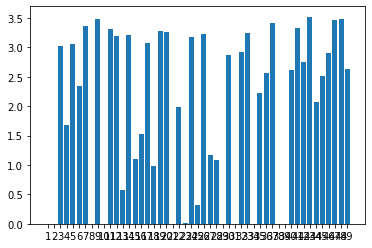

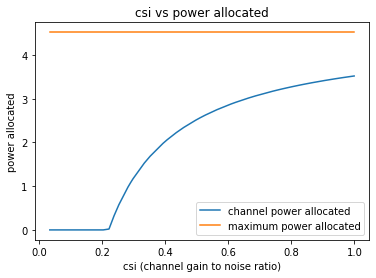

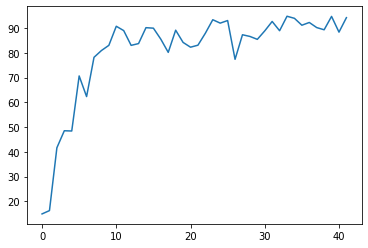

42
Power Allocated= 1.4027695032221494
CSI= 0.2550059506786718
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.698608


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099670
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074913

Power Allocated= 0.8604681730809594
CSI= 0.22402545558483855
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.688626
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074294
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.192996

Power Allocated= 1.9533926035905216
CSI= 0.29666072615363503
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509021
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021230
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002009

Power Allocated= 1.628823393589368
CSI= 0.2706049994749524
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.850960
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094908
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062978

Power Allocated= 4.046297728933031
CSI= 0.782503907387521

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215768
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313537

Power Allocated= 3.9195266683387238
CSI= 0.7118856676418035
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.349299
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000128
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009296

Power Allocated= 4.2057148872339685
CSI= 0.8940291736994478
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06011855698894386
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.657819470273242
CSI= 0.6000862388145194
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.500023
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005345
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0.230665

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4943, Accuracy: 8480/10000 (85%)

Power in training Round= 97.99458235923716



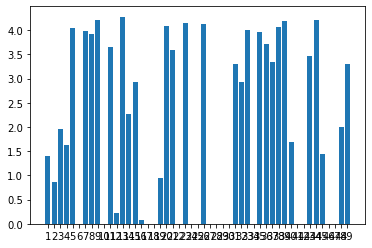

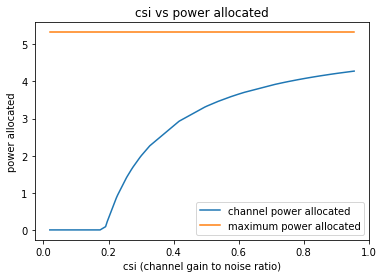

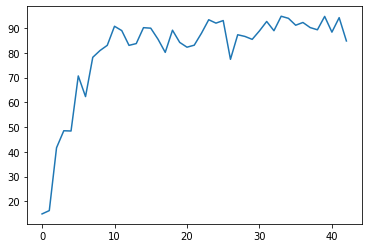

43
Power Allocated= 2.225983272640203
CSI= 0.47610001571420657
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.762599


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106932
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.130969

Power Allocated= 0.4318131516393424
CSI= 0.2567678136559628
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.626103
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146324
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116240

Power Allocated= 1.8672009849957405
CSI= 0.4066393975839586
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.546671
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078016
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167685

Power Allocated= 3.257963715655837
CSI= 0.9359627716877601
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750961
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091383
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003869

Power Allocated= 2.304626530756025
CSI= 0.49461959032390557

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035855
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034889

Power Allocated= 2.2144616510657196
CSI= 0.4735026433793996
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.095988
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002851
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009742

Power Allocated= 2.786809360085103
CSI= 0.6495307806627114
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562522
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088953
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013154

Power Allocated= 2.6370210396066476
CSI= 0.5919397086895661
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.418862
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000007
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.7623659911340517
CSI= 0.3900

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4403, Accuracy: 8574/10000 (86%)

Power in training Round= 98.00667592441641



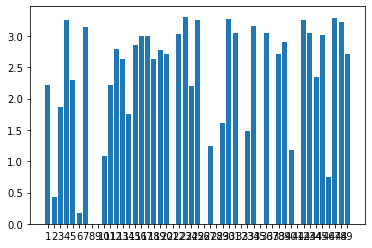

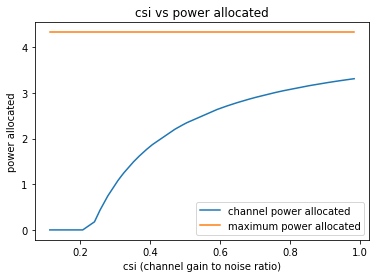

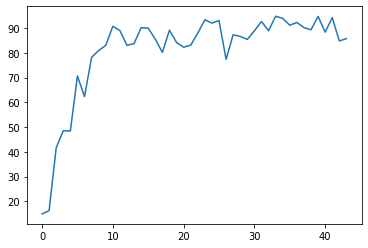

44
Power Allocated= 3.3159045555068003
CSI= 0.5210641849724093
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.03904956702064655
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.374772215551762
CSI= 0.5375529937435803
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.302667


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027789
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014996

Power Allocated= 3.4409492004001665
CSI= 0.557381065044339
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4956767738727006
CSI= 0.5749184422824026
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.920942888028447
CSI= 0.3017400413065182
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.912303
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020710
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093871

Power Allocated= 4.139923692798493
CSI= 0.9131334102534057
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.594208
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069424
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176054

Power Allocated=

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5233, Accuracy: 9139/10000 (91%)

Power in training Round= 97.99078053709066



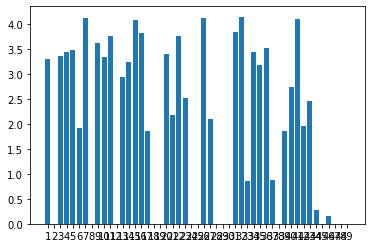

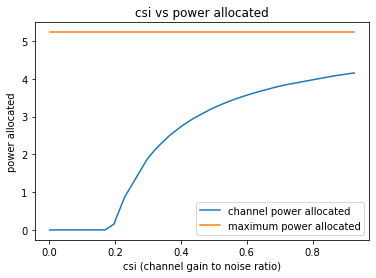

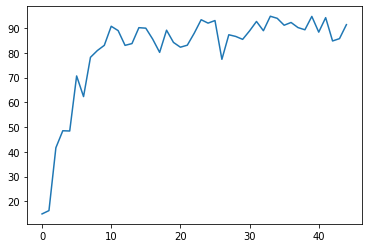

45
Power Allocated= 0
CSI= 0.0005851263128237028
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3313764387171947
CSI= 0.761437514503871
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.730378


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087012
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006846

Power Allocated= 0.045693600820341906
CSI= 0.21743912968383772
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.235161
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092845
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005724

Power Allocated= 3.3828127294825654
CSI= 0.7924752196756246
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.873551
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099784
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075509

Power Allocated= 1.8081640462538733
CSI= 0.3525449417075879
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.744033
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117233
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240576

Power Allocated= 3.257527181464611
CSI= 0.7209001493492

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6108, Accuracy: 7758/10000 (78%)

Power in training Round= 97.9950543311133



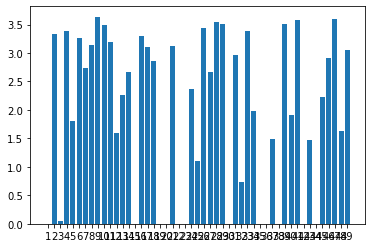

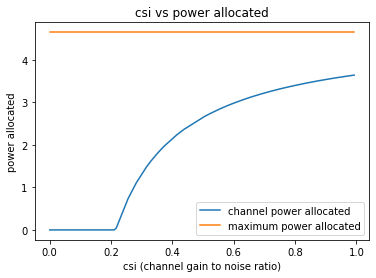

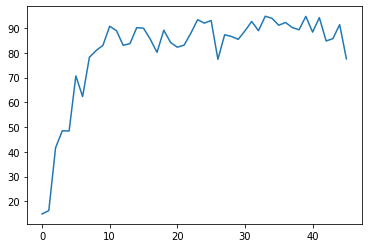

46
Power Allocated= 2.510871604724371
CSI= 0.5541143505512496
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.336584


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064603
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379980

Power Allocated= 2.6190631023761117
CSI= 0.5894522871738909
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.125838
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038435
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000146

Power Allocated= 3.110761876584532
CSI= 0.8300192205934548
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.854561283831603
CSI= 0.6844664587268743
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536113
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058200
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.254724

Power Allocated= 2.3345860053439607
CSI= 0.5048039036056701
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.360706
Model client5 Tra

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004948
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069922

Power Allocated= 3.1341333175359987
CSI= 0.8464390765694182
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472464
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141167
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088955

Power Allocated= 0
CSI= 0.05073666235590091
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5706712343409173
CSI= 0.5731046505005991
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610566
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000679
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104279

Power Allocated= 0
CSI= 0.15875004090102562
SNR= 20.21487098457923
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8782880146599257
CSI=

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5264, Accuracy: 8373/10000 (84%)

Power in training Round= 98.00433481927706



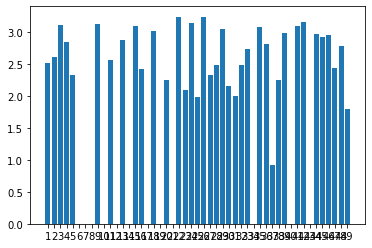

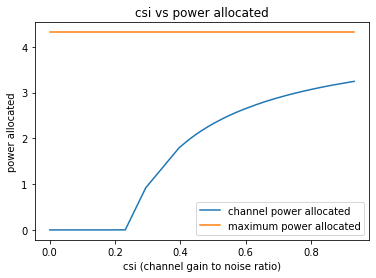

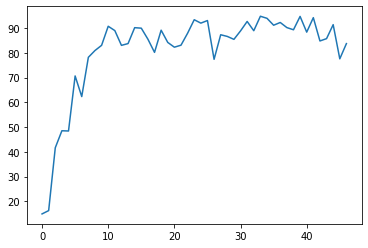

47
Power Allocated= 1.374587753472154
CSI= 0.33483885325550156
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.052703


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.391691
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064627

Power Allocated= 2.2504046704083867
CSI= 0.4737777457523259
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240507
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024760
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141062

Power Allocated= 1.9725596465702568
CSI= 0.4186659097083725
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8626962433499274
CSI= 0.6673773106722848
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.543702
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041602
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000179

Power Allocated= 2.8119998293330464
CSI= 0.6455364646150153
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.617850
Model client5 T

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.321566
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002265

Power Allocated= 0
CSI= 0.13067413272901718
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.099255506130368
CSI= 0.7924913091656907
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.194575
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002094
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056558

Power Allocated= 2.1454387181154364
CSI= 0.45133272891774556
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.579758
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052034
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081387

Power Allocated= 0.6473241844823074
CSI= 0.2692678071496102
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.609872
Model client13 Train E

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3754, Accuracy: 8800/10000 (88%)

Power in training Round= 97.99893040207135



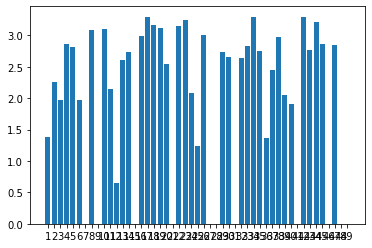

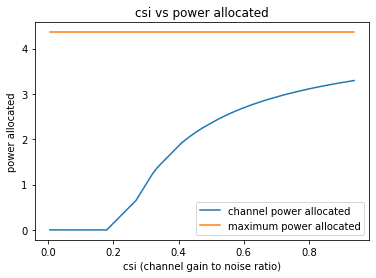

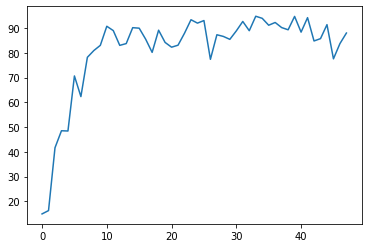

48
Power Allocated= 1.5465830178135174
CSI= 0.3263428850121669
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.817777


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.319084
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210273

Power Allocated= 3.1179116360063257
CSI= 0.669822391637043
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.188521
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177408
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030879

Power Allocated= 0
CSI= 0.1780380589293028
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5411780949166287
CSI= 0.9348707241459321
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794423


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045411
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004949

Power Allocated= 2.639188109138071
CSI= 0.5071877127136992
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.057117
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122794
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.324399

Power Allocated= 3.571329177964947
CSI= 0.9619865911653434
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.755192
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004609
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087544

Power Allocated= 0
CSI= 0.10719779996860679
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7058122014059998
CSI= 0.2560798146062401
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.177994
Model client8 Train Epoch: 2 [0/1

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.1848, Accuracy: 9522/10000 (95%)

Power in training Round= 97.99736077002296



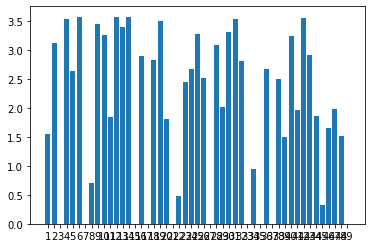

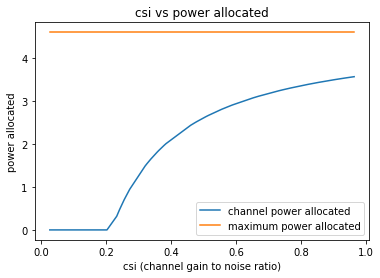

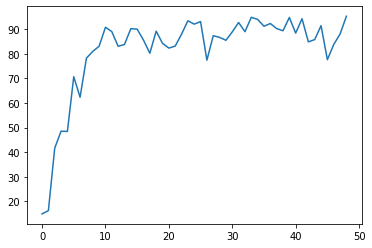

49
Power Allocated= 2.5543909349955296
CSI= 0.6053690806894618
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605831


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162047
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017511

Power Allocated= 2.6069588296255652
CSI= 0.6252669366885703
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.550730
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049791
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074296

Power Allocated= 2.9317028896320725
CSI= 0.7845765593714358
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358318
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004113
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000994

Power Allocated= 2.5410289991137436
CSI= 0.6005116006965411
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.92940552845905
CSI= 0.7831649392432624
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.611540
Model client5 Tra

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client19 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013272
Model client19 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006172

Power Allocated= 2.2124406619593007
CSI= 0.5015459900658827
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.766388
Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157751
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005678

Power Allocated= 0
CSI= 0.2152141864700371
SNR= 24.10390762049326
Client: client21
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2002247932214702
CSI= 0.9939854238034027
SNR= 24.66660942172393
Client: client22
Model client22 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455111
Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038042
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017551

Power Allocated= 3.0423162185168326
CSI= 0.8591363886847402
SNR= 25.303597920016873
Client: client23
Model client23 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428056
Model client23 Train 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2622, Accuracy: 9092/10000 (91%)

Power in training Round= 98.0062907761453



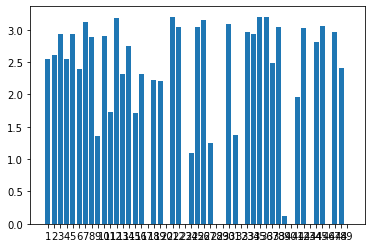

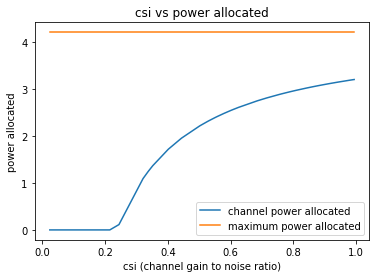

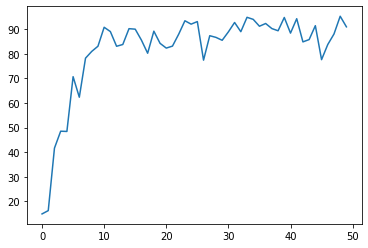

50
Power Allocated= 3.329681515303509
CSI= 0.893248950501079
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.425550205024797
CSI= 0.49415902980375603
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1039046372701176
CSI= 0.7433365766260952
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456454


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009876
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050833

Power Allocated= 2.894422747490589
CSI= 0.6431829839986334
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.081581
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079451
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087064

Power Allocated= 3.2782615721610373
CSI= 0.8540229829258723
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.806503
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088483
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078183

Power Allocated= 2.034644879485396
CSI= 0.41415664136966446
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432583
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002480
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007033

Power Allocated= 0
CSI= 0.20334286733670492
SNR= 17.8211536

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128347
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.049932

Power Allocated= 0
CSI= 0.033497353490793746
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3625339186876415
CSI= 0.9202541535902213
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.534393
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115571
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019550

Power Allocated= 2.7715529150722342
CSI= 0.596076387157613
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437970
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030938
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004167

Power Allocated= 3.1464160074992273
CSI= 0.767592702857755
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.768019
Model client13 Train Ep

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3180, Accuracy: 8937/10000 (89%)

Power in training Round= 98.00446633484216



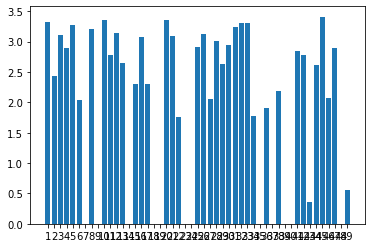

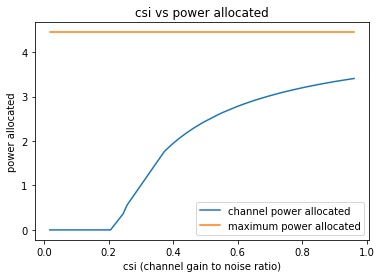

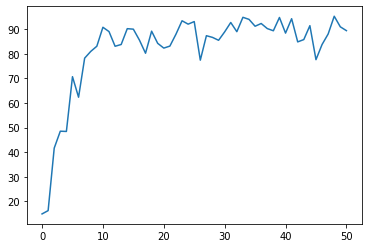

51
Power Allocated= 1.9219156758267473
CSI= 0.3538041581937684
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.163509233945767
CSI= 0.6309829616206574
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.574282946500598
CSI= 0.8517487552696698
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505509


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001935
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003167

Power Allocated= 0
CSI= 0.02549152030965285
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8039158906962793
CSI= 0.5142916001685413
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.758545


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051313
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021384

Power Allocated= 3.696208042179462
CSI= 0.9504528551266801
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.161666
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005388
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004460

Power Allocated= 0.34128550118102385
CSI= 0.22690902405540347
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.516157
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043947
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084577

Power Allocated= 0
CSI= 0.010386268717576974
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7202176381594407
CSI= 0.9726486875251195
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.34868230

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.7247, Accuracy: 7540/10000 (75%)

Power in training Round= 98.0073671131668



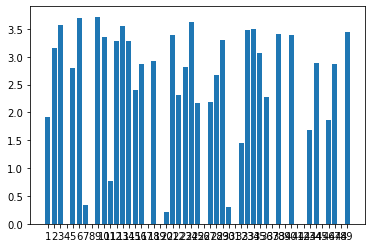

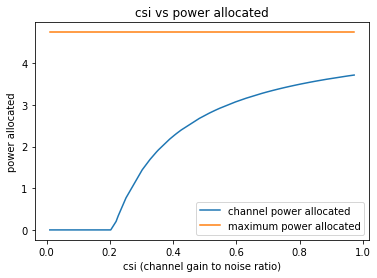

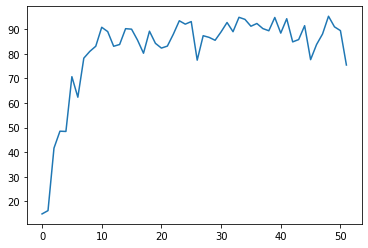

52
Power Allocated= 2.935297845727443
CSI= 0.6689098592530751
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1496518911367413
CSI= 0.7808743890320271
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6963214164869473
CSI= 0.5767191717569516
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.419952


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096982
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003372

Power Allocated= 3.2161192899795155
CSI= 0.8236226180083089
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.937404
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097578
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007704

Power Allocated= 3.2003151449057983
CSI= 0.8130395654583016
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.630367
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246718
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.543512

Power Allocated= 2.526986024002556
CSI= 0.525408336228616
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.279271
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007192
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087372

Power Allocated= 0
CSI= 0.09958873036071902
SNR= 17.82115362

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049515
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080502

Power Allocated= 3.4267927107365876
CSI= 0.9965371555339139
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.616999
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.355686
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036852

Power Allocated= 0
CSI= 0.18151594089973921
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.09505084100627914
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.336714486432392
CSI= 0.9144503348010105
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.279388
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182089
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220656

Power Allocated= 1.6857484675285699
CSI= 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3608, Accuracy: 9063/10000 (91%)

Power in training Round= 98.00608325221604



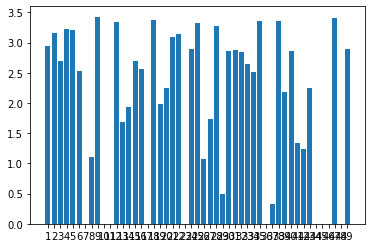

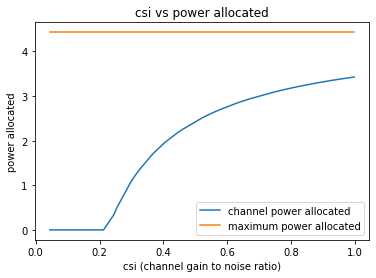

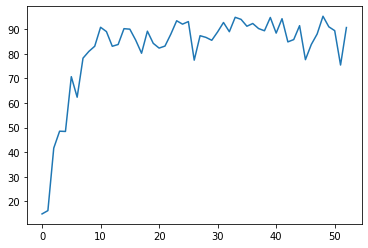

53
Power Allocated= 2.947846800489179
CSI= 0.8853797034383919
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.065434272551787
CSI= 0.9882678339193419
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.829297


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004223
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000961

Power Allocated= 0
CSI= 0.06374118144716956
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.490562683762901
CSI= 0.6302217683910035
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564408


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017301
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024856

Power Allocated= 1.5163627518164295
CSI= 0.39048116800571164
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.793537
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127316
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079105

Power Allocated= 2.0789304198793728
CSI= 0.5004065061000113
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.308407
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068324
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023677

Power Allocated= 2.699358371803034
CSI= 0.7257171356607676
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716292
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048083
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022077

Power Allocated= 1.2005563134675583
CSI= 0.347614567673679

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2072, Accuracy: 9366/10000 (94%)

Power in training Round= 97.99914096211765



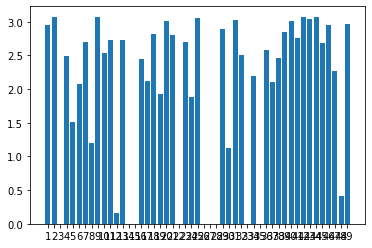

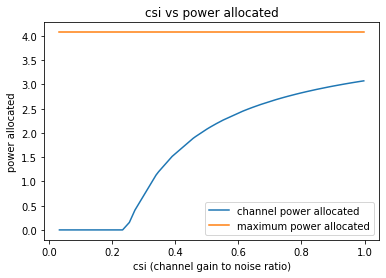

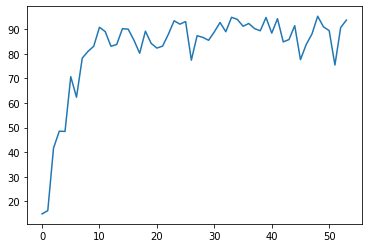

54
Power Allocated= 3.3277883643039434
CSI= 0.7348165929030406
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.910933


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018567
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090627

Power Allocated= 2.0266981998925746
CSI= 0.3756610740619114
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356360
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008422
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000191

Power Allocated= 3.6523279388219203
CSI= 0.9649303501715961
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.7151330939653882
CSI= 0.33629959959763134
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.757253
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181941
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021024

Power Allocated= 3.2834585736542774
CSI= 0.7116355862152444
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.584953
Model client5 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086635
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007613

Power Allocated= 0
CSI= 0.18214855938416785
SNR= 21.10269532158381
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.6056674495357592
CSI= 0.9233570112039144
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.372117
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023494
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006686

Power Allocated= 2.8058258403126253
CSI= 0.5311107896977221
SNR= 22.970977389425087
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376648
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000655
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001922

Power Allocated= 3.532332942297735
CSI= 0.8647981299398042
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428550
Model client17 Train

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4314, Accuracy: 9091/10000 (91%)

Power in training Round= 97.99942997383195



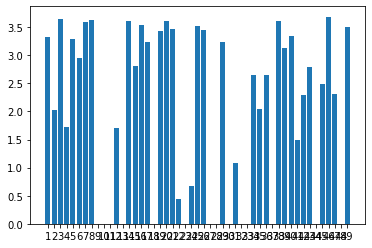

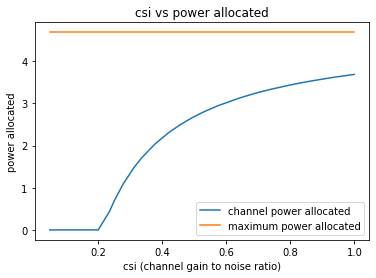

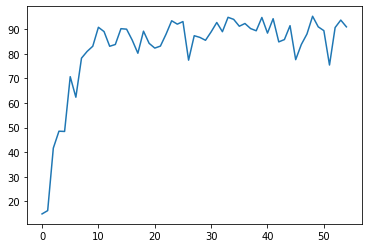

55
Power Allocated= 2.8331193109418606
CSI= 0.6815628520061724
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8694695579018683
CSI= 0.6988775273637498
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690443


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006459
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041749

Power Allocated= 1.9601918151110818
CSI= 0.4273242015049663
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.802569
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018809
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000175

Power Allocated= 3.2541630869283384
CSI= 0.9558654559065389
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848768
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013709
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000299

Power Allocated= 3.1873259182138214
CSI= 0.898464921330259
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512994
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067837
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.263535

Power Allocated= 2.7660787777438633
CSI= 0.6517814350225787

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003970
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104000

Power Allocated= 2.6306586537239482
CSI= 0.5989183155125288
SNR= 22.970977389425087
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.304724
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000320
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252147

Power Allocated= 2.892526962792616
CSI= 0.7103239013107314
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.728249
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057853
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057901

Power Allocated= 0.024474332846130764
CSI= 0.23387102110562752
SNR= 23.641228135642812
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535215
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064665
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007681

Power Allocated= 0
CSI= 0.0106606324383876

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4517, Accuracy: 8130/10000 (81%)

Power in training Round= 97.9995459323456



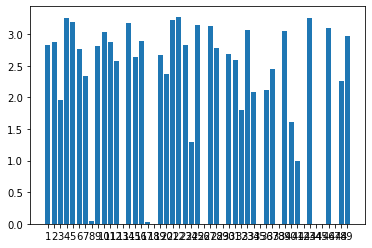

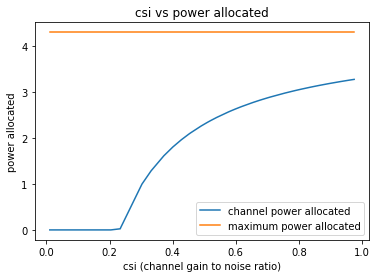

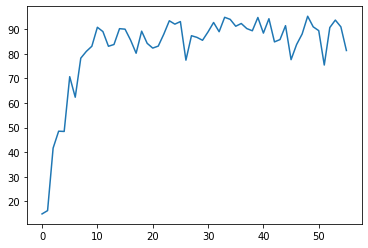

56
Power Allocated= 0.7846901651861722
CSI= 0.2807409988589198
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.850930


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062117
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201422

Power Allocated= 1.1379013464722272
CSI= 0.3116438732999549
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.778046
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033581
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069420

Power Allocated= 0.8594204862834736
CSI= 0.28675712461830494
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.051016
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133668
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031676

Power Allocated= 2.217162567017537
CSI= 0.4695872740560191
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.809488
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049739
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000491

Power Allocated= 2.576904146103436
CSI= 0.5650394216963049

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022211
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120242

Power Allocated= 3.2441202726416476
CSI= 0.9069703344334784
SNR= 22.970977389425087
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.239693
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009811
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057386

Power Allocated= 0.8939934591491325
CSI= 0.28962851512370014
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.353438
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056768
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.131040

Power Allocated= 2.971899296936546
CSI= 0.7273822999706799
SNR= 23.641228135642812
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.177744
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014253
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.127060

Power Allocated= 3.2219038137460765
CSI= 0.8

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3694, Accuracy: 8710/10000 (87%)

Power in training Round= 97.99743748905492



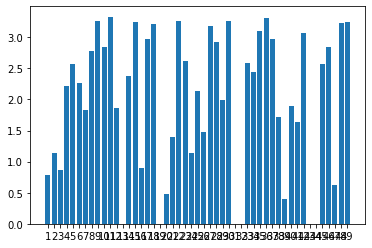

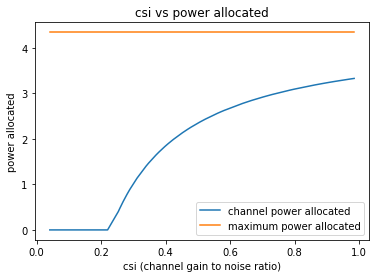

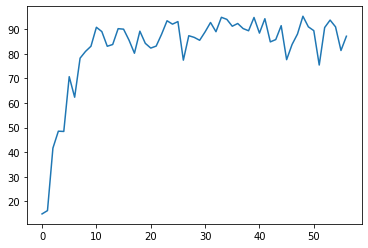

57
Power Allocated= 3.7973816593098846
CSI= 0.9423004342315785
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3442492239978465
CSI= 0.660342740683821
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07257887436576671
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9598243470504118
CSI= 0.2564898355947828
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.155158


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107496
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157919

Power Allocated= 0.12008351897180614
CSI= 0.211035876164123
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.462684
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193458
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014508

Power Allocated= 3.332613940530396
CSI= 0.6553078304303179
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795585
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000647
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035137

Power Allocated= 0.8472910362241679
CSI= 0.2492942922970114
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.638939
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005651
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016350

Power Allocated= 0.8113637420467263
CSI= 0.2470813160563433

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2777, Accuracy: 9115/10000 (91%)

Power in training Round= 98.0070018143986



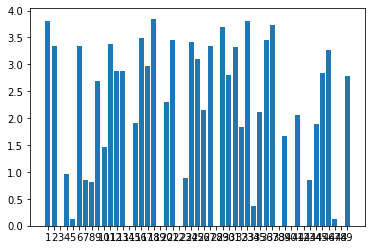

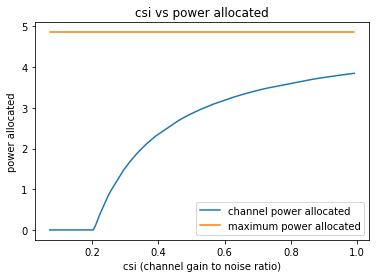

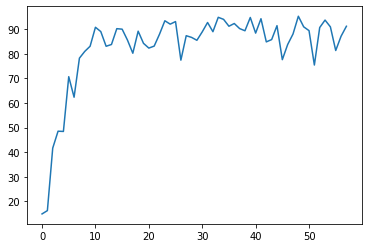

58
Power Allocated= 2.459333654026582
CSI= 0.5286755989224645
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3334494772198693
CSI= 0.4956867102354171
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.654803


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056652
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000879

Power Allocated= 3.2756995586466635
CSI= 0.930100000723388
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.08885298328227209
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0971832659371517
CSI= 0.7976583932514211
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.013525


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148112
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056976

Power Allocated= 2.728587597682889
CSI= 0.6164220368072928
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.2034723012247883
CSI= 0.4656836624303098
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.113477
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092126
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.213364

Power Allocated= 3.334144500464964
CSI= 0.9835663117676601
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.150896
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007992
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.16648256175586196
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.11929

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2100, Accuracy: 9388/10000 (94%)

Power in training Round= 97.99362565160455



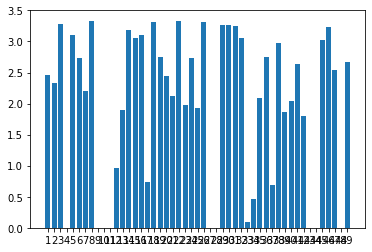

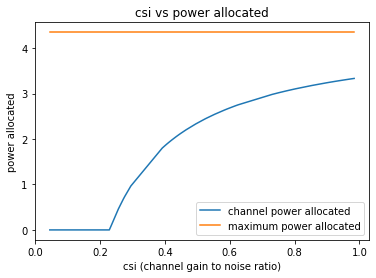

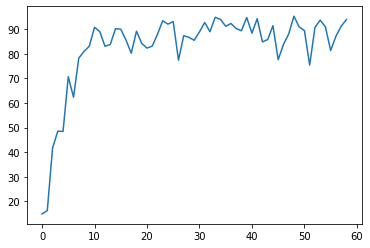

59
Power Allocated= 3.030040252615332
CSI= 0.790897977421873
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.315184


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182378
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124897

Power Allocated= 1.1112233340990811
CSI= 0.3141490369002067
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.566669
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.290285
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.045503

Power Allocated= 2.0006096913516567
CSI= 0.43595473100708404
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363824
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104385
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027419

Power Allocated= 3.1258756063026376
CSI= 0.8557612460415049
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.132731075134263
CSI= 0.8608113200806473
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664335
Model client5 T

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003098
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037125

Power Allocated= 0
CSI= 0.21573680141061802
SNR= 23.671158746923165
Client: client19
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1430932204704791
CSI= 0.3173260719306211
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.728188
Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072694
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142325

Power Allocated= 2.2963792341220444
CSI= 0.5004888271511435
SNR= 24.10390762049326
Client: client21
Model client21 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.598080
Model client21 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038181
Model client21 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132146

Power Allocated= 0.9666151713775966
CSI= 0.3004978651133545
SNR= 24.66660942172393
Client: client22
Model client22 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.338859
Model client22 Train

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.1630, Accuracy: 9498/10000 (95%)

Power in training Round= 97.99949796635723



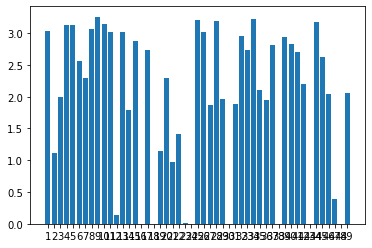

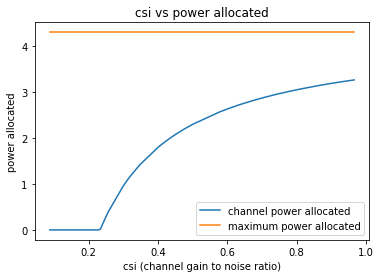

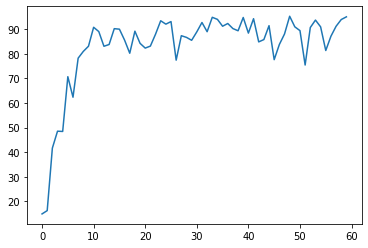

60
Power Allocated= 2.813405842758388
CSI= 0.5114274964902603
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307668


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146092
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.376932

Power Allocated= 0
CSI= 0.1305779770695119
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.7469744211556364
CSI= 0.3309348505816311
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.518385


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006971
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.16728676807427867
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7339535891417803
CSI= 0.9664042830104912
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.1056480262598033
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.423561008552733
CSI= 0.7434080853624239
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.491121
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020979
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035355

Power Allocated= 1.0670979391196584
CSI= 0.2701520403508819
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.738462
Mode

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3231, Accuracy: 9007/10000 (90%)

Power in training Round= 98.00344500954836



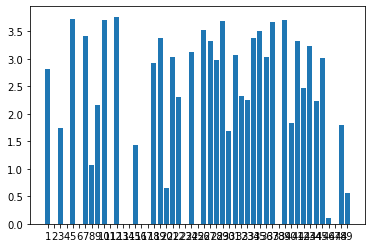

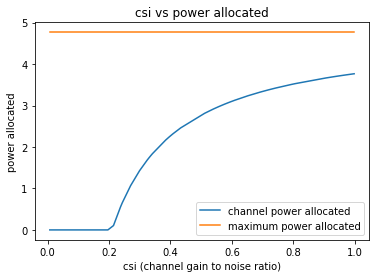

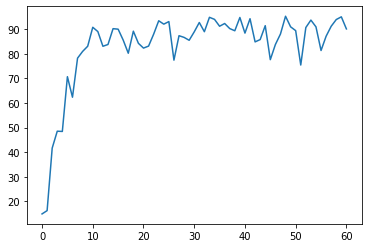

61
Power Allocated= 3.0263339852500133
CSI= 0.8284950501275182
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.08943773905934904
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8399316671546435
CSI= 0.7176637921711637
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.696943


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019887
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036818

Power Allocated= 0
CSI= 0.12958002625630038
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.521165321479008
CSI= 0.5840519435552951
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0348401120858712
CSI= 0.8343751286040266
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445528
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063159
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019552

Power Allocated= 2.6475145477530475
CSI= 0.6305857075997029
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378347
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070335
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058591

Power Allocated= 0
CSI= 0.0025

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2385, Accuracy: 9240/10000 (92%)

Power in training Round= 98.00213934721192



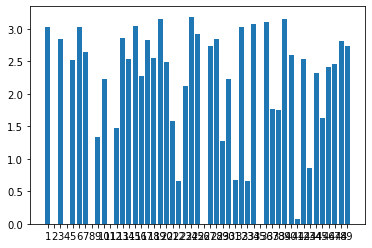

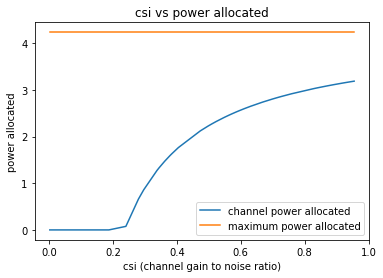

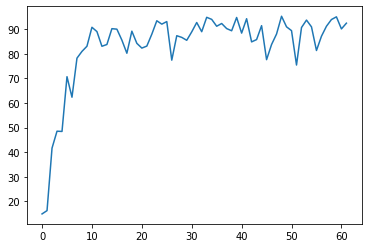

62
Power Allocated= 1.1939661606509704
CSI= 0.3001803862350335
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603838


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043019
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003653

Power Allocated= 1.7767585172639584
CSI= 0.36382980338937376
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.571278
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137471
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001556

Power Allocated= 2.5571378755942176
CSI= 0.5080891524164471
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6415276200247875
CSI= 0.3467684387687543
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605907
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000373
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005448

Power Allocated= 0
CSI= 0.040118808368012404
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.50343995

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170925
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000194

Power Allocated= 0
CSI= 0.06960151959643857
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.12833140461043424
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4361893308221276
CSI= 0.9181833650254261
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.853402
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024774
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032752

Power Allocated= 2.621259816826888
CSI= 0.5251999910115692
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363718
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075640
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052177

Power Allocated= 2.15262941344145
CSI= 0.4

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3718, Accuracy: 8758/10000 (88%)

Power in training Round= 97.99697135782716



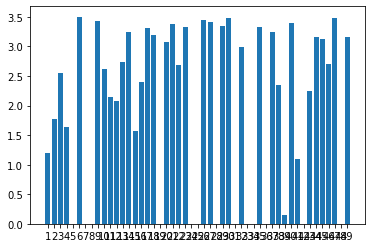

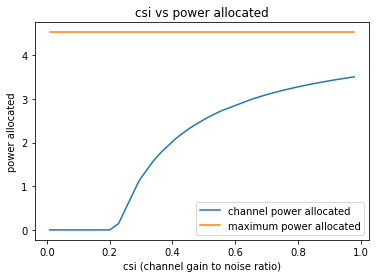

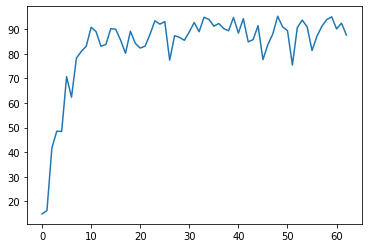

63
Power Allocated= 1.0901676030184486
CSI= 0.2897231456010063
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.673125


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.332268
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.365504

Power Allocated= 3.275419713834376
CSI= 0.7896905184554259
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.575051368647941
CSI= 0.5084692652114833
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358271
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151396
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102205

Power Allocated= 0
CSI= 0.21614407899781918
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.079568380983308
CSI= 0.4061457657977552
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.094834


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.255594
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232769

Power Allocated= 2.780258963741929
CSI= 0.5677045548376826
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570660
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033483
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038866

Power Allocated= 3.5250677358703304
CSI= 0.9836025181657037
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412980
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073990
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060498

Power Allocated= 0
CSI= 0.061722675834814944
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7575505938852434
CSI= 0.5604790577943388
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448200
Model client9 Train Epoch: 2 [0

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4835, Accuracy: 8344/10000 (83%)

Power in training Round= 98.00270353671212



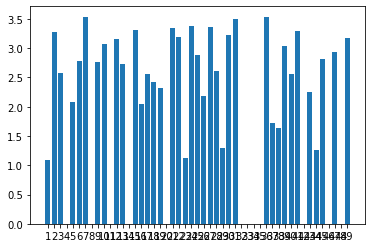

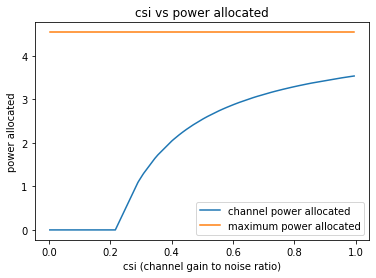

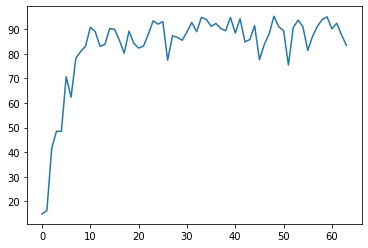

64
Power Allocated= 3.206099532844485
CSI= 0.6819603155851858
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5973382058949506
CSI= 0.3251903171975272
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335553


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012360
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226624

Power Allocated= 3.477353188913141
CSI= 0.8367449315264173
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.243563
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011039
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025320

Power Allocated= 3.2555767321032985
CSI= 0.7057741856877275
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.006348900521550238
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5065514128297304
CSI= 0.4616998920902301
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795067


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036419
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001413

Power Allocated= 3.2560219335002536
CSI= 0.7059960178637963
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.788292
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037364
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026862

Power Allocated= 1.0184192814819135
CSI= 0.2736695990416723
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.072857
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016162
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000428

Power Allocated= 2.014476148663809
CSI= 0.3762249363261785
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716520
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102338
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.598853

Power Allocated= 2.3844489279545193
CSI= 0.437060723152767


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2348, Accuracy: 9312/10000 (93%)

Power in training Round= 97.99479061245225



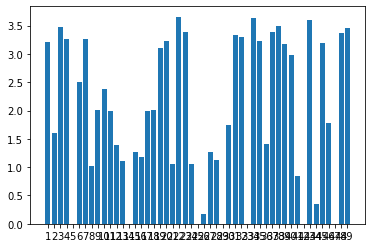

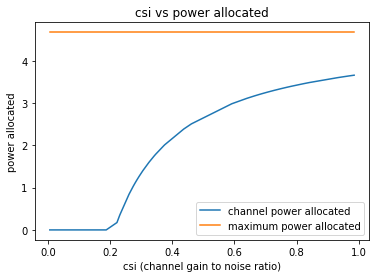

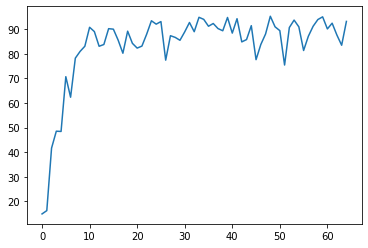

65
Power Allocated= 2.5927670491940744
CSI= 0.5001388985956102
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.860358


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098532
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013661

Power Allocated= 0
CSI= 0.19697175647663345
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8092101242691188
CSI= 0.5608520287286789
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.00820133398669054
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13318231430589544
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.213457317885587
CSI= 0.7252923935496723
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256892


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001512
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.605467498996434
CSI= 0.3348127469686487
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.855145
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045513
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007128

Power Allocated= 3.1224302667615396
CSI= 0.6803733121290452
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.126808
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072685
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002152

Power Allocated= 3.2940222712427674
CSI= 0.7703036612839967
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2410265845282975
CSI= 0.7400910917500696
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513665
Model client11

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4576, Accuracy: 8528/10000 (85%)

Power in training Round= 97.99744576984281



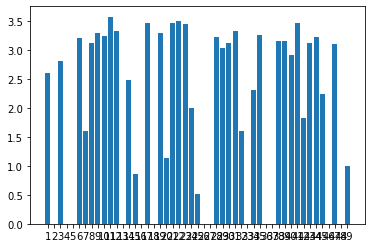

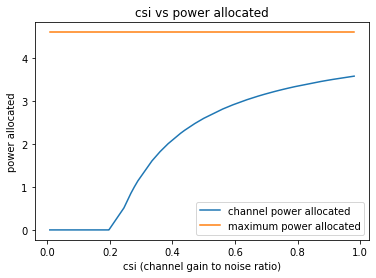

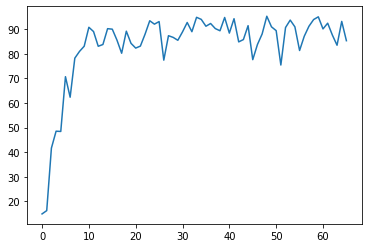

66
Power Allocated= 0
CSI= 0.045861992848864386
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1240469584866544
CSI= 0.9297860126773212
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.753228


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040323
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251411

Power Allocated= 1.8748762733681703
CSI= 0.43016544249659217
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.22938105648207863
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.03506543261908035
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.537329438757959
CSI= 0.6016000853732797
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1825209058783726
CSI= 0.4957754135323682
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116492
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211721
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152063



/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3363, Accuracy: 9234/10000 (92%)

Power in training Round= 97.99471327578645



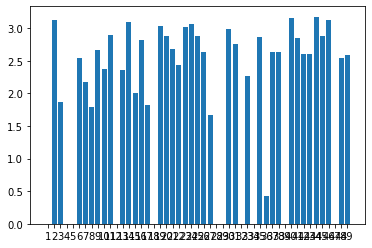

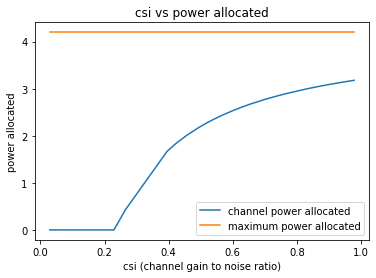

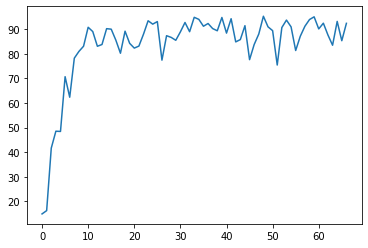

67
Power Allocated= 1.720688528896658
CSI= 0.3435144795394812
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.354166305854689
CSI= 0.4390571809149707
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.419763630609278
CSI= 0.4520774530072157
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.766899


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028869
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000141

Power Allocated= 3.4288240474912755
CSI= 0.8312897999841979
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.5638328034417519
CSI= 0.24582459755336739
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734985
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260038
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.233762

Power Allocated= 3.5789510261142445
CSI= 0.949827325048574
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.766644
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097463
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235486

Power Allocated= 0
CSI= 0.1590321063904091
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.77188518514

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023809
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037419

Power Allocated= 3.1691838121356266
CSI= 0.6837185352384935
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.821496
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086706
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009247

Power Allocated= 3.4081436112393617
CSI= 0.8172402664789565
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402635
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014816
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086862

Power Allocated= 2.9405800345814495
CSI= 0.591298241670409
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.693157
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013617
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.502606

Power Allocated= 3.5885166123299554
CSI= 0.95853625

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3839, Accuracy: 9024/10000 (90%)

Power in training Round= 98.00274639429361



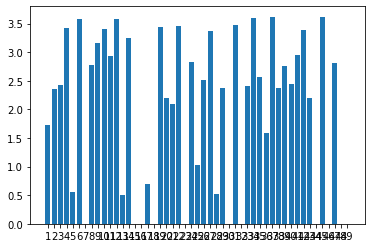

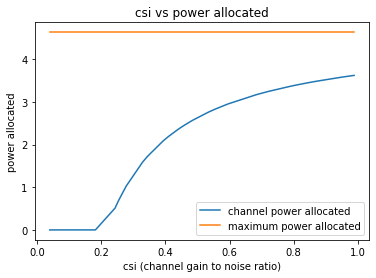

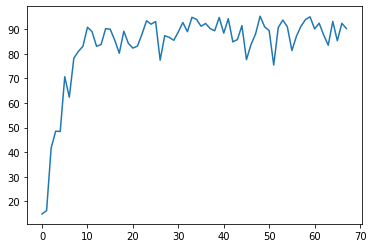

68
Power Allocated= 3.678384243185846
CSI= 0.9607782180499813
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.01712800049084673
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.567903588101509
CSI= 0.8685806358525101
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.921979


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062706
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001303

Power Allocated= 0
CSI= 0.19656017020232086
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.11262574733375363
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4618172729927776
CSI= 0.795298260180848
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5751149952051646
CSI= 0.8740554469630001
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.962331
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005326
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097654

Power Allocated= 3.2543364034548863
CSI= 0.6826540747872515
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.971124
Mod

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4921, Accuracy: 8856/10000 (89%)

Power in training Round= 98.00307469731254



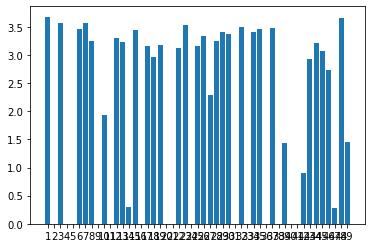

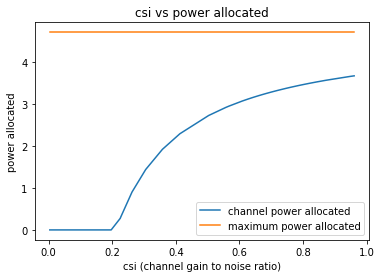

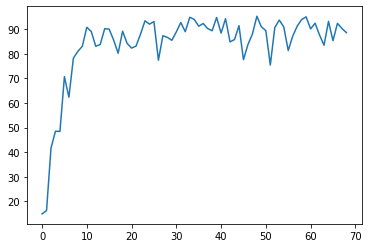

69
Power Allocated= 3.260502154054991
CSI= 0.8217088036522103
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.438108


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323757
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055137

Power Allocated= 3.2489823392253125
CSI= 0.8140035008382489
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.022918828987139594
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7066230887793394
CSI= 0.26519183266603685
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.713153


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104125
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039693

Power Allocated= 3.1369321769735707
CSI= 0.7459646442493981
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.048838
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134481
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138199

Power Allocated= 3.4230403011881827
CSI= 0.9483725132079699
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.539912
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092000
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120052

Power Allocated= 3.1753746327528605
CSI= 0.7679880160577204
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.637625222744408
CSI= 0.5435216653617728
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.622056
Model client8 Tr

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6113, Accuracy: 7868/10000 (79%)

Power in training Round= 98.00456185923582



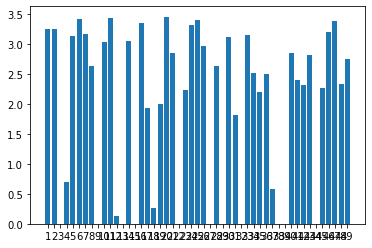

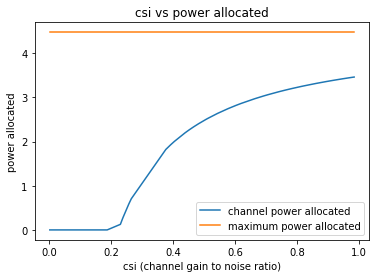

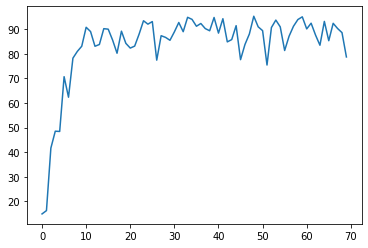

70
Power Allocated= 3.3564990206565053
CSI= 0.773952342698768
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2313982191924433
CSI= 0.7056316353186257
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1144194345776524
CSI= 0.28295356386460746
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.165278


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128785
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001252

Power Allocated= 3.1359948339644816
CSI= 0.6611249380429721
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.391787
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172114
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026464

Power Allocated= 2.8706821162506015
CSI= 0.5624657204358334
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.528897
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.171637
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307354

Power Allocated= 0
CSI= 0.017887239245079956
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.109318348665771
CSI= 0.6496670910888471
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.631806


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078635
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189044

Power Allocated= 3.6020013745436628
CSI= 0.9555051206647198
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.353945197415607
CSI= 0.43580142838873326
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.422548
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031397
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255506

Power Allocated= 1.1769937676437832
CSI= 0.2880537369081333
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.404214
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019283
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019128

Power Allocated= 0
CSI= 0.16531816917953523
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3693, Accuracy: 9056/10000 (91%)

Power in training Round= 98.00582788550824



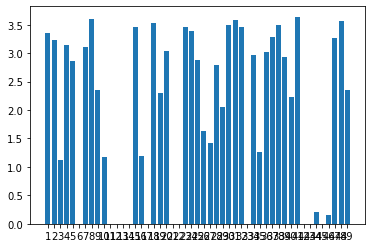

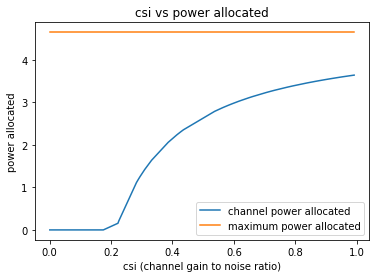

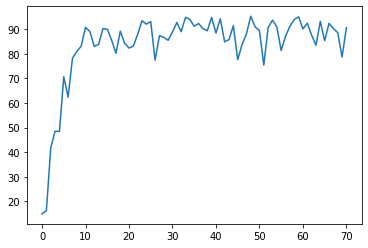

71
Power Allocated= 2.6793175488516607
CSI= 0.5497199719793379
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4101907304634853
CSI= 0.9189193187680949
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.017335025470394783
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.2783037484475797
CSI= 0.4504257373736932
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.773004


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057972
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189578

Power Allocated= 3.3026216692507213
CSI= 0.8362575295282051
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.111046
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088905
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.492739

Power Allocated= 3.42267979527462
CSI= 0.9295876787096558
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457269
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000350
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122703

Power Allocated= 3.3866639891247297
CSI= 0.8994734430838722
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.318219
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001917
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000004

Power Allocated= 3.3001003082707023
CSI= 0.8344979845992375


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3595, Accuracy: 8896/10000 (89%)

Power in training Round= 98.00412382174962



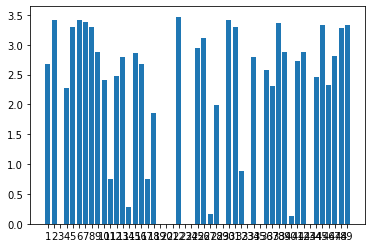

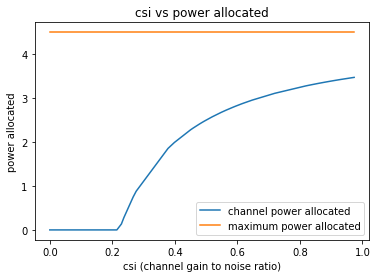

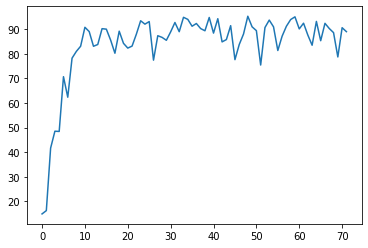

72
Power Allocated= 0
CSI= 0.17213124404910907
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1186681566725794
CSI= 0.29185378845037846
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.447930


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.482864
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372852

Power Allocated= 0.5589207665130758
CSI= 0.2508704833629104
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474834
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009302
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081537

Power Allocated= 1.3018269469857215
CSI= 0.30833607424326503
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.281106
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077510
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.569238

Power Allocated= 1.732916925025429
CSI= 0.3556030407498185
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.863386
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059145
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.361372

Power Allocated= 3.530087214945635
CSI= 0.9852661866491073

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3207, Accuracy: 9010/10000 (90%)

Power in training Round= 98.00732874227332



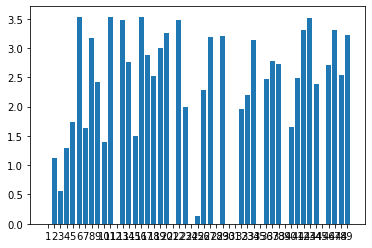

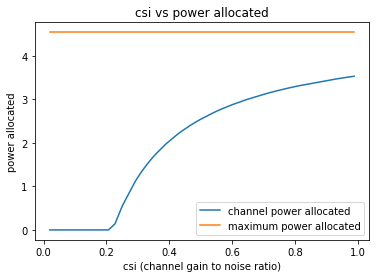

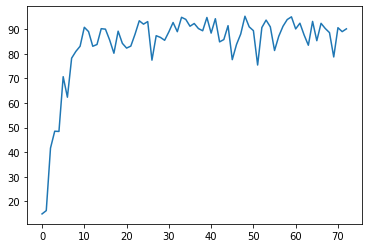

73
Power Allocated= 3.6154711998971125
CSI= 0.9468655009636502
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.780755


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121854
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.264225

Power Allocated= 3.1647068983712936
CSI= 0.6636226265686732
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353598
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000215

Power Allocated= 2.4449817958243734
CSI= 0.4491141114973971
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.10352325869410917
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.0877463756016259
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.233026525937252
CSI= 0.4100779309721483
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257286


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003413

Power Allocated= 1.9508128564283975
CSI= 0.36754239721101334
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513038
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028990
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.846558

Power Allocated= 0
CSI= 0.049937316680893074
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.04421501113255499
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5524889251875287
CSI= 0.8935764078685011
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5499763692215311
CSI= 0.3203474066467896
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.0348

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2455, Accuracy: 9246/10000 (92%)

Power in training Round= 98.00002547519617



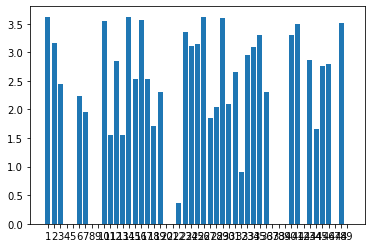

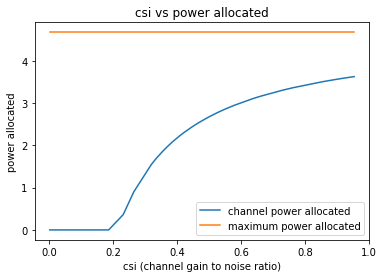

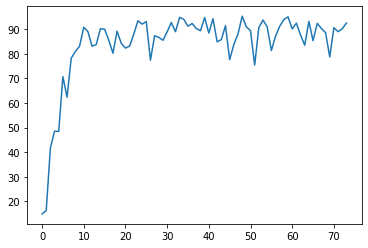

74
Power Allocated= 1.4509248872232727
CSI= 0.3569517611830697
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588899


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085713
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226014

Power Allocated= 2.6215505139267963
CSI= 0.6131683917426201
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298766
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009214
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143227

Power Allocated= 0
CSI= 0.11711399860271499
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0431304033910753
CSI= 0.8269291268074724
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.347436


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169868
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053027

Power Allocated= 2.9619658137332676
CSI= 0.7749186315236576
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.476392
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210583
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053873

Power Allocated= 2.982739719923132
CSI= 0.7875974436580276
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.943604255137197
CSI= 0.764047222223186
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.762157
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142043
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.341703

Power Allocated= 3.19058059042897
CSI= 0.9417585516643993
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.506285
Model client8 Train 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2544, Accuracy: 9160/10000 (92%)

Power in training Round= 97.99748488640277



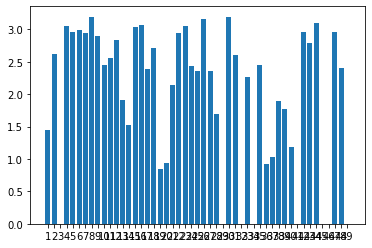

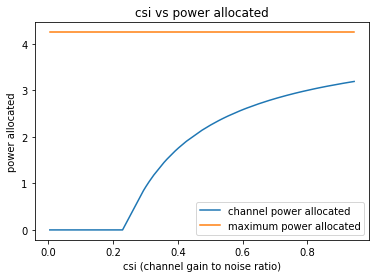

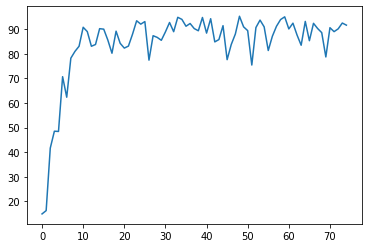

75
Power Allocated= 0
CSI= 0.2315589934538106
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0639912045734876
CSI= 0.48534254646301267
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.15638063593290097
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3718550556213067
CSI= 0.5706014938199163
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.599525


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041803
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286631

Power Allocated= 3.071314654837793
CSI= 0.9495981798811282
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.285511
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009962
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.362121

Power Allocated= 2.074869905731024
CSI= 0.48791870674578286
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.483903
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032174
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250431

Power Allocated= 0
CSI= 0.05803602469385405
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.2810655593003224
CSI= 0.5424976100727241
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.792409
Model client8 Train Epoch: 2 [0/

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2687, Accuracy: 9131/10000 (91%)

Power in training Round= 98.00288941001506



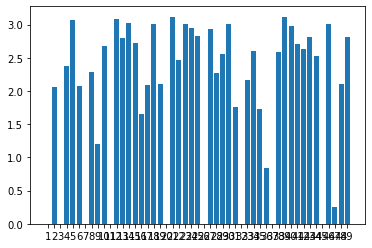

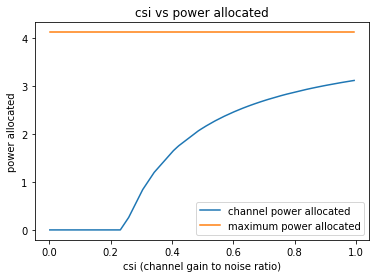

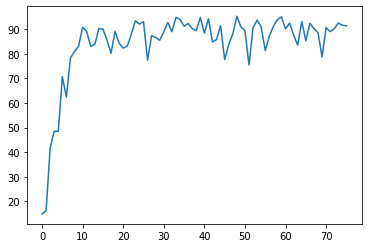

76
Power Allocated= 1.2935200911719167
CSI= 0.32043975705126826
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.889280


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146600
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181851

Power Allocated= 2.4813049818232082
CSI= 0.5173502457303307
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2058283299699437
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.245643983547048
CSI= 0.46112965263119454
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346998


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012518
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041467

Power Allocated= 3.3675074173141857
CSI= 0.9553616215121351
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2222456368215613
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.093997240579273
CSI= 0.7574413451791273
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2914525857540866
CSI= 0.8906473064972563
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3202928902409123
CSI= 0.9141280938981449
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371067
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125957
Model client9 Train Epoch: 3 [0/1216 (0%)]	Lo

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4658, Accuracy: 8270/10000 (83%)

Power in training Round= 98.00513998169644



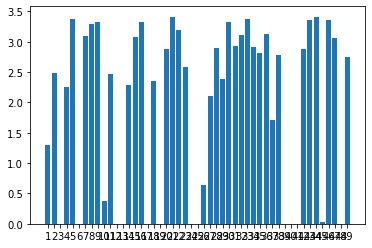

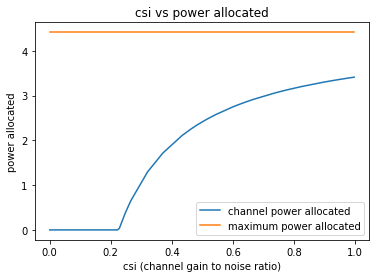

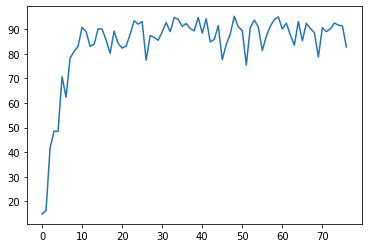

77
Power Allocated= 0
CSI= 0.00278684294403031
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.005835111172648122
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.15014328521774267
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0439425455822864
CSI= 0.39843946936865426
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.02017125523470864
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.378269040894407
CSI= 0.4596718358281985
SNR= 17.437510126097536
Client: client6


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.295985
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007683
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.1822747792470245
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.395518224767213
CSI= 0.8633969316536277
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.348567567026141
CSI= 0.8297608705748177
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.303725
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037536
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016856

Power Allocated= 2.8728683462312317
CSI= 0.5949315228811027
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522485
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054807
Model client11 Train Epoch: 3 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3925, Accuracy: 9080/10000 (91%)

Power in training Round= 98.00049903283785



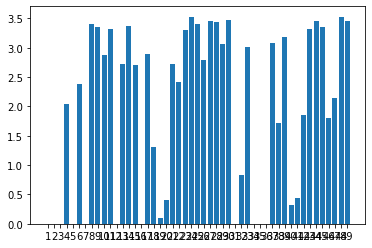

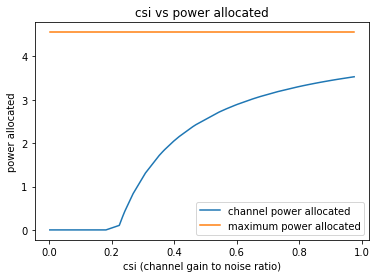

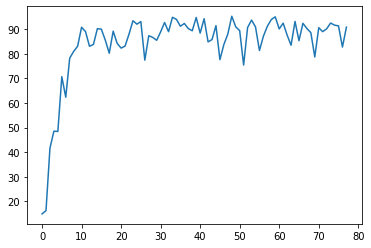

78
Power Allocated= 2.314057205906619
CSI= 0.5142647171799963
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448805


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079067
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056057

Power Allocated= 0
CSI= 0.20253549852555786
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.980781353650624
CSI= 0.7825952769112984
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798014


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103166
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013717

Power Allocated= 2.9434683371237296
CSI= 0.7603911035201628
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.6582397812842773
CSI= 0.6248667239286668
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.983009
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150325
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116223

Power Allocated= 2.268142497913077
CSI= 0.502401846856715
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9292348695943753
CSI= 0.7522495055556783
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1484826901919614
CSI= 0.9008210844150697
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3201, Accuracy: 9110/10000 (91%)

Power in training Round= 97.9952953665769



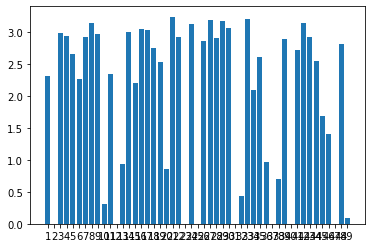

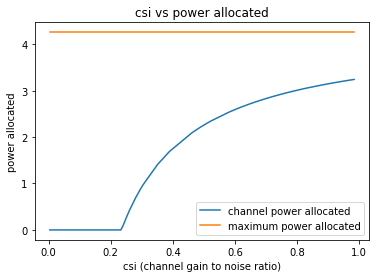

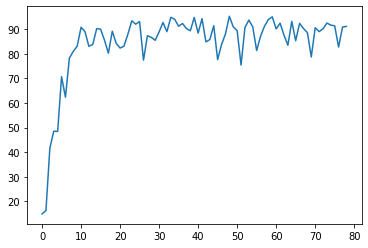

79
Power Allocated= 3.841381990217015
CSI= 0.9445928204734712
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06697606219256191
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.844655756424434
CSI= 0.9475229176560077
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7946923075019585
CSI= 0.24358477519911892
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.824591


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108725
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044685

Power Allocated= 2.3385638602639984
CSI= 0.39040001063625906
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456352
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.346890
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207628

Power Allocated= 3.165650131122729
CSI= 0.5765718994448825
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.687272
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017538
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 1.854798120558932
CSI= 0.3283812262510465
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.728632
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033886
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038790

Power Allocated= 2.589093348173332
CSI= 0.43272325012449897

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5825, Accuracy: 7787/10000 (78%)

Power in training Round= 97.99229730537849



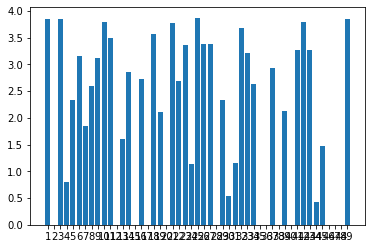

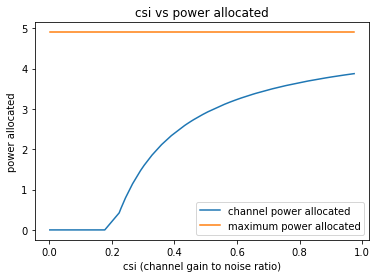

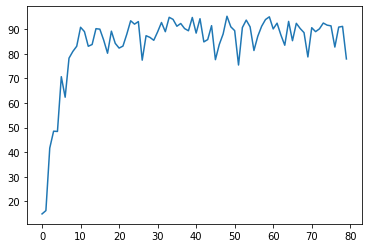

80
Power Allocated= 2.70752780981538
CSI= 0.5242263888046235
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.567738


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155794
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139256

Power Allocated= 3.1698462695064724
CSI= 0.6919197351910005
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.132715
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068878
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191372

Power Allocated= 0
CSI= 0.17201730788505143
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7819051411941125
CSI= 0.545495566324545
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.239455


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020209
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097795

Power Allocated= 0
CSI= 0.027614827335932346
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.955005574328295
CSI= 0.6023751526255865
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399846
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004532
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062580

Power Allocated= 1.2524310766332394
CSI= 0.2973827758919195
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.635771
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159708
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215373

Power Allocated= 2.13188040529967
CSI= 0.4027029090822798
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.366660
Model client8 Train Epoch: 2 [0/1

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4472, Accuracy: 8468/10000 (85%)

Power in training Round= 98.00362618808809



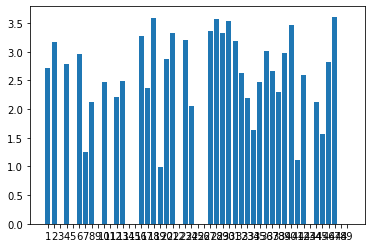

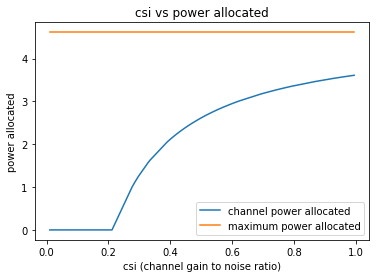

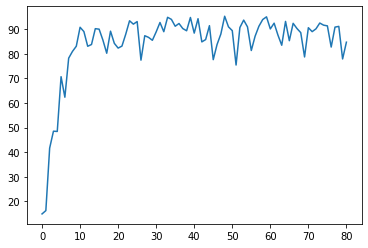

81
Power Allocated= 0.8625735143981705
CSI= 0.2821149551644233
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.537607


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.423918
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235888

Power Allocated= 2.2607494441961826
CSI= 0.4658793657469247
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.18293299012941044
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.230708290710476
CSI= 0.8499646172271234
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.212720


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056704
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084542

Power Allocated= 2.720807460083409
CSI= 0.5929719563382728
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.195297
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125631
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.799441

Power Allocated= 0
CSI= 0.04302782259227489
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3101801059528246
CSI= 0.9115373529286674
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.556609
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047610
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079111

Power Allocated= 2.359246513497234
CSI= 0.4882856988875378
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.673622
Model client8 Train Epoch: 2 [0/1

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5031, Accuracy: 8451/10000 (85%)

Power in training Round= 97.99952929297075



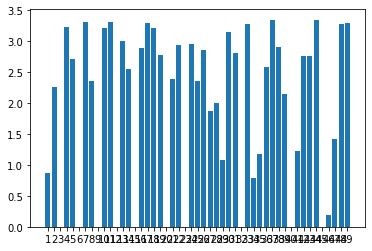

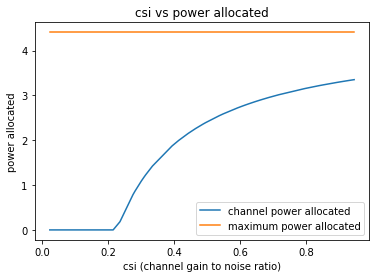

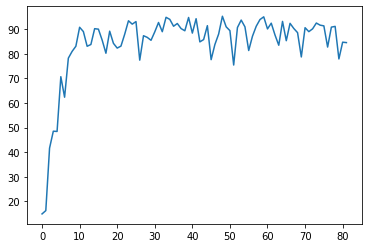

82
Power Allocated= 1.882715516807453
CSI= 0.4189754472681686
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5968773519428856
CSI= 0.5978669765030586
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.900761998393957
CSI= 0.7306052305485172
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.118288610761629
CSI= 0.8686575743847583
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525262


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099061
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002674

Power Allocated= 0
CSI= 0.1506272997610102
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.232962561659817
CSI= 0.9647595886004172
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.250861


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014376
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029400

Power Allocated= 0
CSI= 0.1941475496586792
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.962692730061113
CSI= 0.4335014248620854
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.993907
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004143
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057885

Power Allocated= 2.169037831723233
CSI= 0.47608791525861194
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.767191
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015830
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122069

Power Allocated= 3.1029911332025293
CSI= 0.8572659926266398
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.499324
Model client11 Train Epoch: 2 [

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4693, Accuracy: 8521/10000 (85%)

Power in training Round= 97.99567685440677



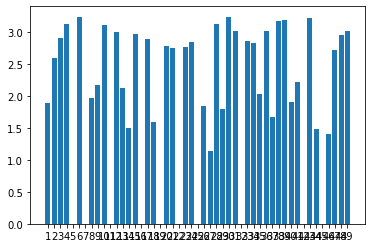

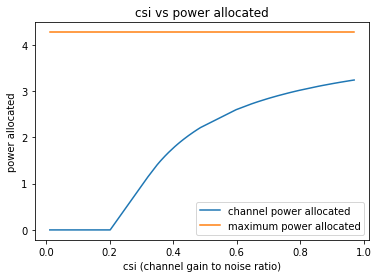

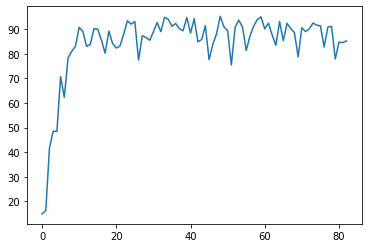

83
Power Allocated= 0.9835000354166743
CSI= 0.3150098287428813
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.347426


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107168
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142527

Power Allocated= 1.647792329091235
CSI= 0.39837275423599494
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.475713
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050804
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.542361

Power Allocated= 2.1730939627157273
CSI= 0.5038011303349946
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327818
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000074
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122615

Power Allocated= 2.75471179996263
CSI= 0.7126098808058045
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324749
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004781
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000902

Power Allocated= 2.934892192325695
CSI= 0.8175866380678554
S

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018104
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027936

Power Allocated= 0.6087310991672501
CSI= 0.28174783495738365
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.561480
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185549
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016300

Power Allocated= 3.029818292297616
CSI= 0.8863787700205986
SNR= 23.641228135642812
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.683491
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000147
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092107

Power Allocated= 1.7400860869345443
CSI= 0.4135789429612222
SNR= 23.671158746923165
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.555304
Model client19 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008296
Model client19 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021874

Power Allocated= 2.891427998274371
CSI= 0.78

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2261, Accuracy: 9316/10000 (93%)

Power in training Round= 98.00221019077968



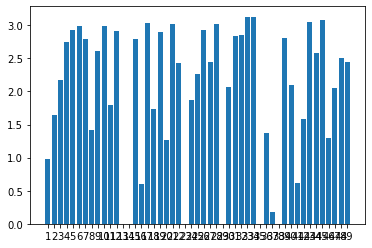

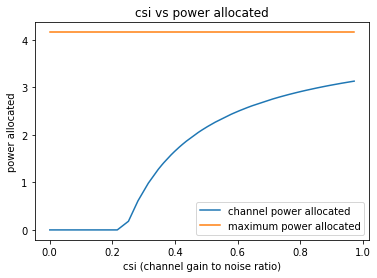

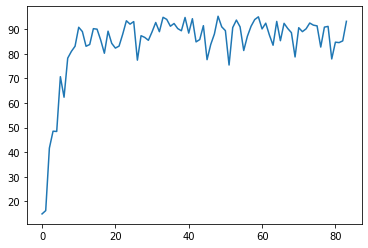

84
Power Allocated= 1.6294166778583588
CSI= 0.38828254279863395
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002112


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070816
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109175

Power Allocated= 0
CSI= 0.15709996708266782
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1087450324897405
CSI= 0.4770728823208997
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.176763


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020054
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.308471

Power Allocated= 3.1752433326617604
CSI= 0.9712344760695273
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.120157808576681
CSI= 0.9219113345235169
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.582690
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074401
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039749

Power Allocated= 0
CSI= 0.07242058665229101
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.957605303885897
CSI= 0.44498722696491366
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.549856
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022111
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000009

Power Allocated= 0
CSI= 0.0595

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2029, Accuracy: 9352/10000 (94%)

Power in training Round= 98.00378226580412



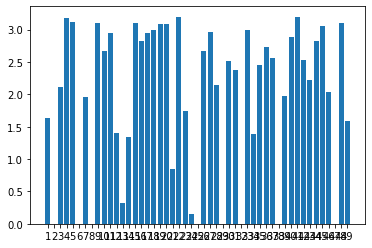

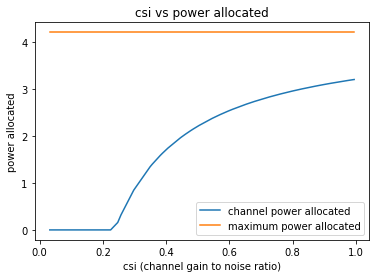

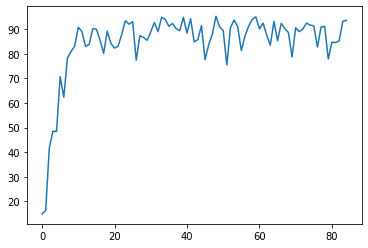

85
Power Allocated= 3.156057662988729
CSI= 0.5916066145825509
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.362225


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031380
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026708

Power Allocated= 1.849133495028079
CSI= 0.33364066378493107
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1738329168926254
CSI= 0.272291323036862
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.518985
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137294
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033483

Power Allocated= 2.999453971480862
CSI= 0.541443112354356
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.174073400629859
CSI= 0.3742099490314921
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1951572407989763
CSI= 0.6056154500684453
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073025
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000579

Power Allocated= 3.144830719201751
CSI= 0.5877031290666752
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261957
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000274
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000058

Power Allocated= 3.539810424350301
CSI= 0.7653688097850397
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.234609
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006782
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017177

Power Allocated= 0
CSI= 0.1982771526912528
SNR= 21.10269532158381
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5267409380726695
CSI= 0.7577886670587596
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.009288
Model client15 Train Ep

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6622, Accuracy: 7481/10000 (75%)

Power in training Round= 97.9932821370004



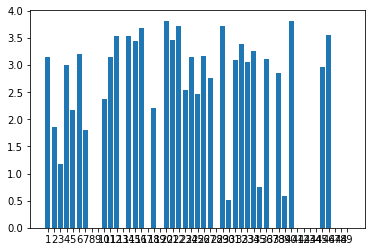

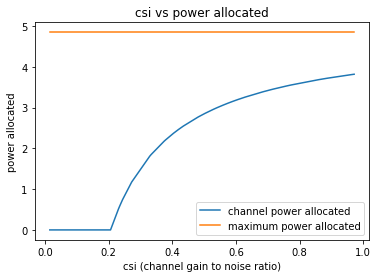

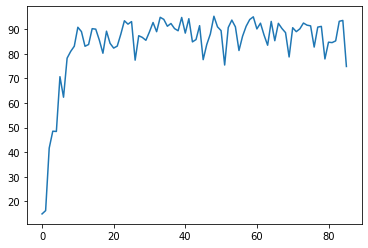

86
Power Allocated= 0
CSI= 0.13178460166062222
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21204602869531797
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.73676376719839
CSI= 0.6527426058293667
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.62656604694505
CSI= 0.6089410231125006
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.0004986649849296754
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.02128371193339862
SNR= 17.437510126097536
Client: client6


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1243719801653524
CSI= 0.8738285697410253
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.144388749313361
CSI= 0.8893850027176781
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.111617


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029631
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016294

Power Allocated= 3.2100694541303536
CSI= 0.9445620018363206
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.0925786780846685
CSI= 0.4595202780110299
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.551868
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012399
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099614

Power Allocated= 2.086481930610036
CSI= 0.45823649223404717
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.176418
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000836
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000346

Power Allocated= 3.1108569956031378
CSI= 0.8636292980489926
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.650506
Model 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.8152, Accuracy: 7409/10000 (74%)

Power in training Round= 97.998708564619



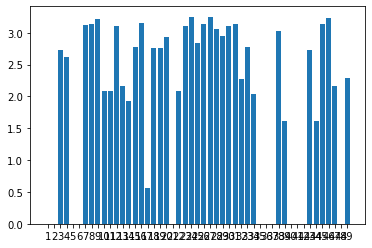

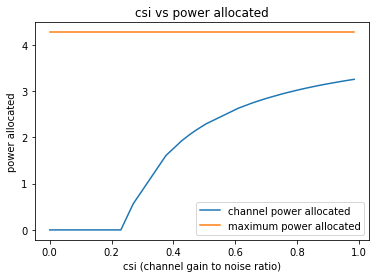

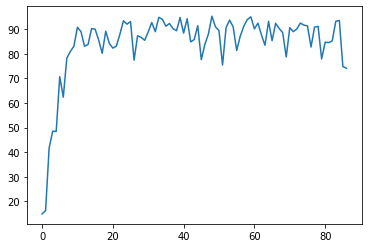

87
Power Allocated= 2.476767432676111
CSI= 0.5954122731576297
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.125015


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244859
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.194822

Power Allocated= 2.187849911331629
CSI= 0.508020096655242
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.172172
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182421
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336428

Power Allocated= 3.082261541316851
CSI= 0.9310861819279744
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.704277366144742
CSI= 0.40783057367362163
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116671
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025533
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000236

Power Allocated= 0
CSI= 0.00568645708484139
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5374337186056

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152285
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029085

Power Allocated= 0
CSI= 0.0005969248222156276
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.565294311595083
CSI= 0.6285427556565467
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.658638
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016520
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074110

Power Allocated= 2.719733895687996
CSI= 0.6961160506192082
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498570
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014232
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028230

Power Allocated= 3.0048157797923993
CSI= 0.8684624988893614
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469966
Model client12 Train Epoc

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3989, Accuracy: 8672/10000 (87%)

Power in training Round= 98.00100409455939



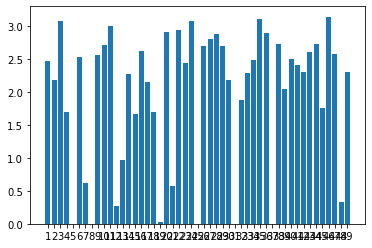

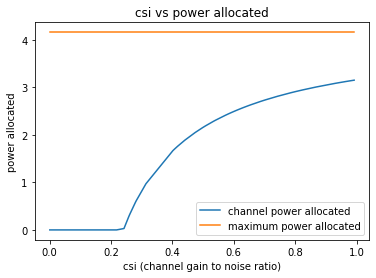

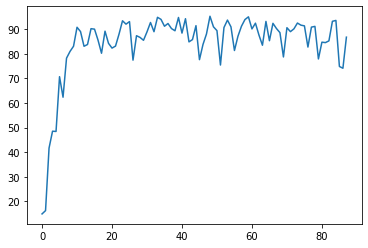

88
Power Allocated= 0
CSI= 0.18911031583407123
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5723213913639604
CSI= 0.3010269154949887
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.549689


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006663
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004326

Power Allocated= 1.6430511464763642
CSI= 0.307575681578535
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.490902
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060662
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.761083

Power Allocated= 0
CSI= 0.151361799481336
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.829479672207494
CSI= 0.9391401454368841
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422917
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195730
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316563

Power Allocated= 3.3413325435088415
CSI= 0.6439353481804931
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750565
Model client6 Train Epoch: 2 [0/121

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2364, Accuracy: 9325/10000 (93%)

Power in training Round= 97.99962959649652



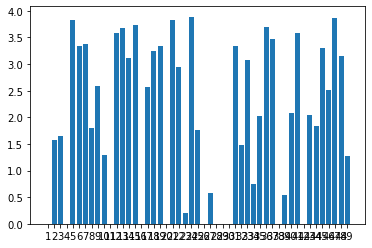

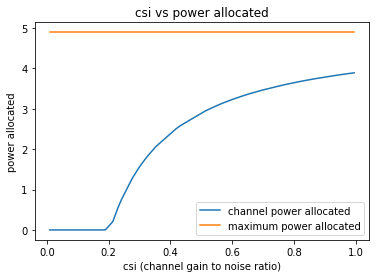

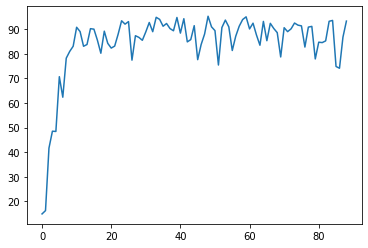

89
Power Allocated= 1.6416230216168826
CSI= 0.3214164241297258
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.3951025055303505
CSI= 0.7365130437577694
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.10171484847272172
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.16880225392281023
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.010911065154008526
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7773567448790777
CSI= 0.5062022516564297
SNR= 17.437510126097536
Client: client6


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352101
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000137
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020648

Power Allocated= 0
CSI= 0.019620606929101614
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.248902502256408
CSI= 0.39936912318241635
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474573
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000096
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109990

Power Allocated= 0
CSI= 0.026245647729216004
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4120643787613325
CSI= 0.7458304355473191
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385441
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019562
Model client11 Train Epoch: 3 [0/1216 (0%

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3116, Accuracy: 9460/10000 (95%)

Power in training Round= 98.00585090455026



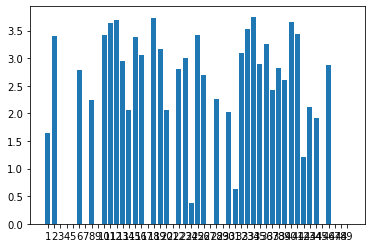

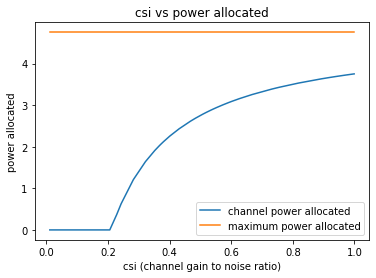

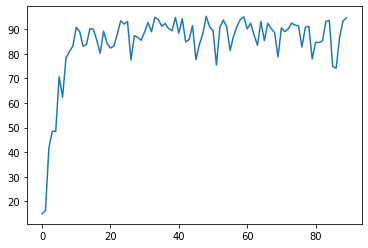

90
Power Allocated= 3.1868832633748063
CSI= 0.9802957328700554
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.909942


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272485
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090962

Power Allocated= 2.910325051320675
CSI= 0.7712130588262247
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5063194920052814
CSI= 0.5880055912002895
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344379
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032950
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045639

Power Allocated= 0
CSI= 0.11636211409109742
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0002615296295927
CSI= 0.8286912376510098
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.602880


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100373
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032458

Power Allocated= 2.031632516935368
CSI= 0.4596959135062266
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.573895
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013310
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007194

Power Allocated= 3.112984956317503
CSI= 0.9140779217493112
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.0745275826143903
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4273933746568832
CSI= 0.35976526089548333
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.343209
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016044
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069249

Power Allocated= 0.847829129776

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2237, Accuracy: 9430/10000 (94%)

Power in training Round= 98.0008481774054



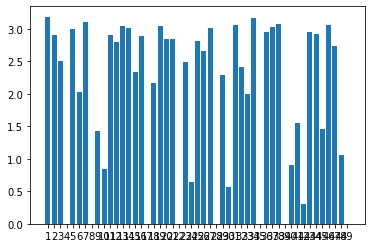

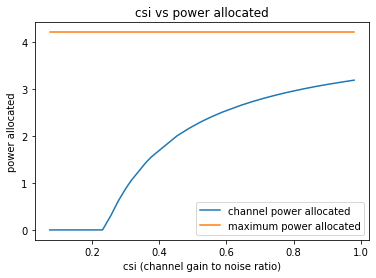

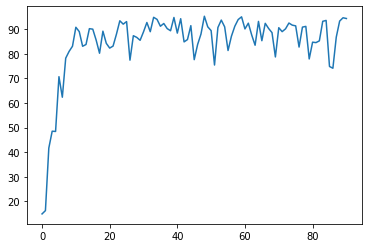

91
Power Allocated= 3.0794894329372777
CSI= 0.7252550287061381
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.1156456148944556
CSI= 0.42686352162035157
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.929254


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001328
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.424621

Power Allocated= 2.895395113411739
CSI= 0.6398281601284955
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400203
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100512
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048360

Power Allocated= 3.1568340339867733
CSI= 0.7683555985890218
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525338
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096649
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008699

Power Allocated= 3.1079903558911908
CSI= 0.7405627856257181
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.559334
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132488
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.441370

Power Allocated= 0
CSI= 0.08058689910810746
SNR= 17.4375101

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074655
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182338

Power Allocated= 1.8261661051950089
CSI= 0.3799177524817213
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.707008
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022588
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029003

Power Allocated= 0.006797956306023423
CSI= 0.22464253079739116
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.765734
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227034
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031127

Power Allocated= 0
CSI= 0.11867351135042936
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.0282340988715166
CSI= 0.2915383338358961
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481985
Model client12 Train Epoc

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2756, Accuracy: 9123/10000 (91%)

Power in training Round= 98.00737321923603



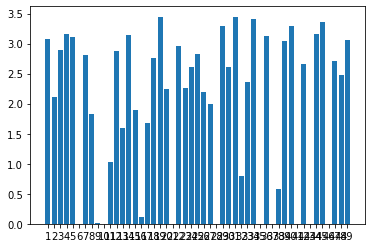

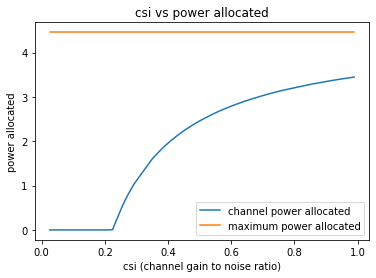

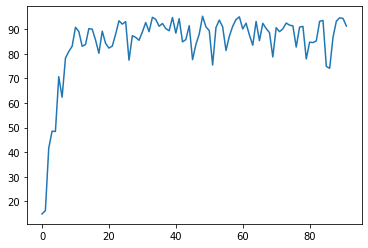

92
Power Allocated= 0
CSI= 0.22579596279436664
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.186755483833678
CSI= 0.9298383487554235
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.277604


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028182
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029149

Power Allocated= 1.9533708436554882
CSI= 0.4331178559015485
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252868
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003676
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005614

Power Allocated= 0
CSI= 0.14079269927881366
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.5630206395490784
CSI= 0.27032940697313257
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.759853
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129980
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152464

Power Allocated= 2.384588058794949
CSI= 0.5325882278042318
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716940
Model client6 Train Epoch: 2 [0

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4832, Accuracy: 8706/10000 (87%)

Power in training Round= 97.99674113365258



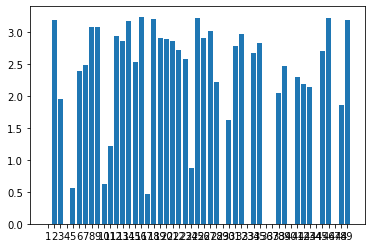

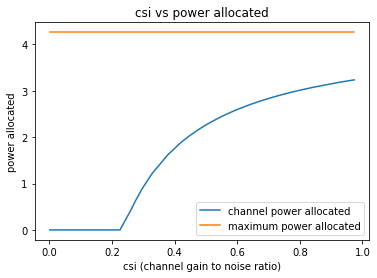

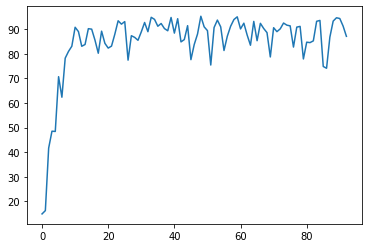

93
Power Allocated= 3.1575288342189634
CSI= 0.5959258547731214
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426022


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275559
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029913

Power Allocated= 3.1955844457072127
CSI= 0.6097540540423817
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447882
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000141
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077109

Power Allocated= 2.642340841181452
CSI= 0.4559445617184966
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9977209132304026
CSI= 0.544108412711014
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.181725
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030443
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055195

Power Allocated= 0.890364250772524
CSI= 0.2534709236610625
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.314095
Model client5 Trai

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044143
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051257

Power Allocated= 3.324235602041685
CSI= 0.6616582052130044
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.171633
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017026
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003482

Power Allocated= 1.9237114302537868
CSI= 0.34342092088502096
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.402537
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003124
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075207

Power Allocated= 3.4804635474596237
CSI= 0.7379385451044357
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294525
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041888
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011067

Power Allocated= 0.8293967063362855
CSI= 0.2496

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.1935, Accuracy: 9419/10000 (94%)

Power in training Round= 98.00245369486102



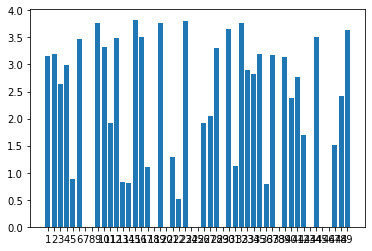

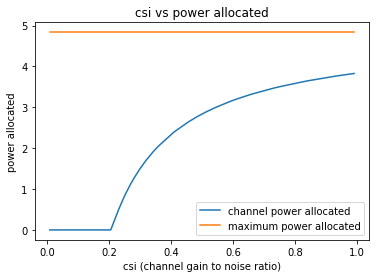

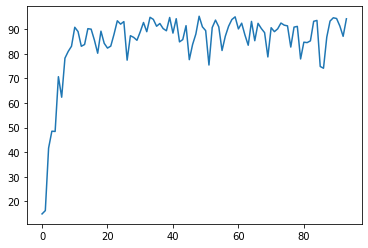

94
Power Allocated= 0
CSI= 0.028917449754514157
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.52123207943481
CSI= 0.9355660181792894
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.17456335479675733
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0277397344996517
CSI= 0.6400557096931241
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5620526170668345
CSI= 0.9727142758254197
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504554


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148255
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.264644

Power Allocated= 0
CSI= 0.08282302139209363
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2542474146222093
CSI= 0.7485834993919707
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.555920
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143822
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077457

Power Allocated= 3.0355441780951575
CSI= 0.643269017705527
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.510680
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000283
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000010

Power Allocated= 1.125195768297913
CSI= 0.28860795415691154
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.519344
Model client9 Train Epoch: 2 [0/

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3533, Accuracy: 8903/10000 (89%)

Power in training Round= 98.00129536055726



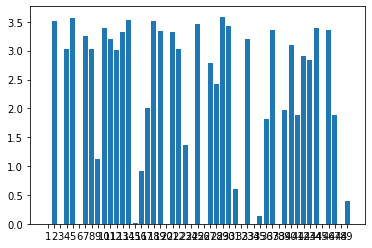

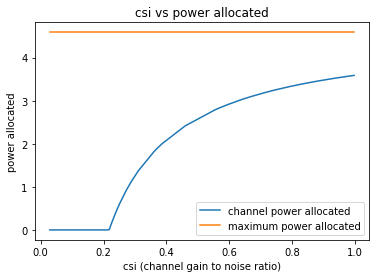

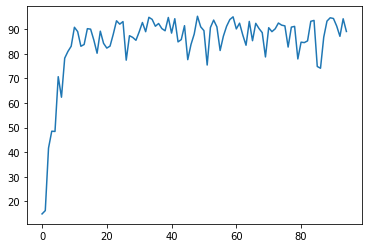

95
Power Allocated= 1.510594155780724
CSI= 0.37782634547548033
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.095453


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056939
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.131935

Power Allocated= 3.113462958593349
CSI= 0.9579922740014619
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.523926
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001027
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106865

Power Allocated= 2.6400418849803007
CSI= 0.6590781167682648
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.518353
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166189
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001847

Power Allocated= 2.4238525732377063
CSI= 0.5768808737078513
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.023937
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121360
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141212

Power Allocated= 2.0822561780088957
CSI= 0.4819145806907142

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020427
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017657

Power Allocated= 1.5668576637574247
CSI= 0.38603256222036
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388381
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092408
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018796

Power Allocated= 2.570377571308857
CSI= 0.6301454758225331
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.398493156180723
CSI= 0.5685631570829073
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.899287
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112651
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086028

Power Allocated= 2.0386889371286556
CSI= 0.4720045207455994
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.844794
Model client1

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2196, Accuracy: 9321/10000 (93%)

Power in training Round= 98.00616430764268



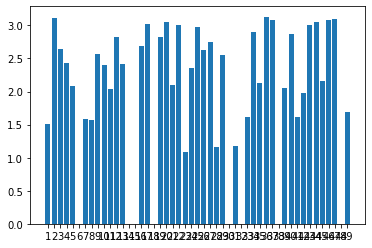

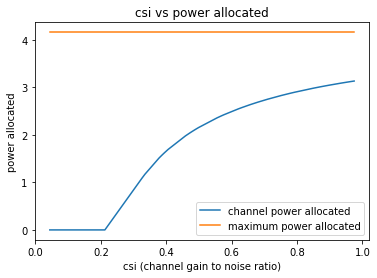

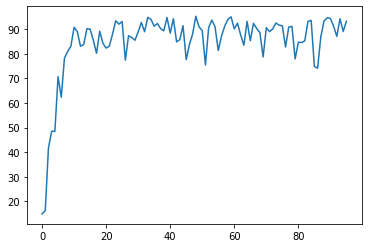

96
Power Allocated= 0.8532001512699909
CSI= 0.28562756330748695
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.818282


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131698
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.290463

Power Allocated= 0.9372753337291959
CSI= 0.29265544666196774
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712492
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113303
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179591

Power Allocated= 0
CSI= 0.18764577600611476
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.965421215570183
CSI= 0.7200245113849864
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.340151783768467
CSI= 0.3317727803929713
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.840156


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030421
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.505402

Power Allocated= 2.9865446142240533
CSI= 0.7311447587382548
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629033
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099552
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120111

Power Allocated= 3.2082736010759207
CSI= 0.8726085556506122
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.577020
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101632
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.188438

Power Allocated= 0
CSI= 0.10772682908572062
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.10945901288602733
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1629088247800539
CSI= 0.31

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3074, Accuracy: 9030/10000 (90%)

Power in training Round= 97.99553144845184



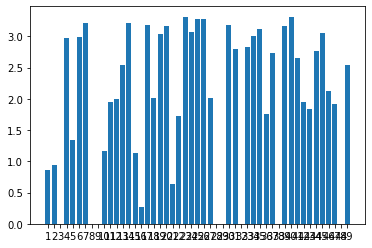

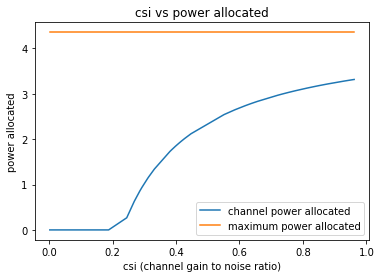

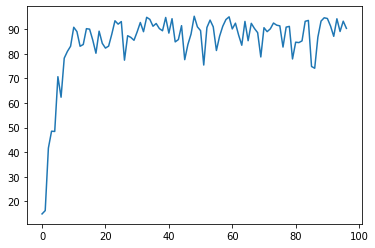

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packa

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049418
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034321

Power Allocated= 3.432610947013374
CSI= 0.749718882265022
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.506988
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018892
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349131

Power Allocated= 3.2985061829315683
CSI= 0.6812276582270989
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427350
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021725
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057416

Power Allocated= 2.433633689419149
CSI= 0.4286674727709626
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.179551
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263590
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000010

Power Allocated= 1.2180914180876359
CSI= 0.28182090459249665


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209699
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013786

Power Allocated= 0
CSI= 0.14614560055665626
SNR= 18.914892373117546
Client: client11
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.574604491812828
CSI= 0.8390389796342652
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.2047206677385517
SNR= 20.21487098457923
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.7012223243555553
CSI= 0.9387715294416166
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.139038
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.546320606228072
CSI= 0.819589079650247
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.511363

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4167, Accuracy: 8696/10000 (87%)

Power in training Round= 97.99260850601215



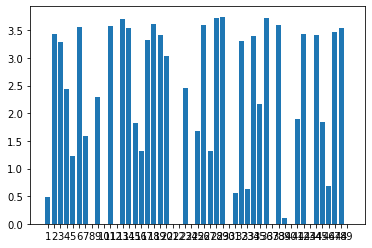

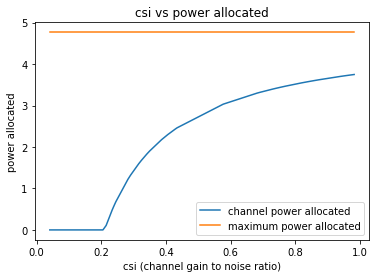

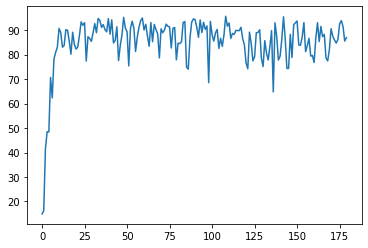

180
Power Allocated= 3.3239010717878803
CSI= 0.888347891579318
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385113


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.202214
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081431

Power Allocated= 2.6948202411066493
CSI= 0.5698765704304233
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.175238
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075995
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043867

Power Allocated= 3.2711089490783607
CSI= 0.8485526631838881
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.872437
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086392
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057573

Power Allocated= 0
CSI= 0.15148376496463434
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.294822847690842
CSI= 0.8659783045350044
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.11318670847

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052132
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001057

Power Allocated= 0
CSI= 0.20900858489525442
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.854594867237891
CSI= 0.626962659093457
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.226839
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004965
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.0551485272049392
CSI= 0.2945996067056743
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.882200
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040035
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269159

Power Allocated= 2.8902416792789944
CSI= 0.6412951045111004
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.550318
Model client11 Train Epoch: 2 [

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3291, Accuracy: 8986/10000 (90%)

Power in training Round= 97.99762232201594



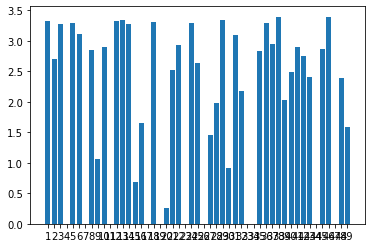

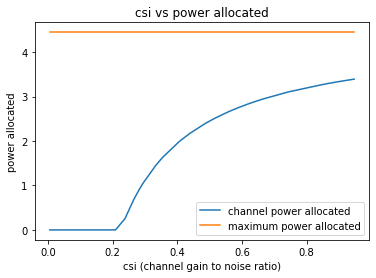

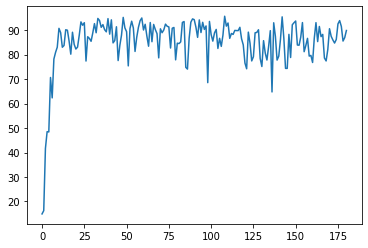

181
Power Allocated= 2.638026686254062
CSI= 0.4995219768230297
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.1444603833370555
CSI= 0.2860837239835443
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.264835


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060824
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009803

Power Allocated= 3.584854063344334
CSI= 0.9477895480180625
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.291530
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048461
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005243

Power Allocated= 0
CSI= 0.17563778761736193
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.177917431416686
CSI= 0.6839836847297694
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.757966


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245957
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000008

Power Allocated= 3.602577983367059
CSI= 0.9639830619699209
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.743733
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007066
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 0
CSI= 0.10812380933143162
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9055036856745375
CSI= 0.5765559915668339
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.679458
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002042
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011716

Power Allocated= 1.267698627069437
CSI= 0.296538624876057
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459522
Model client9 Train Epoch: 2 [0/12

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5777, Accuracy: 8064/10000 (81%)

Power in training Round= 97.9985076394146



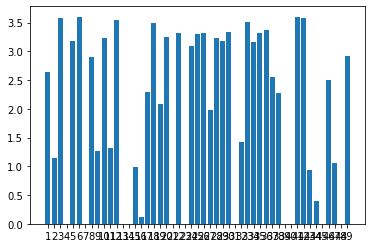

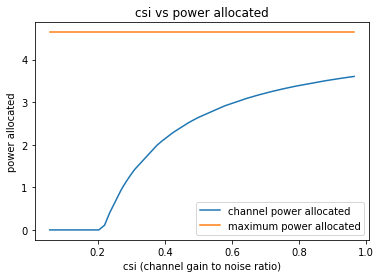

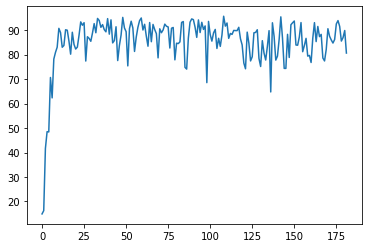

182
Power Allocated= 2.5603131617706856
CSI= 0.6242803215444925
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.720006857461469
CSI= 0.6934087589755179
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364020


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019784
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.527870

Power Allocated= 0
CSI= 0.15638761653023558
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.0987866482779527
CSI= 0.9404055466951216
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.940150


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073406
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 2.718827597822465
CSI= 0.692842215685951
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.038887
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070073
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064171

Power Allocated= 0.05304899066671087
CSI= 0.24336177985428764
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.476688
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220575
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015649

Power Allocated= 3.023803322172902
CSI= 0.878461094709679
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.774165407565769
CSI= 0.7204651152925999
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.148674
Model client8 Trai

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4348, Accuracy: 8638/10000 (86%)

Power in training Round= 97.99290379576205



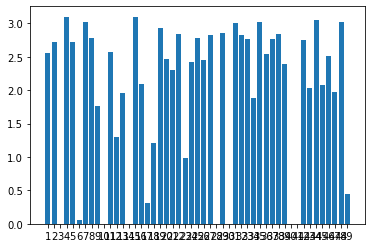

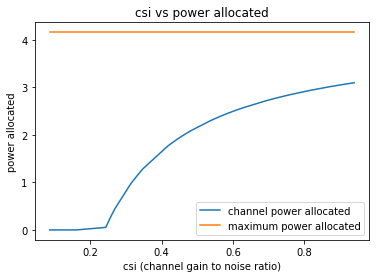

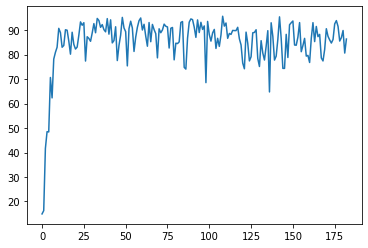

183
Power Allocated= 2.427996889814545
CSI= 0.5239671608979596
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.583270


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072374
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197040

Power Allocated= 1.3907159822528476
CSI= 0.33946665147886745
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.251528
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037700
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389707

Power Allocated= 0
CSI= 0.12116501461598894
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.134669128159493
CSI= 0.8320545244438453
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.283864


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072151
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000078

Power Allocated= 0
CSI= 0.04564570688489622
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.307556903641462
CSI= 0.971858345384257
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.277529
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015098
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000458

Power Allocated= 2.9490776383674406
CSI= 0.7207540676999994
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2603709908694576
CSI= 0.9292450064038368
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.125297
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072848
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017426

Power Allocated= 2.569543246288

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3327, Accuracy: 9265/10000 (93%)

Power in training Round= 98.00610055129275



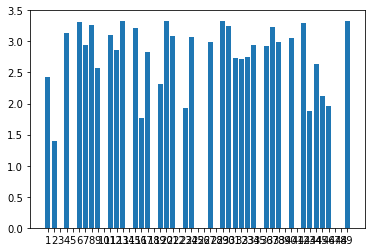

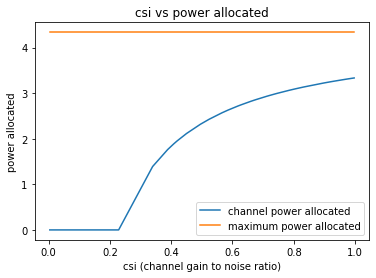

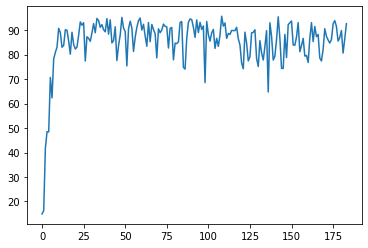

184
Power Allocated= 3.132971907064493
CSI= 0.692871887963288
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.501698


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065816
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083759

Power Allocated= 2.2557567905978546
CSI= 0.43094469571246363
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.2593274314675464
CSI= 0.4316088332621514
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.458674
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180397
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121578

Power Allocated= 3.488730756282914
CSI= 0.9195322776844155
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.3358077130391304
CSI= 0.4463424018307899
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.120864
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042003
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217352

Power Allocat

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064180
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013856

Power Allocated= 2.378258777248356
CSI= 0.4549629070355944
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.211671
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000023
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.441823

Power Allocated= 0
CSI= 0.17529819795396218
SNR= 18.277362932132007
Client: client9
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4652889668630915
CSI= 0.32144509430352
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496210
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009439
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089666

Power Allocated= 3.1585866811527756
CSI= 0.7053909958648622
SNR= 19.617974866806932
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.554220
Model client12 Train Epoch: 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4323, Accuracy: 8844/10000 (88%)

Power in training Round= 98.00011835392078



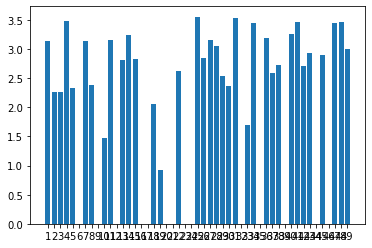

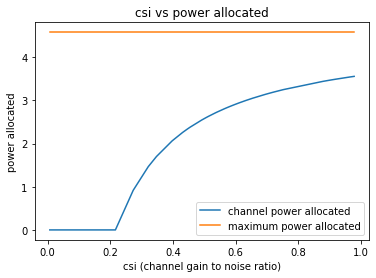

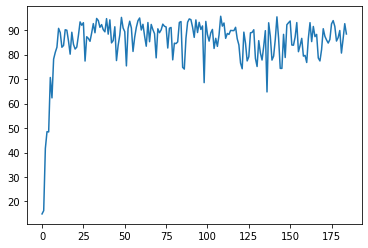

185
Power Allocated= 3.691736429839664
CSI= 0.9964723663038848
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.07333980245967153
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.4681437764224134
CSI= 0.4490078054889586
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.969119485118743
CSI= 0.5793215572953875
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020038


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015963
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210145

Power Allocated= 3.6373300949722474
CSI= 0.9452274201178856
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.501407681555349
CSI= 0.45581575707092337
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396148
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004160
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.488459

Power Allocated= 1.002186820791259
CSI= 0.27077598239936784
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.779319
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038999
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.495226031731674
CSI= 0.8332982514369612
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750401
Model client8 Tr

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6441, Accuracy: 8237/10000 (82%)

Power in training Round= 98.00364480467435



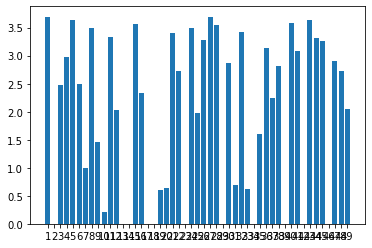

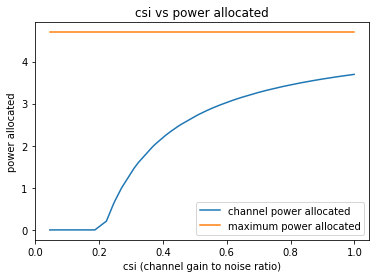

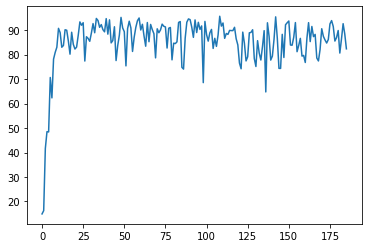

186
Power Allocated= 3.196552323225461
CSI= 0.8839170471703348
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.731160834953763
CSI= 0.3851012981278994
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.031015


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085310
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033722

Power Allocated= 3.233136258246954
CSI= 0.9134556109005607
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.09859435597245148
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.804675846844529
CSI= 0.6565107269559138
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.041996


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071567
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075261

Power Allocated= 1.2109605150535248
CSI= 0.32082956883926994
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.185469
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000316
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.013872351768801083
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.000654533546637
CSI= 0.429696188288621
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.099378
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010024
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004549

Power Allocated= 2.634380911827633
CSI= 0.5904933084170535
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.576426
Model client9 Train Epoch: 2 [0/

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5361, Accuracy: 8512/10000 (85%)

Power in training Round= 97.99315223871268



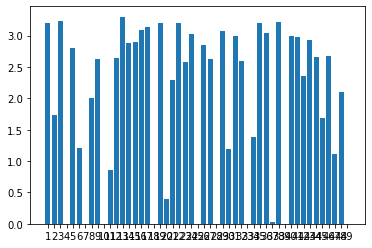

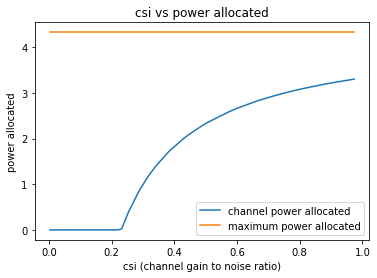

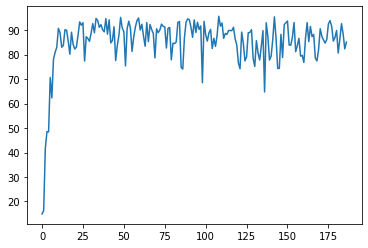

187
Power Allocated= 2.588016210920582
CSI= 0.5615757240252035
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.547916


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190732
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206848

Power Allocated= 1.9791651704237263
CSI= 0.41848799711501117
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.7139563899969334
CSI= 0.37668137735382323
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.094730
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257413
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003650

Power Allocated= 1.914633856807034
CSI= 0.4074836643428502
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.158927
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077011
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005159

Power Allocated= 2.415696011282012
CSI= 0.5120264900337494
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.624105
Model client5 T

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200350
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.7078352372387613
CSI= 0.3758148519354758
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.462607
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119461
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013332

Power Allocated= 3.126194449462754
CSI= 0.804812446468627
SNR= 23.641228135642812
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.692560
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004348
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059150

Power Allocated= 0
CSI= 0.10734326659105242
SNR= 23.671158746923165
Client: client19
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.779639291784843
CSI= 0.3862374820243112
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663621
Model client20 Train 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4146, Accuracy: 8657/10000 (87%)

Power in training Round= 97.99728066624424



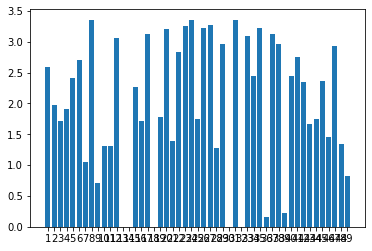

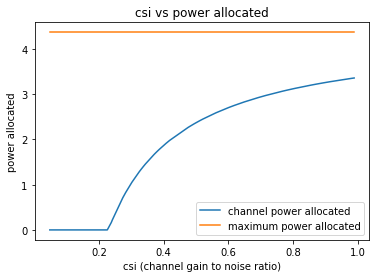

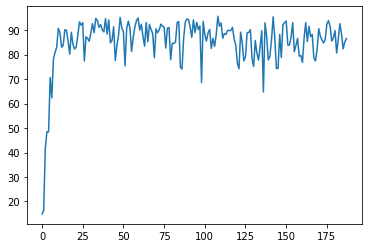

188
Power Allocated= 3.563757659052837
CSI= 0.9632286010427441
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406217


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078967
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125200

Power Allocated= 0
CSI= 0.07856123008165872
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.5557880542345437
CSI= 0.32828380776143795
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.431998


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014680
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000404

Power Allocated= 3.5074239322254153
CSI= 0.9136517927618298
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.614975
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000041
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075519

Power Allocated= 0
CSI= 0.1731861629069108
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.06839380484588242
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.550384732282472
CSI= 0.9509788658228345
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.438532
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.476535
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013736

Power Allocated= 3.376680880958803
CSI= 0.81615

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.2215, Accuracy: 9324/10000 (93%)

Power in training Round= 97.99603432245293



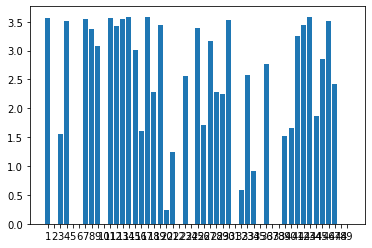

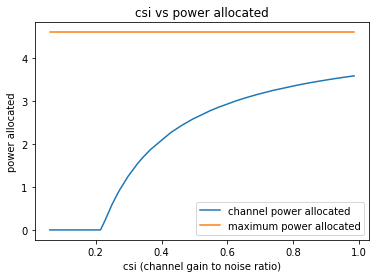

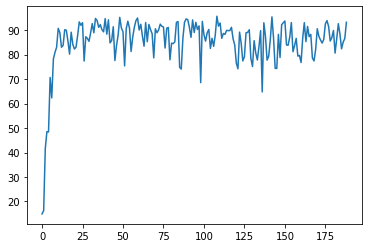

189
Power Allocated= 3.0917502692526466
CSI= 0.7088548267033753
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.873883677812649
CSI= 0.6140270736260219
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569182


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042886
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235840

Power Allocated= 3.4352926437850755
CSI= 0.9370457803396465
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.871281
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002022
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190755

Power Allocated= 2.9606470076561444
CSI= 0.6485802058334056
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.508353
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012268
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017803

Power Allocated= 3.188504048556563
CSI= 0.7610510432900599
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392685
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162678
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050285

Power Allocated= 0
CSI= 0.21125058868751811
SNR= 17.4375101

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060657
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043415

Power Allocated= 3.318780150371551
CSI= 0.8448113546166466
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.950612
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002526
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000009

Power Allocated= 2.196064848308614
CSI= 0.4335739715415
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461146
Model client9 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212440
Model client9 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056945

Power Allocated= 2.573554773536607
CSI= 0.5184243911111359
SNR= 18.914892373117546
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639039
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077151
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003500

Power Allocated= 3.0300261115207907
CSI= 0.6791400929674125


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3020, Accuracy: 8997/10000 (90%)

Power in training Round= 97.99491743554309



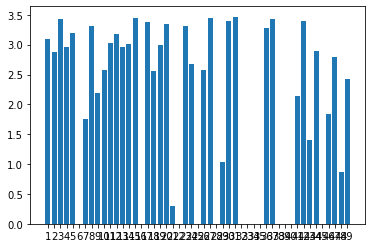

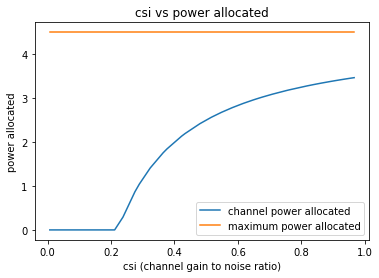

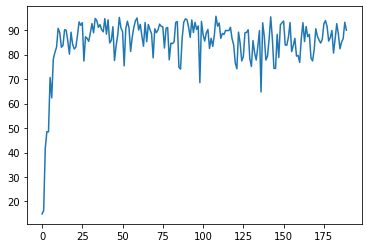

190
Power Allocated= 2.928898977666402
CSI= 0.9195504775109227
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640658


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010166
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030456

Power Allocated= 2.477724733468048
CSI= 0.6499152632716414
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406453
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141856
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105117

Power Allocated= 2.7435546484370543
CSI= 0.7856495083847027
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.283952
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026149
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.056804

Power Allocated= 1.2787650250682199
CSI= 0.36528054672521737
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466331
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055298
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 2.1083168121875837
CSI= 0.524089774373906

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client23 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000854
Model client23 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000136

Power Allocated= 0
CSI= 0.09440411236099433
SNR= 25.54477251682601
Client: client24
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.887606519495337
CSI= 0.8859119578444387
SNR= 26.062430762064338
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603381
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180329
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000483

Power Allocated= 1.4145161671898854
CSI= 0.3843388541117547
SNR= 26.09145636224758
Client: client26
Model client26 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.540167
Model client26 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061737
Model client26 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038226

Power Allocated= 2.8281583393376812
CSI= 0.8415889569825455
SNR= 26.108203962774297
Client: client27
Model client27 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.853926
Model client27 Train 

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.9850, Accuracy: 7318/10000 (73%)

Power in training Round= 98.00442051471192



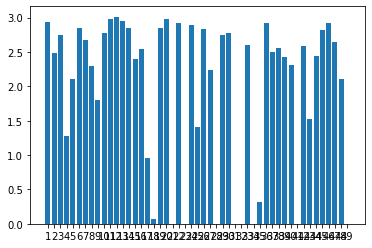

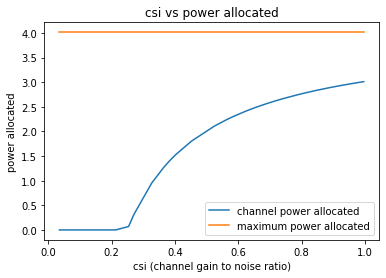

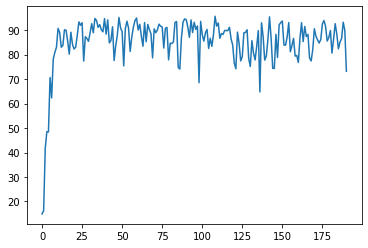

191
Power Allocated= 0
CSI= 0.20565191413703932
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.628487973989783
CSI= 0.7128626468580742
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.8204187960756846
CSI= 0.8258566070225253
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.7853430981388199
CSI= 0.44524793767871507
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.605608


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235086
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 2.623714729873633
CSI= 0.7104452379826257
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.529595
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138360
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.463571

Power Allocated= 1.901216975255048
CSI= 0.46946906987447723
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.881091
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041772
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000073

Power Allocated= 2.7833677329846886
CSI= 0.8013366158922209
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.506080
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030083
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031156

Power Allocated= 2.0881344708930625
CSI= 0.51462876436384
S

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3486, Accuracy: 8908/10000 (89%)

Power in training Round= 97.99936857512489



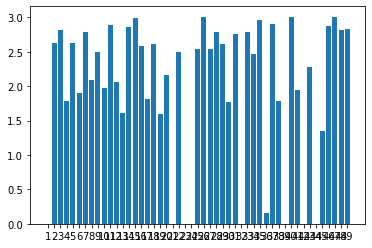

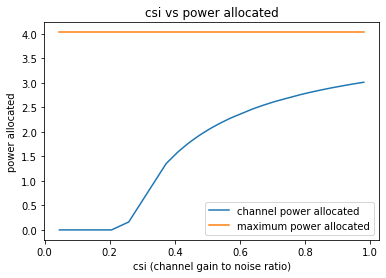

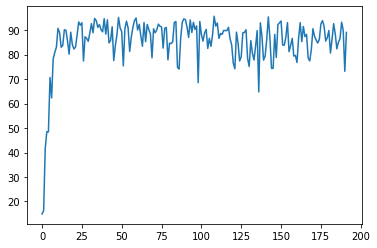

192
Power Allocated= 3.123810353677888
CSI= 0.6896941045526969
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.845259


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081684
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379585

Power Allocated= 2.6868742428111307
CSI= 0.5299826387478435
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.14536176709471826
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.875409952282502
CSI= 0.5888176863504208
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5290702779406904
CSI= 0.9572508745500705
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.724044


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214594
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122612

Power Allocated= 0
CSI= 0.07733927767753968
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9964497354864026
CSI= 0.6340033355513541
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.066417
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007255
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058065

Power Allocated= 0.6686441105156842
CSI= 0.25607641202392195
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.872127
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110907
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134278

Power Allocated= 2.8781042709719444
CSI= 0.5897533078558205
SNR= 18.277362932132007
Client: client9
Model client9 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.679639
Model client9 Train Epoch: 2 [

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4296, Accuracy: 8446/10000 (84%)

Power in training Round= 98.00162642476474



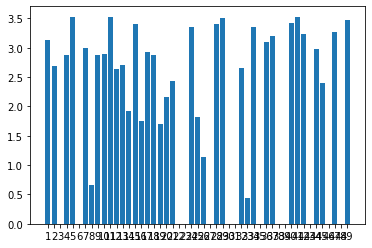

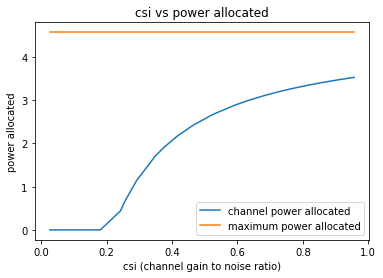

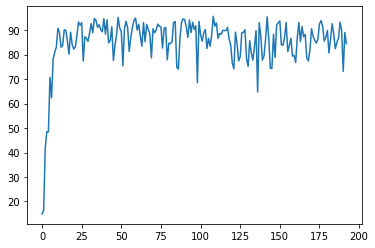

193
Power Allocated= 0.17600852065033923
CSI= 0.24792644536364195
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795644


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063285
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038758

Power Allocated= 2.731054150976653
CSI= 0.6764029360865477
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.909252
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015432
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086602

Power Allocated= 3.0966950526456802
CSI= 0.8986600637829733
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.6834118961872822
CSI= 0.39587482966978393
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.948932
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032489
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000285

Power Allocated= 1.5932324084064629
CSI= 0.38222932333753046
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.792919
Model client5 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.0532288480133456
CSI= 0.8648768145455545
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721915
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092851
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335668

Power Allocated= 2.180233752042748
CSI= 0.49279797431449257
SNR= 22.970977389425087
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.806267
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007906
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031023

Power Allocated= 2.565817316369885
CSI= 0.6084036769651127
SNR= 23.265767002826422
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296917
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155896
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055259

Power Allocated= 3.104107144181919
CSI= 0.904

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4339, Accuracy: 8708/10000 (87%)

Power in training Round= 97.99915802716922



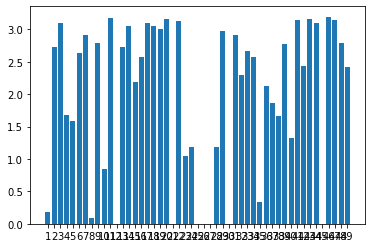

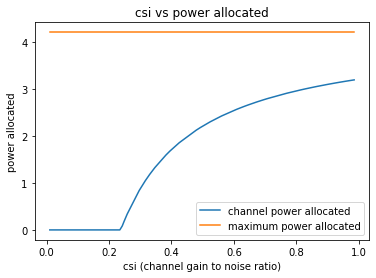

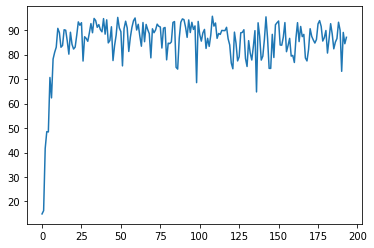

194
Power Allocated= 1.1611168859715062
CSI= 0.3085773029565725
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.1630396515832695
CSI= 0.8072612952286515
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.604988


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005470
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022834

Power Allocated= 3.057514576363031
CSI= 0.74389189082739
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.2898307362144825
CSI= 0.24319271983253432
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.866727
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004570
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005801

Power Allocated= 2.9234975263570293
CSI= 0.6764534113556206
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.112831
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067823
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013220

Power Allocated= 2.8018719271567285
CSI= 0.6250296867286684
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.744978
Model client6 Tra

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000104
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347302

Power Allocated= 0
CSI= 0.09873427044260208
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2642844548633088
CSI= 0.879112008492227
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.849318
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000651
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000195

Power Allocated= 1.7601953022501458
CSI= 0.3785583590711784
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.060436
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.110628506274062
CSI= 0.7744928965071151
SNR= 21.282865161770438
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.311183
Model client15 Train E

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3094, Accuracy: 9181/10000 (92%)

Power in training Round= 97.99891185011381



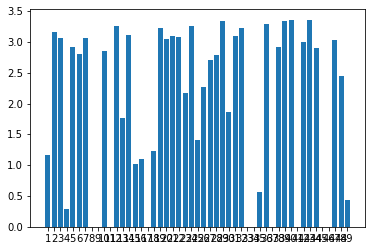

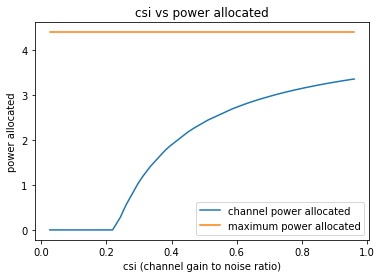

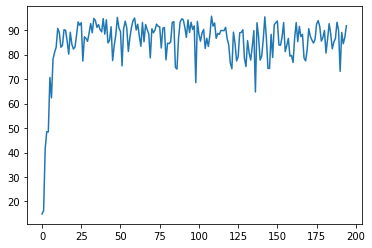

195
Power Allocated= 0
CSI= 0.018393482586709253
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.483044269990009
CSI= 0.8453972582653383
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.9212228472498474
CSI= 0.2670442835057312
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.978052


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024588
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000928

Power Allocated= 3.546791575548185
CSI= 0.8935524032971074
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.5590531100996428
CSI= 0.47463840648837785
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.038415621319607185
SNR= 17.437510126097536
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.4456797477202636
CSI= 0.31053582483456077
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.246636
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011257
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.05885331738808086
SNR= 18.240138213805025
Client: client8
Poor Channel, client not taken for averaging in this round

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.3003, Accuracy: 9114/10000 (91%)

Power in training Round= 98.00694269667919



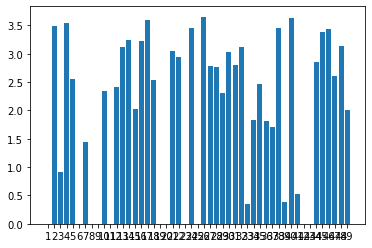

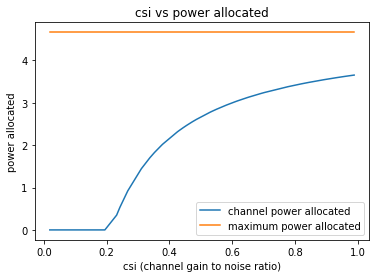

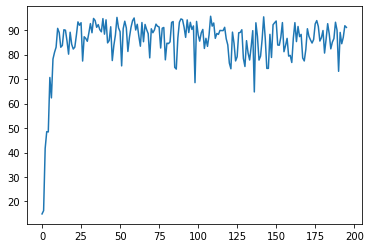

196
Power Allocated= 2.9143977385210826
CSI= 0.5760700897660448
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9306228319986056
CSI= 0.581505298287126
SNR= 14.332070782953625
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.624581


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049203
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012625

Power Allocated= 1.2005994160697075
CSI= 0.2898804304494391
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.155114
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055769
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035686

Power Allocated= 3.508794822900915
CSI= 0.8760381519653849
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.762086160448612
CSI= 0.5296017008295109
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897535
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268620
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006501

Power Allocated= 3.1106256354650994
CSI= 0.6494889889942366
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.113409
Model client6 Tra

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142928
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000700

Power Allocated= 0
CSI= 0.015269671550910413
SNR= 19.617974866806932
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.256755619571726
CSI= 0.7175958818434129
SNR= 20.21487098457923
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.808478
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014575
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021864

Power Allocated= 3.3138815863737783
CSI= 0.748269981466004
SNR= 21.10269532158381
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.250133
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.0733524261586036
SNR= 21.282865161770438
Client: client15
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.10029395673

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.4525, Accuracy: 8622/10000 (86%)

Power in training Round= 97.9977400294385



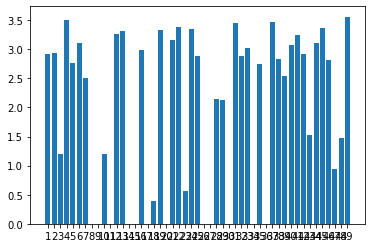

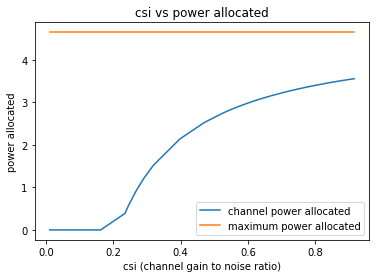

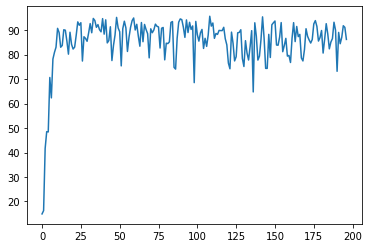

197
Power Allocated= 0
CSI= 0.18378276649466674
SNR= 12.391541912965952
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.7214904665616957
CSI= 0.407327190194712
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.7750681460570732
CSI= 0.2271977952525488
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.581871


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated du

Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042846
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004613

Power Allocated= 3.6995982487248797
CSI= 0.6770842581175548
SNR= 14.895764896583488
Client: client4
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.13973266236305004
SNR= 17.422815656359372
Client: client5
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9334970787988683
CSI= 0.4458270572602112
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.644747
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000602
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000154

Power Allocated= 3.8261008428599608
CSI= 0.7405112011611323
SNR= 17.821153629927974
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586370
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150972
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004864

Power Allocated= 3.9294000518

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.6228, Accuracy: 8033/10000 (80%)

Power in training Round= 98.00467053968994



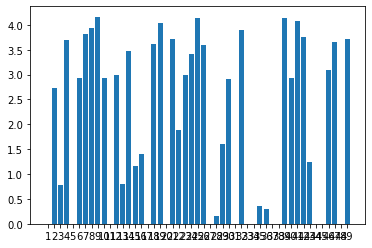

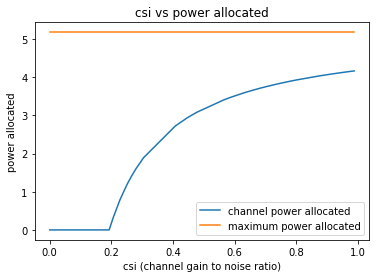

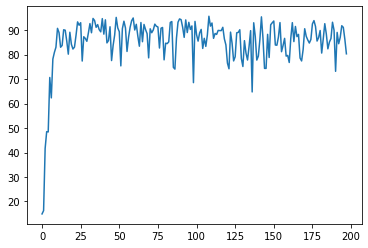

198
Power Allocated= 0.9839536802258566
CSI= 0.30335187806154307
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.844290


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291507
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232399

Power Allocated= 3.193888085922856
CSI= 0.9203295090957492
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 2.9178754546752224
CSI= 0.7339018702997888
SNR= 14.769954042132602
Client: client3
Model client3 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.314475
Model client3 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041002
Model client3 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148212

Power Allocated= 0.5548646211323596
CSI= 0.26841380293626993
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522600
Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054624
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333637

Power Allocated= 1.620902411351119
CSI= 0.37600303098123355
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.532831
Model client5 T

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104848
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.270648

Power Allocated= 2.9438393776610523
CSI= 0.7481579997673099
SNR= 23.641228135642812
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.276321
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155357
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 0.7318533228704536
CSI= 0.2818011055799807
SNR= 23.671158746923165
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.529186
Model client19 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055844
Model client19 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 1.4389413987569841
CSI= 0.35192506013481095
SNR= 23.712132960103503
Client: client20
Model client20 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.929418
Model client20 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196032
Model client20 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198095

Power Allocated= 3.0803987975054765
CSI= 0.

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.5173, Accuracy: 8424/10000 (84%)

Power in training Round= 98.00377904119924



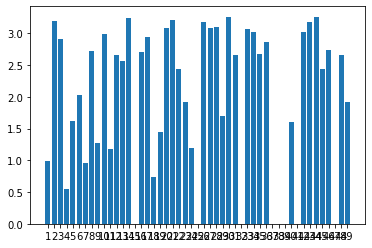

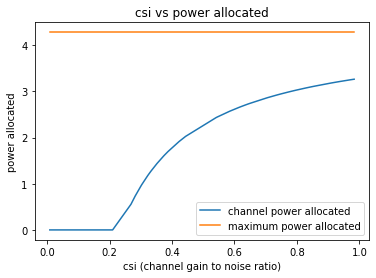

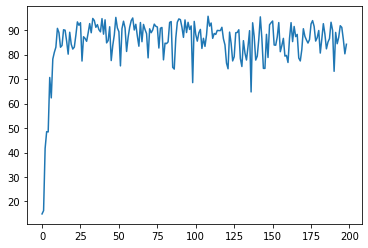

199
Power Allocated= 2.748256508539876
CSI= 0.49806753478300436
SNR= 12.391541912965952
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.458603


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058700
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000122

Power Allocated= 0
CSI= 0.01584584758074492
SNR= 14.332070782953625
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.2781408911353767
CSI= 0.6766469980700619
SNR= 14.769954042132602
Client: client3
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.065709468375942
CSI= 0.5916085443082265
SNR= 14.895764896583488
Client: client4
Model client4 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273937


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


Model client4 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045757
Model client4 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008412

Power Allocated= 2.0203312776491993
CSI= 0.36553915002747595
SNR= 17.422815656359372
Client: client5
Model client5 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.679195
Model client5 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149670
Model client5 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110161

Power Allocated= 3.030938257264152
CSI= 0.5796838983755299
SNR= 17.437510126097536
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.183388
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004058
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041221

Power Allocated= 0
CSI= 0.037217438722420115
SNR= 17.821153629927974
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.0773759008081094
CSI= 0.2718395589087569
SNR= 18.240138213805025
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.704691
Model client8 Train Epoch: 2 [

/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)



Test set: Average loss for Final model: 0.7144, Accuracy: 7677/10000 (77%)

Power in training Round= 97.9948671768596



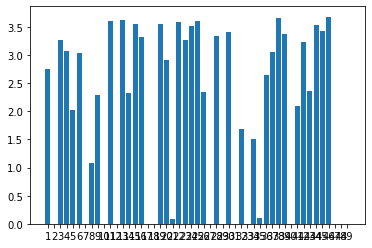

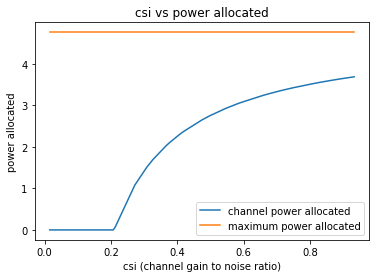

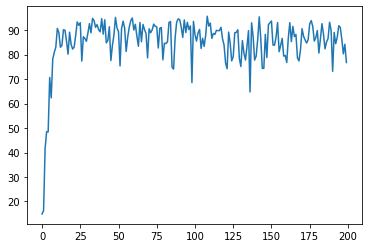

200


In [12]:
for fed_round in range(args.rounds):
    
    client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round

    # Training 
    #even slot
    
    snr=[] #snr of the channel
    csi=[] #csi of the channel
    for ii in range (int(args.clients)-1):
        #snr.append(random.uniform(args.snr_low, args.snr_high))
        csi.append(random.uniform(args.csi_low,args.csi_high))
    
    # if(fed_round==0):
    #     snr,cluster_head=get_cluster()
    if(fed_round==0): #fed_round==0 or True                                        %%%static or moving
        snr,cluster_head=get_cluster(args.clients)
        temp=copy.deepcopy(cluster_head)
        temp1=copy.deepcopy(snr)
    else:
        #print(temp)
        cluster_head=copy.deepcopy(temp)
        snr=copy.deepcopy(temp1)
    #print(cluster_head)
    smallmu1=0
    gsmall1=3.402823466E+38 
    
    #water filling algorithm
    mu=1e-15
    while(mu<=1):
        #print("yay")
        #pn=max(1/mu-1/csi,0)
        g1=0
        pn1=0
        for jj in csi:
            pn=max(1/mu-1/jj,0)
            g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
            pn1+=pn
        g=g1-mu*(pn1-P*(int(args.clients)-1))
        if(g<gsmall1):
            smallmu1=mu
            gsmall1=g
        mu+=0.00002

    #print(smallmu1)
    # poptim=max(1/smallmu1-1/csi1,0)
    # print(poptim)
    index=0
    members=[]
    for i in clients:
        if(i['hook'].id!=cluster_head):
            members.append(i)
        else:
            head=i
    for client in members:
        goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1)
        if(goodchannel):
            client_good_channel.append(client)
        index+=1
        
    po=[]    
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    
    plt.bar([str(i) for i in range (1,len(po)+1)],po,)
    csi.sort()
    po=[]
    for jj in csi:
        po.append(max(1/smallmu1-1/jj,0))
    fig,ax=plt.subplots()
    line1=ax.plot(csi,po,label="channel power allocated")
    line2=ax.plot(csi,[1/smallmu1]*len(csi),label="maximum power allocated")
    ax.set_title("csi vs power allocated")
    ax.set_xlabel("csi (channel gain to noise ratio)")
    ax.set_ylabel("power allocated")
    ax.legend()
    #plt.show()
    

#     # Testing 
#     for client in active_clients:
#         test(args, client['model'], device, client['testset'], client['hook'].id)
    
    
    
    print()
    print("Clients having a good channel and considered for training")
    for no in range (len(client_good_channel)):
        print(client_good_channel[no]['hook'].id)
        
        
        
    # Averaging 
        #odd slot

    head['model'] = averageModels(head['model'],client_good_channel)
    # Testing the average model
    #test(args, global_model, device, global_test_loader, 'Global')
    ac=test(args, head['model'], device, global_test_loader, 'Final')
    accuracy.append(ac)
    
    print("Power in training Round=",sum(po))
    #print("Power cap=",P*len(active_clients))
    
    #print("Total Power =",power_odd+power_even)
    print()
            
    # Share the global model with the clients
    index=0
    for client in members:
        client['model'].load_state_dict(head['model'].state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1) #CHANGE:Commented
        index+=1
        #client['model']=torch.quantization.quantize_dynamic(client['model'],{torch.nn.Conv2d},dtype=torch.qint8)
        #print(client['model'].conv1.weight.data)
    fig1,ax1=plt.subplots()
    ax1.plot([i for i in range(len(accuracy))],accuracy)
    plt.show()
    print(rc)
    rc+=1

In [13]:
print(accuracy)

[14.9, 16.24, 41.64, 48.51, 48.41, 70.66, 62.32, 78.19, 80.93, 83.03, 90.74, 88.99, 83.02, 83.74, 90.17, 89.97, 85.52, 80.19, 89.15, 84.21, 82.28, 83.09, 87.93, 93.38, 92.01, 93.05, 77.38, 87.31, 86.63, 85.45, 88.87, 92.68, 88.94, 94.79, 93.95, 91.16, 92.27, 90.21, 89.32, 94.72, 88.37, 94.22, 84.8, 85.74, 91.39, 77.58, 83.73, 88.0, 95.22, 90.92, 89.37, 75.4, 90.63, 93.66, 90.91, 81.3, 87.1, 91.15, 93.88, 94.98, 90.07, 92.4, 87.58, 83.44, 93.12, 85.28, 92.34, 90.24, 88.56, 78.68, 90.56, 88.96, 90.1, 92.46, 91.6, 91.31, 82.7, 90.8, 91.1, 77.87, 84.68, 84.51, 85.21, 93.16, 93.52, 74.81, 74.09, 86.72, 93.25, 94.6, 94.3, 91.23, 87.06, 94.19, 89.03, 93.21, 90.3, 91.73, 68.55, 93.58, 88.21, 85.52, 88.89, 90.3, 82.53, 86.67, 83.37, 88.03, 95.69, 91.66, 92.93, 86.66, 88.65, 88.27, 89.9, 89.83, 89.82, 91.17, 86.48, 83.97, 76.55, 74.22, 89.2, 84.67, 77.43, 79.14, 88.92, 89.08, 90.17, 78.44, 75.15, 85.71, 80.67, 77.8, 83.36, 89.8, 64.75, 93.02, 87.49, 77.77, 79.38, 86.22, 95.44, 86.71, 74.38, 74.3